In [1]:
'''
2022.3.11
术后并发症模型：
'''

'\n2022.3.11\n术后并发症模型：\n'

In [2]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [3]:
df_model =pd.read_excel(project_path +'/data/result/feature_engineering/df_4.5_model_data_forward_POC.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [4]:
# 删除基因突变检测
df_model=df_model.drop(['gene_mutation'],axis=1)

In [5]:
df_model.columns

Index(['target_POC', 'gender', 'emaciation', 'endocrine_disease', 'HBcAb',
       'Bismuth_C', 'surgery_bleeding', 'surgery_plasm', 'ALT', 'tumor_AFP',
       'tumor_CEA', 'biliary_disease', 'tumor_CA199', 'tumor_CA125',
       'tumor_size', 'AJCC_8', 'PTCD_ERCP', 'surgery_result'],
      dtype='object')

In [6]:
df_model.shape

(369, 18)

In [7]:
df_model['target_POC'].value_counts()

1    239
2     63
3     49
4     18
Name: target_POC, dtype: int64

## 并发症数据再处理

In [8]:
# 术后并发症二分类
df_model['target_POC']=df_model.target_POC.apply(lambda x: np.nan if pd.isnull(x) else
                                                        0 if x ==1 else
                                                        1 if x == 2 else
                                                        1 if x == 3 else
                                                        1 if x == 4 else x)

In [9]:
df_model['target_POC'].value_counts()

0    239
1    130
Name: target_POC, dtype: int64

In [10]:
# 手术输血，改为0-1变量
df_model['surgery_plasm']=df_model.surgery_plasm.apply(lambda x: np.nan if pd.isnull(x) else
                                                                0 if re.match('0',str(x)) else 1)
# 手术出血，分层. 输血0-150、150-300、300-500、>500
df_model['surgery_bleeding']=df_model.surgery_bleeding.apply(lambda x: np.nan if pd.isnull(x) else
                                                                0 if x<=150 else
                                                                1 if 150<x<=300 else
                                                                2 if 300<x<=500 else
                                                                3 if x>500 else x)

In [11]:
df_model.surgery_bleeding.value_counts()

1.0    121
0.0     91
2.0     79
3.0     69
Name: surgery_bleeding, dtype: int64

In [12]:
df_model.columns

Index(['target_POC', 'gender', 'emaciation', 'endocrine_disease', 'HBcAb',
       'Bismuth_C', 'surgery_bleeding', 'surgery_plasm', 'ALT', 'tumor_AFP',
       'tumor_CEA', 'biliary_disease', 'tumor_CA199', 'tumor_CA125',
       'tumor_size', 'AJCC_8', 'PTCD_ERCP', 'surgery_result'],
      dtype='object')

In [13]:
discrete_col=['gender', 'emaciation','endocrine_disease', 'HBcAb', 'Bismuth_C','biliary_disease',
             'AJCC_8', 'PTCD_ERCP','surgery_bleeding','surgery_plasm', 'surgery_result']

continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('target_POC')

## 数据归一化

In [14]:
# 防止不同维特征数据差距过大，影响建模效果
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# df_model[continuous_col]=ss.fit_transform(df_model[continuous_col])
for i in continuous_col:
    df_model[[i]] = ss.fit_transform(df_model[[i]])

In [15]:
df_model.columns

Index(['target_POC', 'gender', 'emaciation', 'endocrine_disease', 'HBcAb',
       'Bismuth_C', 'surgery_bleeding', 'surgery_plasm', 'ALT', 'tumor_AFP',
       'tumor_CEA', 'biliary_disease', 'tumor_CA199', 'tumor_CA125',
       'tumor_size', 'AJCC_8', 'PTCD_ERCP', 'surgery_result'],
      dtype='object')

In [16]:
df_model.to_excel(project_path+'/data/result/modeling/df_1.2_数据归一化.xlsx')

## 插补数据

In [17]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum()>0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)

        rfr = RandomForestRegressor(n_estimators=300,
                                    random_state=3)
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [18]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)
# df_model_cb=df_model

In [19]:
df_model_cb.shape

(369, 18)

In [20]:
# 保存插补数据
df_model_cb.to_excel(project_path + '/data/result/modeling/df_1.3_model_data_插补.xlsx')

## 划分数据集

### 计算随机数种子

In [21]:
df_model_cb.target_POC.value_counts()

0    239
1    130
Name: target_POC, dtype: int64

In [23]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['target_POC'],axis=1)
y = df_model_cb['target_POC']

seeds_list=[]
cat_f1_list=[]
for i in range(101):
    
    tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=i)
    
    # 分类数据过采样
    from imblearn.over_sampling import SMOTE,ADASYN 
    sm = SMOTE(random_state=0)
    tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)
#     tran_x_sm,tran_y_sm=tran_x,tran_y
    
    import xgboost
    cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
    # 分类模型
    cat_model.fit(tran_x_sm,tran_y_sm)
    cat_predictions=cat_model.predict(test_x)
    cat_f1=f1_score(test_y,cat_predictions,average='macro')
    # 防止分类数据的测试集划分不平衡
    if not (2 >=(test_y.value_counts().values[0])/(test_y.value_counts().values[-1]) >=1):
        continue

#     import catboost
#     # CatBoost模型
#     cat_model=catboost.CatBoostRegressor(iterations=300, 
#                                           learning_rate=0.2, 
#                                           depth=6,
#                                           l2_leaf_reg=2,
#                                           subsample=1,
#                                           loss_function='RMSE', # 'CrossEntropy',
#                                           random_state=3)
#     # 回归模型
#     cat_model.fit(tran_x,tran_y)
#     cat_predictions=cat_model.predict(test_x)
#     cat_f1=r2_score(test_y,cat_predictions)
    
    seeds_list.append(i)
    cat_f1_list.append(cat_f1)

In [24]:
test_y.value_counts()

0    50
1    24
Name: target_POC, dtype: int64

In [25]:
df_seeds=pd.DataFrame(data={'seed':seeds_list,
                           'cat_f1':cat_f1_list})
df_seeds=df_seeds.sort_values(['cat_f1'], ascending=0).reset_index(drop=True)
df_seeds.to_excel(project_path+'/data/df_seeds.xlsx')

In [26]:
df_seeds.head()

,seed,cat_f1
0,71,0.745704
1,12,0.722500
2,37,0.710163
3,53,0.704056
4,46,0.700405


In [27]:
seed_index=df_seeds.loc[0,'seed']

In [28]:
seed_index

71

### 划分数据集

In [334]:
# 分类随机数种子
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['target_POC'],axis=1)
y = df_model_cb['target_POC']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=seed_index)

In [335]:
df_model.shape

(369, 18)

In [336]:
print(tran_x.shape)
print(test_x.shape)

(295, 17)
(74, 17)


In [337]:
df_model.target_POC.value_counts()

0    239
1    130
Name: target_POC, dtype: int64

In [338]:
tran_y.value_counts()

0    194
1    101
Name: target_POC, dtype: int64

In [339]:
test_y.value_counts()

0    45
1    29
Name: target_POC, dtype: int64

In [340]:
tran_x.head()

,gender,emaciation,endocrine_disease,HBcAb,Bismuth_C,surgery_bleeding,surgery_plasm,ALT,tumor_AFP,tumor_CEA,biliary_disease,tumor_CA199,tumor_CA125,tumor_size,AJCC_8,PTCD_ERCP,surgery_result
71,1,0.33,0.0,1.000000,4.0,2.0,0.0,-0.025564,-0.014352,0.087559,0.0,1.686405,-0.228935,1.882875,3.0,1.0,1.0
29,1,0.00,0.0,0.000000,3.0,1.0,0.0,-0.115250,0.041158,-0.175891,0.0,-0.886097,-0.227928,-1.525509,2.0,0.0,1.0
141,0,0.00,0.0,0.726667,2.0,2.0,1.0,-0.358092,-0.148501,0.772531,0.0,-0.279433,0.592441,1.008930,4.0,0.0,1.0
283,1,2.00,0.0,1.000000,3.0,0.0,0.0,5.472881,-0.092991,-0.175891,0.0,-0.644983,-0.153766,-0.738959,2.0,1.0,1.0
50,0,0.00,0.0,1.000000,3.0,0.0,0.0,1.919934,-0.139249,-0.307617,0.0,-0.597884,0.099568,0.689066,4.0,1.0,4.0


In [341]:
test_x.head()

,gender,emaciation,endocrine_disease,HBcAb,Bismuth_C,surgery_bleeding,surgery_plasm,ALT,tumor_AFP,tumor_CEA,biliary_disease,tumor_CA199,tumor_CA125,tumor_size,AJCC_8,PTCD_ERCP,surgery_result
68,0,0.0,0.0,1.00,3.0,2.0,0.0,0.409069,-0.092991,-0.281272,1.0,-0.878068,-0.157390,-0.301987,3.0,1.0,1.0
187,1,0.0,0.0,0.74,3.0,2.0,0.0,1.453566,-0.072915,-0.202236,0.0,-0.484687,-0.220874,-0.738959,3.0,1.0,1.0
331,1,0.0,1.0,1.00,3.0,3.0,1.0,-0.680962,-0.042107,0.055945,0.0,0.532486,0.037092,0.466793,2.0,2.0,1.0
236,1,0.0,0.0,1.00,2.0,2.0,1.0,0.905791,-0.116120,-0.228581,0.0,-0.968519,-0.175252,-0.738959,2.0,2.0,1.0
200,1,0.0,0.0,1.00,3.0,0.0,0.0,-0.216664,-0.084356,-0.175421,1.0,0.147935,-0.141389,0.033317,3.0,0.0,4.0


In [342]:
test_y

68     1
187    0
331    1
236    0
200    0
      ..
259    1
263    0
218    1
285    0
266    1
Name: target_POC, Length: 74, dtype: int64

In [343]:
type(test_y)

pandas.core.series.Series

## 训练集过采样

In [344]:
# 进行过采样
from imblearn.over_sampling import SMOTE,ADASYN 
from imblearn.combine import SMOTETomek
sm = SMOTE(random_state=0)
# sm=ADASYN(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [345]:
tran_x_sm.shape

(388, 17)

In [346]:
tran_y_sm.value_counts()

1    194
0    194
Name: target_POC, dtype: int64

In [347]:
tran_x_sm.head()

,gender,emaciation,endocrine_disease,HBcAb,Bismuth_C,surgery_bleeding,surgery_plasm,ALT,tumor_AFP,tumor_CEA,biliary_disease,tumor_CA199,tumor_CA125,tumor_size,AJCC_8,PTCD_ERCP,surgery_result
0,1,0.33,0.0,1.000000,4.0,2.0,0.0,-0.025564,-0.014352,0.087559,0.0,1.686405,-0.228935,1.882875,3.0,1.0,1.0
1,1,0.00,0.0,0.000000,3.0,1.0,0.0,-0.115250,0.041158,-0.175891,0.0,-0.886097,-0.227928,-1.525509,2.0,0.0,1.0
2,0,0.00,0.0,0.726667,2.0,2.0,1.0,-0.358092,-0.148501,0.772531,0.0,-0.279433,0.592441,1.008930,4.0,0.0,1.0
3,1,2.00,0.0,1.000000,3.0,0.0,0.0,5.472881,-0.092991,-0.175891,0.0,-0.644983,-0.153766,-0.738959,2.0,1.0,1.0
4,0,0.00,0.0,1.000000,3.0,0.0,0.0,1.919934,-0.139249,-0.307617,0.0,-0.597884,0.099568,0.689066,4.0,1.0,4.0


In [75]:
tran_x_sm.to_excel(project_path+'/data/tran_x_sm.xlsx')
tran_y_sm.to_excel(project_path+'/data/tran_y_sm.xlsx')

## 二分类模型

In [112]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=20,
                            max_depth=3,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)


# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)


# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=0.1,
                        solver='newton-cg',
                         max_iter=5,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN_model = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[50,], 
                    solver='sgd', 
                    activation='relu', 
                    random_state=3)
ANN_model.fit(tran_x_sm, tran_y_sm)
ANN_predictions=ANN_model.predict(test_x)


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=200,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)
TabNet_predictions=TabNet_model.predict(test_x.to_numpy())

# 计算评价指标compute evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for model,name in zip(model_list,model_name_list):
#     print(name)
    # 计算accuracy和AUC
    if name =='TabNet':
        test_x_temp=test_x.copy()
        test_x=test_x.to_numpy()
    # 计算accuracy和AUC
    test_y_score=model.predict_proba(test_x)[:,-1]
    auc=roc_auc_score(test_y,test_y_score)
    auc=round(auc,2)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,2)
    # 计算灵敏度sensitivity和特异度spe    # 计算灵敏度sensitivity和特异度specificity
    # 计算灵敏度、特异度、假阴性率、假阳性率
    tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x)).ravel()
    sensitivity=round(tp/(tp+fn),2)
    specificity=round(tn/(fp+tn),2)
    FPR=round(fp/(fp+tn),2)
    FNR=round(fn/(fn+tp),2)
    # 计算约登指数
    youden_index=sensitivity+specificity-1
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                            [name,accuracy,auc,sensitivity,specificity]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,2),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0,sort=False)
    df_model_result=df_model_result.reset_index(drop=True)
    if name=='TabNet':
        test_x=test_x_temp.copy()
        
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)

0:	learn: 0.6269742	total: 1.91ms	remaining: 570ms
1:	learn: 0.5746489	total: 3.6ms	remaining: 537ms
2:	learn: 0.5413949	total: 5.18ms	remaining: 513ms
3:	learn: 0.4981192	total: 6.71ms	remaining: 496ms
4:	learn: 0.4608759	total: 8.16ms	remaining: 482ms
5:	learn: 0.4401955	total: 10.3ms	remaining: 503ms
6:	learn: 0.4211991	total: 12ms	remaining: 502ms
7:	learn: 0.3947780	total: 13.6ms	remaining: 498ms
8:	learn: 0.3707853	total: 15.4ms	remaining: 498ms
9:	learn: 0.3553486	total: 16.9ms	remaining: 491ms
10:	learn: 0.3437793	total: 18.3ms	remaining: 482ms
11:	learn: 0.3188551	total: 19.8ms	remaining: 474ms
12:	learn: 0.3044615	total: 21.3ms	remaining: 469ms
13:	learn: 0.2933831	total: 23ms	remaining: 469ms
14:	learn: 0.2845291	total: 24.8ms	remaining: 470ms
15:	learn: 0.2752924	total: 26.7ms	remaining: 474ms
16:	learn: 0.2616944	total: 28.5ms	remaining: 474ms
17:	learn: 0.2453160	total: 30.2ms	remaining: 473ms
18:	learn: 0.2359162	total: 31.6ms	remaining: 468ms
19:	learn: 0.2266933	total:

169:	learn: 0.0101729	total: 343ms	remaining: 262ms
170:	learn: 0.0101703	total: 345ms	remaining: 260ms
171:	learn: 0.0101416	total: 346ms	remaining: 258ms
172:	learn: 0.0101380	total: 348ms	remaining: 255ms
173:	learn: 0.0101303	total: 350ms	remaining: 254ms
174:	learn: 0.0100896	total: 352ms	remaining: 252ms
175:	learn: 0.0100896	total: 354ms	remaining: 249ms
176:	learn: 0.0100896	total: 355ms	remaining: 247ms
177:	learn: 0.0100896	total: 357ms	remaining: 244ms
178:	learn: 0.0100896	total: 358ms	remaining: 242ms
179:	learn: 0.0100896	total: 360ms	remaining: 240ms
180:	learn: 0.0100896	total: 361ms	remaining: 237ms
181:	learn: 0.0100896	total: 362ms	remaining: 235ms
182:	learn: 0.0100896	total: 364ms	remaining: 233ms
183:	learn: 0.0100896	total: 367ms	remaining: 231ms
184:	learn: 0.0100896	total: 369ms	remaining: 229ms
185:	learn: 0.0100896	total: 370ms	remaining: 227ms
186:	learn: 0.0100896	total: 372ms	remaining: 225ms
187:	learn: 0.0100896	total: 373ms	remaining: 222ms
188:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.91681 | train_auc: 0.50673 |  0:00:00s
epoch 1  | loss: 0.8185  | train_auc: 0.41751 |  0:00:00s
epoch 2  | loss: 0.75261 | train_auc: 0.30976 |  0:00:00s
epoch 3  | loss: 0.71715 | train_auc: 0.27778 |  0:00:00s
epoch 4  | loss: 0.70135 | train_auc: 0.36364 |  0:00:00s
epoch 5  | loss: 0.69026 | train_auc: 0.48822 |  0:00:00s
epoch 6  | loss: 0.66694 | train_auc: 0.40236 |  0:00:00s
epoch 7  | loss: 0.65943 | train_auc: 0.51178 |  0:00:00s
epoch 8  | loss: 0.66127 | train_auc: 0.43771 |  0:00:00s
epoch 9  | loss: 0.64755 | train_auc: 0.4697  |  0:00:01s
epoch 10 | loss: 0.65479 | train_auc: 0.5     |  0:00:01s
epoch 11 | loss: 0.65801 | train_auc: 0.51852 |  0:00:01s
epoch 12 | loss: 0.64715 | train_auc: 0.61953 |  0:00:01s
epoch 13 | loss: 0.61935 | train_auc: 0.65657 |  0:00:01s
epoch 14 | loss: 0.63424 | train_auc: 0.63805 |  0:00:01s
epoch 15 | loss: 0.66919 | train_auc: 0.61616 |  0:00:01s
epoch 16 | loss: 0.63335 | train_auc: 0.60101 |  0:00:

epoch 143| loss: 0.4647  | train_auc: 0.65993 |  0:00:14s
epoch 144| loss: 0.51129 | train_auc: 0.66414 |  0:00:14s
epoch 145| loss: 0.4883  | train_auc: 0.67088 |  0:00:14s
epoch 146| loss: 0.51275 | train_auc: 0.65909 |  0:00:14s
epoch 147| loss: 0.47767 | train_auc: 0.66835 |  0:00:14s
epoch 148| loss: 0.51352 | train_auc: 0.67677 |  0:00:15s
epoch 149| loss: 0.51287 | train_auc: 0.68519 |  0:00:15s
epoch 150| loss: 0.45716 | train_auc: 0.69024 |  0:00:15s
epoch 151| loss: 0.48476 | train_auc: 0.68855 |  0:00:15s
epoch 152| loss: 0.48546 | train_auc: 0.69024 |  0:00:15s
epoch 153| loss: 0.49408 | train_auc: 0.69024 |  0:00:15s
epoch 154| loss: 0.46383 | train_auc: 0.67845 |  0:00:15s
epoch 155| loss: 0.47694 | train_auc: 0.6734  |  0:00:15s
epoch 156| loss: 0.46908 | train_auc: 0.6734  |  0:00:15s
epoch 157| loss: 0.51459 | train_auc: 0.67003 |  0:00:15s
epoch 158| loss: 0.49816 | train_auc: 0.65657 |  0:00:16s
epoch 159| loss: 0.4967  | train_auc: 0.63131 |  0:00:16s
epoch 160| los

In [113]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_模型测试效果.xlsx')

In [114]:
df_model_result

,,label,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,XGBoost,NaN,NaN,NaN,NaN,NaN,0.76,0.76,0.55,0.89
1,NaN,0,0.75,0.89,0.82,45.0,NaN,NaN,NaN,NaN
2,NaN,1,0.76,0.55,0.64,29.0,NaN,NaN,NaN,NaN
3,LGBM,NaN,NaN,NaN,NaN,NaN,0.68,0.73,0.45,0.82
4,NaN,0,0.70,0.82,0.76,45.0,NaN,NaN,NaN,NaN
5,NaN,1,0.62,0.45,0.52,29.0,NaN,NaN,NaN,NaN
6,CatBoost,NaN,NaN,NaN,NaN,NaN,0.7,0.77,0.48,0.84
7,NaN,0,0.72,0.84,0.78,45.0,NaN,NaN,NaN,NaN
8,NaN,1,0.67,0.48,0.56,29.0,NaN,NaN,NaN,NaN
9,RF,NaN,NaN,NaN,NaN,NaN,0.73,0.77,0.66,0.78


## 多分类：5-fold cross validation

### 训练集：5折交叉验证

In [529]:
from sklearn.model_selection import KFold,StratifiedKFold 
from imblearn.over_sampling import SMOTE,ADASYN 
sm = SMOTE(random_state=0)

# 划分训练集和测试集，比例为8:2
x = tran_x_sm
y = tran_y_sm
# 五折交叉验证
kf = KFold(n_splits=5,random_state=0,shuffle=True)

df_auc_accuracy=pd.DataFrame()
df_precision_f1=pd.DataFrame()
temp_importance_list=[]

for train_index, test_index in kf.split(x):

    tran_x_kf,test_x_kf,tran_y_kf,test_y_kf=x.values[train_index],x.values[test_index],y.values[train_index],y.values[test_index]
    

    from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve,brier_score_loss
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
    import xgboost
    # XGBoost模型
    xgb_model=xgboost.XGBClassifier(max_depth=5,
                            learning_rate=0.01,
                            n_estimators=500,
                            min_child_weight=0.5,
                            eta=0.1,
                            gamma=0.5,
                            reg_lambda=5,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            nthread=4,
                            scale_pos_weight=1,
                            random_state=3)
    xgb_model.fit(tran_x_kf,tran_y_kf)


    import lightgbm
    # LightGBM模型
    lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                      max_depth=5,
                                      min_child_weight=0.3,
                                      gamma=0.5,
                                       reg_lambda=5,
                                      subsample=0.8,
                                      learning_rate=0.3, 
                                      loss_function='CrossEntropy',
                                      random_state=3)
    lgbm_model.fit(tran_x_kf,tran_y_kf)

    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=500, 
                                          learning_rate=0.3,
                                          depth=8,
                                          l2_leaf_reg=3,
                                          loss_function='MultiClass',
                                          random_state=3)
    cat_model.fit(tran_x_kf,tran_y_kf)
    
    # 随机森林
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((200,300))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
    # 根据已有数据去拟合随机森林模型
    grid.fit(tran_x_kf, tran_y_kf)
    rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                max_depth=8,
                                random_state=3)
    rf_model.fit(tran_x_kf, tran_y_kf)

    # GBDT
    # 列出参数列表
    gbdt_model = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=8,
                                subsample=0.4,
                                random_state=3)
    gbdt_model.fit(tran_x_kf,tran_y_kf)
    # 预测缺失值


    # SVR
    from sklearn.svm import SVR,SVC
    # 回归模型
    # svr = SVR(kernel='linear', C=1.25)
    # 分类模型
    svr_model = SVC(kernel='rbf',
                    C=50,
                    cache_size=200,
                    probability=True,
                    random_state=3)
    svr_model.fit(tran_x_kf,tran_y_kf)


    # Linear回归，Lasso回归，领回归，logistic回归
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
    lcv_model = LogisticRegression(penalty='l2',
                             C=5,
                            solver='lbfgs',
                             max_iter=100,
                            random_state=3)
    # lcv = Lasso()
    # lcv = Ridge()
    lcv_model.fit(tran_x_kf, tran_y_kf)

    # ANN
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report,confusion_matrix

    ANN_model = MLPClassifier(alpha=0.1, 
                        hidden_layer_sizes=[100,], 
                        solver='adam', 
                        activation='relu', 
                        random_state=3)
    ANN_model.fit(tran_x_kf, tran_y_kf)
    
    # TabNet
    import torch
    from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
    from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
    TabNet_model = TabNetMultiTaskClassifier(
                            n_d=8,
                            n_a=8,
                            n_steps=3,
                           cat_emb_dim=1,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":50, # how to use learning rate scheduler
                                             "gamma":0.8},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='entmax') # "sparsemax"
    tran_x_kf_x, tran_x_kf_valid, tran_y_kf_y, tran_y_kf_valid = train_test_split(tran_x_kf, tran_y_kf, test_size=0.125, random_state=3)

    TabNet_model.fit(X_train=tran_x_kf_x, 
            y_train=tran_y_kf_y.reshape(-1,1),
            eval_set=[(tran_x_kf_valid,tran_y_kf_valid.reshape(-1,1))],
            max_epochs=200, 
            patience=50,
            batch_size=128, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False,
            loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

    # 计算评价指标compute evaluation metrics
    from sklearn.metrics import classification_report,confusion_matrix
    # 统一模型输出结果
    df_model_result=pd.DataFrame(
        columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

    model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
    model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
#     model_list=[cat_model]
#     model_name_list=['CatBoost']

    temp_auc=pd.DataFrame()    
    for model,name in zip(model_list,model_name_list):
        print(name)
        # 计算accuracy和AUC
        # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
        test_y_score=np.reshape(model.predict_proba(test_x_kf),(-1,4))
        auc=roc_auc_score(test_y_kf,test_y_score,multi_class='ovr')
        auc=round(auc,2)
        # tabnet predict结果是三维数组，无法计算auc，需要reshape
        predictions=np.reshape(model.predict(test_x_kf),(-1,1)).astype(str)
        accuracy=accuracy_score(test_y_kf.astype(str),predictions)
        accuracy=round(accuracy,2)
        # 计算precision、recall、F1
        precision=precision_score(test_y_kf.astype(str),predictions,average='macro')
        precision=round(precision,2)
        recall=recall_score(test_y_kf.astype(str),predictions,average='macro')
        recall=round(recall,2)
        f1=f1_score(test_y_kf.astype(str),predictions,average='macro')
        f1=round(f1,2)
        
        temp_auc.loc[temp_auc.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                    [name,precision,recall,f1,accuracy,auc]
    df_auc_accuracy=pd.concat([df_auc_accuracy,temp_auc],axis=0)
                                       
    # 变量重要性评分
    importance = xgb_model.feature_importances_
    df_importance_temp=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})
    temp_importance_list.append(df_importance_temp)

0:	learn: 1.2357777	total: 26.1ms	remaining: 13s
1:	learn: 1.0989029	total: 51.8ms	remaining: 12.9s
2:	learn: 0.9883028	total: 76.6ms	remaining: 12.7s
3:	learn: 0.8989656	total: 98.9ms	remaining: 12.3s
4:	learn: 0.8301692	total: 121ms	remaining: 12s
5:	learn: 0.7557395	total: 144ms	remaining: 11.9s
6:	learn: 0.7027970	total: 167ms	remaining: 11.7s
7:	learn: 0.6523846	total: 190ms	remaining: 11.7s
8:	learn: 0.6158313	total: 213ms	remaining: 11.6s
9:	learn: 0.5829394	total: 236ms	remaining: 11.6s
10:	learn: 0.5472634	total: 260ms	remaining: 11.5s
11:	learn: 0.5123267	total: 282ms	remaining: 11.5s
12:	learn: 0.4811213	total: 305ms	remaining: 11.4s
13:	learn: 0.4575960	total: 327ms	remaining: 11.3s
14:	learn: 0.4335020	total: 349ms	remaining: 11.3s
15:	learn: 0.4098362	total: 369ms	remaining: 11.2s
16:	learn: 0.3863648	total: 392ms	remaining: 11.1s
17:	learn: 0.3677379	total: 415ms	remaining: 11.1s
18:	learn: 0.3496197	total: 438ms	remaining: 11.1s
19:	learn: 0.3336979	total: 461ms	remaini

161:	learn: 0.0260003	total: 3.71s	remaining: 7.74s
162:	learn: 0.0257784	total: 3.73s	remaining: 7.72s
163:	learn: 0.0255500	total: 3.75s	remaining: 7.69s
164:	learn: 0.0253503	total: 3.78s	remaining: 7.67s
165:	learn: 0.0251667	total: 3.8s	remaining: 7.64s
166:	learn: 0.0249823	total: 3.82s	remaining: 7.62s
167:	learn: 0.0248419	total: 3.84s	remaining: 7.59s
168:	learn: 0.0246593	total: 3.87s	remaining: 7.57s
169:	learn: 0.0244903	total: 3.89s	remaining: 7.55s
170:	learn: 0.0243102	total: 3.91s	remaining: 7.53s
171:	learn: 0.0241601	total: 3.94s	remaining: 7.5s
172:	learn: 0.0240071	total: 3.96s	remaining: 7.48s
173:	learn: 0.0237767	total: 3.98s	remaining: 7.46s
174:	learn: 0.0236219	total: 4s	remaining: 7.43s
175:	learn: 0.0234673	total: 4.03s	remaining: 7.41s
176:	learn: 0.0232824	total: 4.05s	remaining: 7.39s
177:	learn: 0.0231625	total: 4.07s	remaining: 7.36s
178:	learn: 0.0230229	total: 4.09s	remaining: 7.34s
179:	learn: 0.0229005	total: 4.12s	remaining: 7.32s
180:	learn: 0.022

325:	learn: 0.0112027	total: 7.46s	remaining: 3.98s
326:	learn: 0.0111585	total: 7.49s	remaining: 3.96s
327:	learn: 0.0111152	total: 7.51s	remaining: 3.94s
328:	learn: 0.0110770	total: 7.54s	remaining: 3.92s
329:	learn: 0.0110314	total: 7.56s	remaining: 3.89s
330:	learn: 0.0109957	total: 7.58s	remaining: 3.87s
331:	learn: 0.0109548	total: 7.6s	remaining: 3.85s
332:	learn: 0.0109148	total: 7.62s	remaining: 3.82s
333:	learn: 0.0108755	total: 7.65s	remaining: 3.8s
334:	learn: 0.0108352	total: 7.67s	remaining: 3.78s
335:	learn: 0.0107955	total: 7.69s	remaining: 3.75s
336:	learn: 0.0107460	total: 7.71s	remaining: 3.73s
337:	learn: 0.0107184	total: 7.73s	remaining: 3.71s
338:	learn: 0.0106841	total: 7.76s	remaining: 3.68s
339:	learn: 0.0106528	total: 7.78s	remaining: 3.66s
340:	learn: 0.0106135	total: 7.8s	remaining: 3.64s
341:	learn: 0.0105532	total: 7.82s	remaining: 3.61s
342:	learn: 0.0105162	total: 7.85s	remaining: 3.59s
343:	learn: 0.0104772	total: 7.87s	remaining: 3.57s
344:	learn: 0.0

484:	learn: 0.0070218	total: 11.1s	remaining: 343ms
485:	learn: 0.0070089	total: 11.1s	remaining: 320ms
486:	learn: 0.0069952	total: 11.1s	remaining: 298ms
487:	learn: 0.0069816	total: 11.2s	remaining: 275ms
488:	learn: 0.0069663	total: 11.2s	remaining: 252ms
489:	learn: 0.0069507	total: 11.2s	remaining: 229ms
490:	learn: 0.0069339	total: 11.2s	remaining: 206ms
491:	learn: 0.0069172	total: 11.3s	remaining: 183ms
492:	learn: 0.0069029	total: 11.3s	remaining: 160ms
493:	learn: 0.0068879	total: 11.3s	remaining: 137ms
494:	learn: 0.0068745	total: 11.3s	remaining: 114ms
495:	learn: 0.0068584	total: 11.3s	remaining: 91.5ms
496:	learn: 0.0068498	total: 11.4s	remaining: 68.6ms
497:	learn: 0.0068356	total: 11.4s	remaining: 45.8ms
498:	learn: 0.0068179	total: 11.4s	remaining: 22.9ms
499:	learn: 0.0068027	total: 11.4s	remaining: 0us


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.62177 | val_0_logloss: 1.58166 |  0:00:00s
epoch 1  | loss: 1.39294 | val_0_logloss: 1.47299 |  0:00:00s
epoch 2  | loss: 1.36275 | val_0_logloss: 1.42902 |  0:00:00s
epoch 3  | loss: 1.32577 | val_0_logloss: 1.41239 |  0:00:00s
epoch 4  | loss: 1.29062 | val_0_logloss: 1.40739 |  0:00:00s
epoch 5  | loss: 1.23249 | val_0_logloss: 1.3844  |  0:00:00s
epoch 6  | loss: 1.2221  | val_0_logloss: 1.40034 |  0:00:01s
epoch 7  | loss: 1.23258 | val_0_logloss: 1.61773 |  0:00:01s
epoch 8  | loss: 1.18725 | val_0_logloss: 1.80118 |  0:00:01s
epoch 9  | loss: 1.13027 | val_0_logloss: 1.76938 |  0:00:01s
epoch 10 | loss: 1.16956 | val_0_logloss: 1.82864 |  0:00:01s
epoch 11 | loss: 1.14131 | val_0_logloss: 1.83452 |  0:00:01s
epoch 12 | loss: 1.09039 | val_0_logloss: 1.97233 |  0:00:01s
epoch 13 | loss: 1.08728 | val_0_logloss: 1.91877 |  0:00:02s
epoch 14 | loss: 1.10497 | val_0_logloss: 1.78604 |  0:00:02s
epoch 15 | loss: 1.06498 | val_0_logloss: 1.78859 | 

epoch 133| loss: 0.32838 | val_0_logloss: 0.63001 |  0:00:19s
epoch 134| loss: 0.33857 | val_0_logloss: 0.61319 |  0:00:19s
epoch 135| loss: 0.36767 | val_0_logloss: 0.61376 |  0:00:19s
epoch 136| loss: 0.30767 | val_0_logloss: 0.67708 |  0:00:19s
epoch 137| loss: 0.34216 | val_0_logloss: 0.70561 |  0:00:20s
epoch 138| loss: 0.31619 | val_0_logloss: 0.70723 |  0:00:20s
epoch 139| loss: 0.33245 | val_0_logloss: 0.65729 |  0:00:20s
epoch 140| loss: 0.29442 | val_0_logloss: 0.6615  |  0:00:20s
epoch 141| loss: 0.31126 | val_0_logloss: 0.65907 |  0:00:20s
epoch 142| loss: 0.34853 | val_0_logloss: 0.7403  |  0:00:20s
epoch 143| loss: 0.35468 | val_0_logloss: 0.76752 |  0:00:20s
epoch 144| loss: 0.35371 | val_0_logloss: 0.72621 |  0:00:21s
epoch 145| loss: 0.3318  | val_0_logloss: 0.67912 |  0:00:21s
epoch 146| loss: 0.31993 | val_0_logloss: 0.70983 |  0:00:21s
epoch 147| loss: 0.31088 | val_0_logloss: 0.74903 |  0:00:21s
epoch 148| loss: 0.32891 | val_0_logloss: 0.71569 |  0:00:21s
epoch 14

127:	learn: 0.0356332	total: 2.93s	remaining: 8.53s
128:	learn: 0.0352655	total: 2.96s	remaining: 8.51s
129:	learn: 0.0348518	total: 2.98s	remaining: 8.48s
130:	learn: 0.0345681	total: 3s	remaining: 8.46s
131:	learn: 0.0342240	total: 3.03s	remaining: 8.44s
132:	learn: 0.0338892	total: 3.06s	remaining: 8.44s
133:	learn: 0.0335683	total: 3.09s	remaining: 8.43s
134:	learn: 0.0332012	total: 3.12s	remaining: 8.43s
135:	learn: 0.0329121	total: 3.15s	remaining: 8.44s
136:	learn: 0.0325643	total: 3.19s	remaining: 8.45s
137:	learn: 0.0323418	total: 3.21s	remaining: 8.43s
138:	learn: 0.0320861	total: 3.24s	remaining: 8.42s
139:	learn: 0.0317961	total: 3.27s	remaining: 8.42s
140:	learn: 0.0315548	total: 3.32s	remaining: 8.45s
141:	learn: 0.0313471	total: 3.36s	remaining: 8.48s
142:	learn: 0.0310937	total: 3.4s	remaining: 8.49s
143:	learn: 0.0308717	total: 3.43s	remaining: 8.49s
144:	learn: 0.0306385	total: 3.47s	remaining: 8.5s
145:	learn: 0.0303074	total: 3.5s	remaining: 8.5s
146:	learn: 0.03006

292:	learn: 0.0127630	total: 7s	remaining: 4.95s
293:	learn: 0.0127175	total: 7.03s	remaining: 4.92s
294:	learn: 0.0126746	total: 7.05s	remaining: 4.9s
295:	learn: 0.0126207	total: 7.07s	remaining: 4.87s
296:	learn: 0.0125920	total: 7.08s	remaining: 4.84s
297:	learn: 0.0125448	total: 7.1s	remaining: 4.81s
298:	learn: 0.0124910	total: 7.12s	remaining: 4.79s
299:	learn: 0.0124391	total: 7.14s	remaining: 4.76s
300:	learn: 0.0123796	total: 7.17s	remaining: 4.74s
301:	learn: 0.0123361	total: 7.19s	remaining: 4.71s
302:	learn: 0.0122963	total: 7.21s	remaining: 4.69s
303:	learn: 0.0122601	total: 7.23s	remaining: 4.66s
304:	learn: 0.0122188	total: 7.26s	remaining: 4.64s
305:	learn: 0.0121614	total: 7.28s	remaining: 4.61s
306:	learn: 0.0121172	total: 7.3s	remaining: 4.59s
307:	learn: 0.0120712	total: 7.32s	remaining: 4.57s
308:	learn: 0.0120407	total: 7.33s	remaining: 4.53s
309:	learn: 0.0119769	total: 7.35s	remaining: 4.5s
310:	learn: 0.0119193	total: 7.37s	remaining: 4.48s
311:	learn: 0.01187

451:	learn: 0.0076948	total: 10.4s	remaining: 1.11s
452:	learn: 0.0076778	total: 10.5s	remaining: 1.09s
453:	learn: 0.0076598	total: 10.5s	remaining: 1.06s
454:	learn: 0.0076419	total: 10.5s	remaining: 1.04s
455:	learn: 0.0076140	total: 10.5s	remaining: 1.02s
456:	learn: 0.0075972	total: 10.6s	remaining: 993ms
457:	learn: 0.0075733	total: 10.6s	remaining: 970ms
458:	learn: 0.0075561	total: 10.6s	remaining: 947ms
459:	learn: 0.0075406	total: 10.6s	remaining: 924ms
460:	learn: 0.0075205	total: 10.6s	remaining: 900ms
461:	learn: 0.0075010	total: 10.7s	remaining: 877ms
462:	learn: 0.0074819	total: 10.7s	remaining: 854ms
463:	learn: 0.0074617	total: 10.7s	remaining: 831ms
464:	learn: 0.0074476	total: 10.7s	remaining: 808ms
465:	learn: 0.0074358	total: 10.8s	remaining: 784ms
466:	learn: 0.0074200	total: 10.8s	remaining: 761ms
467:	learn: 0.0073977	total: 10.8s	remaining: 738ms
468:	learn: 0.0073828	total: 10.8s	remaining: 715ms
469:	learn: 0.0073646	total: 10.8s	remaining: 692ms
470:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.64019 | val_0_logloss: 1.65871 |  0:00:00s
epoch 1  | loss: 1.37741 | val_0_logloss: 1.3796  |  0:00:00s
epoch 2  | loss: 1.33503 | val_0_logloss: 1.366   |  0:00:00s
epoch 3  | loss: 1.319   | val_0_logloss: 1.39552 |  0:00:00s
epoch 4  | loss: 1.2834  | val_0_logloss: 1.40218 |  0:00:00s
epoch 5  | loss: 1.26777 | val_0_logloss: 1.38708 |  0:00:00s
epoch 6  | loss: 1.21614 | val_0_logloss: 1.39725 |  0:00:00s
epoch 7  | loss: 1.15631 | val_0_logloss: 1.39638 |  0:00:01s
epoch 8  | loss: 1.12221 | val_0_logloss: 1.36255 |  0:00:01s
epoch 9  | loss: 1.09888 | val_0_logloss: 1.3283  |  0:00:01s
epoch 10 | loss: 1.09516 | val_0_logloss: 1.34225 |  0:00:01s
epoch 11 | loss: 1.12539 | val_0_logloss: 1.34219 |  0:00:01s
epoch 12 | loss: 1.06259 | val_0_logloss: 1.39309 |  0:00:01s
epoch 13 | loss: 1.05819 | val_0_logloss: 1.39366 |  0:00:01s
epoch 14 | loss: 1.07986 | val_0_logloss: 1.37542 |  0:00:01s
epoch 15 | loss: 1.04084 | val_0_logloss: 1.36998 | 

epoch 133| loss: 0.35139 | val_0_logloss: 0.57473 |  0:00:18s
epoch 134| loss: 0.36595 | val_0_logloss: 0.59058 |  0:00:18s
epoch 135| loss: 0.40942 | val_0_logloss: 0.6089  |  0:00:18s
epoch 136| loss: 0.37631 | val_0_logloss: 0.61593 |  0:00:18s
epoch 137| loss: 0.37105 | val_0_logloss: 0.61614 |  0:00:18s
epoch 138| loss: 0.38621 | val_0_logloss: 0.62447 |  0:00:18s
epoch 139| loss: 0.36643 | val_0_logloss: 0.64387 |  0:00:19s
epoch 140| loss: 0.43666 | val_0_logloss: 0.60764 |  0:00:19s
epoch 141| loss: 0.31577 | val_0_logloss: 0.5985  |  0:00:19s
epoch 142| loss: 0.37655 | val_0_logloss: 0.59648 |  0:00:19s
epoch 143| loss: 0.38811 | val_0_logloss: 0.63866 |  0:00:19s
epoch 144| loss: 0.33898 | val_0_logloss: 0.65621 |  0:00:19s
epoch 145| loss: 0.40063 | val_0_logloss: 0.61923 |  0:00:19s
epoch 146| loss: 0.3659  | val_0_logloss: 0.57219 |  0:00:19s
epoch 147| loss: 0.39281 | val_0_logloss: 0.57511 |  0:00:20s
epoch 148| loss: 0.3755  | val_0_logloss: 0.57873 |  0:00:20s
epoch 14

80:	learn: 0.0699557	total: 1.77s	remaining: 9.14s
81:	learn: 0.0692298	total: 1.79s	remaining: 9.12s
82:	learn: 0.0682190	total: 1.81s	remaining: 9.1s
83:	learn: 0.0670622	total: 1.83s	remaining: 9.07s
84:	learn: 0.0662572	total: 1.85s	remaining: 9.05s
85:	learn: 0.0653710	total: 1.87s	remaining: 9.02s
86:	learn: 0.0641205	total: 1.9s	remaining: 9s
87:	learn: 0.0631413	total: 1.92s	remaining: 8.98s
88:	learn: 0.0620421	total: 1.94s	remaining: 8.96s
89:	learn: 0.0610791	total: 1.96s	remaining: 8.94s
90:	learn: 0.0602110	total: 1.98s	remaining: 8.92s
91:	learn: 0.0595955	total: 2.01s	remaining: 8.9s
92:	learn: 0.0584630	total: 2.03s	remaining: 8.88s
93:	learn: 0.0578139	total: 2.05s	remaining: 8.86s
94:	learn: 0.0570287	total: 2.07s	remaining: 8.83s
95:	learn: 0.0562133	total: 2.09s	remaining: 8.81s
96:	learn: 0.0554753	total: 2.12s	remaining: 8.79s
97:	learn: 0.0546905	total: 2.14s	remaining: 8.76s
98:	learn: 0.0537896	total: 2.16s	remaining: 8.74s
99:	learn: 0.0529428	total: 2.18s	rem

240:	learn: 0.0169590	total: 5.24s	remaining: 5.63s
241:	learn: 0.0168665	total: 5.26s	remaining: 5.61s
242:	learn: 0.0167653	total: 5.28s	remaining: 5.59s
243:	learn: 0.0166887	total: 5.3s	remaining: 5.57s
244:	learn: 0.0166079	total: 5.33s	remaining: 5.54s
245:	learn: 0.0165355	total: 5.35s	remaining: 5.52s
246:	learn: 0.0164668	total: 5.37s	remaining: 5.5s
247:	learn: 0.0163717	total: 5.39s	remaining: 5.48s
248:	learn: 0.0162777	total: 5.41s	remaining: 5.46s
249:	learn: 0.0161982	total: 5.44s	remaining: 5.44s
250:	learn: 0.0161146	total: 5.46s	remaining: 5.42s
251:	learn: 0.0160321	total: 5.48s	remaining: 5.4s
252:	learn: 0.0159448	total: 5.5s	remaining: 5.37s
253:	learn: 0.0158853	total: 5.53s	remaining: 5.35s
254:	learn: 0.0157997	total: 5.55s	remaining: 5.33s
255:	learn: 0.0157066	total: 5.57s	remaining: 5.31s
256:	learn: 0.0156097	total: 5.59s	remaining: 5.29s
257:	learn: 0.0155278	total: 5.61s	remaining: 5.26s
258:	learn: 0.0154759	total: 5.63s	remaining: 5.24s
259:	learn: 0.01

399:	learn: 0.0093172	total: 8.66s	remaining: 2.17s
400:	learn: 0.0092888	total: 8.69s	remaining: 2.14s
401:	learn: 0.0092690	total: 8.71s	remaining: 2.12s
402:	learn: 0.0092369	total: 8.73s	remaining: 2.1s
403:	learn: 0.0092120	total: 8.75s	remaining: 2.08s
404:	learn: 0.0091902	total: 8.77s	remaining: 2.06s
405:	learn: 0.0091615	total: 8.79s	remaining: 2.04s
406:	learn: 0.0091388	total: 8.81s	remaining: 2.01s
407:	learn: 0.0091089	total: 8.84s	remaining: 1.99s
408:	learn: 0.0090827	total: 8.86s	remaining: 1.97s
409:	learn: 0.0090537	total: 8.88s	remaining: 1.95s
410:	learn: 0.0090346	total: 8.9s	remaining: 1.93s
411:	learn: 0.0090059	total: 8.92s	remaining: 1.91s
412:	learn: 0.0089728	total: 8.94s	remaining: 1.88s
413:	learn: 0.0089504	total: 8.96s	remaining: 1.86s
414:	learn: 0.0089319	total: 8.99s	remaining: 1.84s
415:	learn: 0.0089119	total: 9.01s	remaining: 1.82s
416:	learn: 0.0088885	total: 9.03s	remaining: 1.8s
417:	learn: 0.0088632	total: 9.05s	remaining: 1.77s
418:	learn: 0.0

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.58708 | val_0_logloss: 1.5317  |  0:00:00s
epoch 1  | loss: 1.39602 | val_0_logloss: 1.38977 |  0:00:00s
epoch 2  | loss: 1.33906 | val_0_logloss: 1.47131 |  0:00:00s
epoch 3  | loss: 1.31824 | val_0_logloss: 1.51851 |  0:00:00s
epoch 4  | loss: 1.26112 | val_0_logloss: 1.64132 |  0:00:00s
epoch 5  | loss: 1.22143 | val_0_logloss: 1.7684  |  0:00:00s
epoch 6  | loss: 1.19522 | val_0_logloss: 1.75645 |  0:00:00s
epoch 7  | loss: 1.19743 | val_0_logloss: 1.6743  |  0:00:01s
epoch 8  | loss: 1.13899 | val_0_logloss: 1.5924  |  0:00:01s
epoch 9  | loss: 1.11379 | val_0_logloss: 1.77334 |  0:00:01s
epoch 10 | loss: 1.12138 | val_0_logloss: 1.69351 |  0:00:01s
epoch 11 | loss: 1.10121 | val_0_logloss: 1.61009 |  0:00:01s
epoch 12 | loss: 1.04852 | val_0_logloss: 1.58139 |  0:00:01s
epoch 13 | loss: 1.04782 | val_0_logloss: 1.56147 |  0:00:01s
epoch 14 | loss: 0.99606 | val_0_logloss: 1.62299 |  0:00:02s
epoch 15 | loss: 0.97475 | val_0_logloss: 1.74119 | 

epoch 133| loss: 0.4483  | val_0_logloss: 0.63217 |  0:00:18s
epoch 134| loss: 0.41092 | val_0_logloss: 0.62704 |  0:00:18s
epoch 135| loss: 0.35879 | val_0_logloss: 0.63086 |  0:00:18s
epoch 136| loss: 0.41203 | val_0_logloss: 0.65229 |  0:00:18s
epoch 137| loss: 0.39973 | val_0_logloss: 0.65853 |  0:00:18s
epoch 138| loss: 0.41573 | val_0_logloss: 0.62073 |  0:00:18s
epoch 139| loss: 0.43714 | val_0_logloss: 0.57332 |  0:00:19s
epoch 140| loss: 0.38191 | val_0_logloss: 0.53817 |  0:00:19s
epoch 141| loss: 0.38189 | val_0_logloss: 0.54035 |  0:00:19s
epoch 142| loss: 0.38725 | val_0_logloss: 0.55257 |  0:00:19s
epoch 143| loss: 0.38198 | val_0_logloss: 0.5486  |  0:00:19s
epoch 144| loss: 0.39907 | val_0_logloss: 0.55111 |  0:00:19s
epoch 145| loss: 0.40402 | val_0_logloss: 0.53826 |  0:00:19s
epoch 146| loss: 0.41912 | val_0_logloss: 0.54368 |  0:00:20s
epoch 147| loss: 0.34289 | val_0_logloss: 0.57232 |  0:00:20s
epoch 148| loss: 0.38624 | val_0_logloss: 0.58809 |  0:00:20s
epoch 14

80:	learn: 0.0672955	total: 1.75s	remaining: 9.07s
81:	learn: 0.0663951	total: 1.77s	remaining: 9.04s
82:	learn: 0.0654398	total: 1.8s	remaining: 9.02s
83:	learn: 0.0642286	total: 1.82s	remaining: 9s
84:	learn: 0.0632776	total: 1.84s	remaining: 8.98s
85:	learn: 0.0623992	total: 1.86s	remaining: 8.95s
86:	learn: 0.0614597	total: 1.88s	remaining: 8.93s
87:	learn: 0.0605197	total: 1.9s	remaining: 8.91s
88:	learn: 0.0595771	total: 1.92s	remaining: 8.88s
89:	learn: 0.0583406	total: 1.95s	remaining: 8.86s
90:	learn: 0.0574990	total: 1.97s	remaining: 8.84s
91:	learn: 0.0565612	total: 1.99s	remaining: 8.81s
92:	learn: 0.0556163	total: 2.01s	remaining: 8.79s
93:	learn: 0.0547458	total: 2.03s	remaining: 8.77s
94:	learn: 0.0540942	total: 2.05s	remaining: 8.75s
95:	learn: 0.0535059	total: 2.07s	remaining: 8.72s
96:	learn: 0.0528279	total: 2.1s	remaining: 8.7s
97:	learn: 0.0521628	total: 2.12s	remaining: 8.68s
98:	learn: 0.0513991	total: 2.14s	remaining: 8.66s
99:	learn: 0.0506453	total: 2.16s	rema

247:	learn: 0.0162859	total: 5.34s	remaining: 5.42s
248:	learn: 0.0161996	total: 5.36s	remaining: 5.4s
249:	learn: 0.0161267	total: 5.38s	remaining: 5.38s
250:	learn: 0.0160424	total: 5.4s	remaining: 5.36s
251:	learn: 0.0159733	total: 5.42s	remaining: 5.33s
252:	learn: 0.0159091	total: 5.44s	remaining: 5.32s
253:	learn: 0.0158329	total: 5.46s	remaining: 5.29s
254:	learn: 0.0157469	total: 5.49s	remaining: 5.27s
255:	learn: 0.0156595	total: 5.51s	remaining: 5.25s
256:	learn: 0.0155863	total: 5.53s	remaining: 5.23s
257:	learn: 0.0155357	total: 5.55s	remaining: 5.21s
258:	learn: 0.0154724	total: 5.57s	remaining: 5.19s
259:	learn: 0.0154227	total: 5.59s	remaining: 5.17s
260:	learn: 0.0153365	total: 5.62s	remaining: 5.14s
261:	learn: 0.0152557	total: 5.64s	remaining: 5.12s
262:	learn: 0.0151923	total: 5.66s	remaining: 5.1s
263:	learn: 0.0151337	total: 5.68s	remaining: 5.08s
264:	learn: 0.0150744	total: 5.71s	remaining: 5.06s
265:	learn: 0.0150141	total: 5.73s	remaining: 5.04s
266:	learn: 0.0

412:	learn: 0.0089662	total: 8.9s	remaining: 1.88s
413:	learn: 0.0089407	total: 8.93s	remaining: 1.85s
414:	learn: 0.0089161	total: 8.95s	remaining: 1.83s
415:	learn: 0.0088963	total: 8.97s	remaining: 1.81s
416:	learn: 0.0088722	total: 8.99s	remaining: 1.79s
417:	learn: 0.0088521	total: 9.01s	remaining: 1.77s
418:	learn: 0.0088298	total: 9.03s	remaining: 1.75s
419:	learn: 0.0088049	total: 9.05s	remaining: 1.72s
420:	learn: 0.0087797	total: 9.07s	remaining: 1.7s
421:	learn: 0.0087539	total: 9.09s	remaining: 1.68s
422:	learn: 0.0087288	total: 9.13s	remaining: 1.66s
423:	learn: 0.0087048	total: 9.18s	remaining: 1.65s
424:	learn: 0.0086815	total: 9.21s	remaining: 1.63s
425:	learn: 0.0086611	total: 9.23s	remaining: 1.6s
426:	learn: 0.0086369	total: 9.25s	remaining: 1.58s
427:	learn: 0.0086124	total: 9.28s	remaining: 1.56s
428:	learn: 0.0085886	total: 9.3s	remaining: 1.54s
429:	learn: 0.0085622	total: 9.32s	remaining: 1.52s
430:	learn: 0.0085390	total: 9.34s	remaining: 1.5s
431:	learn: 0.008

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.59431 | val_0_logloss: 1.75608 |  0:00:00s
epoch 1  | loss: 1.37018 | val_0_logloss: 1.58194 |  0:00:00s
epoch 2  | loss: 1.37731 | val_0_logloss: 1.52588 |  0:00:00s
epoch 3  | loss: 1.33191 | val_0_logloss: 1.40121 |  0:00:00s
epoch 4  | loss: 1.30392 | val_0_logloss: 1.41912 |  0:00:00s
epoch 5  | loss: 1.28022 | val_0_logloss: 1.42464 |  0:00:00s
epoch 6  | loss: 1.26829 | val_0_logloss: 1.45309 |  0:00:00s
epoch 7  | loss: 1.22636 | val_0_logloss: 1.4752  |  0:00:01s
epoch 8  | loss: 1.19626 | val_0_logloss: 1.47943 |  0:00:01s
epoch 9  | loss: 1.181   | val_0_logloss: 1.46205 |  0:00:01s
epoch 10 | loss: 1.16935 | val_0_logloss: 1.48644 |  0:00:01s
epoch 11 | loss: 1.10667 | val_0_logloss: 1.47848 |  0:00:01s
epoch 12 | loss: 1.11352 | val_0_logloss: 1.62485 |  0:00:01s
epoch 13 | loss: 1.08061 | val_0_logloss: 1.6803  |  0:00:01s
epoch 14 | loss: 1.03132 | val_0_logloss: 1.47071 |  0:00:02s
epoch 15 | loss: 1.03912 | val_0_logloss: 1.42461 | 

epoch 133| loss: 0.40116 | val_0_logloss: 0.55239 |  0:00:18s
epoch 134| loss: 0.40902 | val_0_logloss: 0.61401 |  0:00:18s
epoch 135| loss: 0.35971 | val_0_logloss: 0.66214 |  0:00:18s
epoch 136| loss: 0.36319 | val_0_logloss: 0.66189 |  0:00:18s
epoch 137| loss: 0.42754 | val_0_logloss: 0.65794 |  0:00:18s
epoch 138| loss: 0.39934 | val_0_logloss: 0.68329 |  0:00:18s
epoch 139| loss: 0.37895 | val_0_logloss: 0.66521 |  0:00:18s
epoch 140| loss: 0.36513 | val_0_logloss: 0.66775 |  0:00:19s
epoch 141| loss: 0.36355 | val_0_logloss: 0.62062 |  0:00:19s
epoch 142| loss: 0.36191 | val_0_logloss: 0.57758 |  0:00:19s
epoch 143| loss: 0.38741 | val_0_logloss: 0.55143 |  0:00:19s
epoch 144| loss: 0.35802 | val_0_logloss: 0.56978 |  0:00:19s
epoch 145| loss: 0.34558 | val_0_logloss: 0.58063 |  0:00:19s
epoch 146| loss: 0.31374 | val_0_logloss: 0.60659 |  0:00:19s
epoch 147| loss: 0.34569 | val_0_logloss: 0.66012 |  0:00:20s
epoch 148| loss: 0.3103  | val_0_logloss: 0.63127 |  0:00:20s
epoch 14

78:	learn: 0.0685765	total: 1.75s	remaining: 9.35s
79:	learn: 0.0673704	total: 1.78s	remaining: 9.33s
80:	learn: 0.0662838	total: 1.8s	remaining: 9.31s
81:	learn: 0.0652064	total: 1.82s	remaining: 9.29s
82:	learn: 0.0643280	total: 1.85s	remaining: 9.28s
83:	learn: 0.0631147	total: 1.87s	remaining: 9.25s
84:	learn: 0.0621509	total: 1.89s	remaining: 9.23s
85:	learn: 0.0609893	total: 1.91s	remaining: 9.21s
86:	learn: 0.0599285	total: 1.93s	remaining: 9.18s
87:	learn: 0.0592679	total: 1.96s	remaining: 9.16s
88:	learn: 0.0582807	total: 1.98s	remaining: 9.13s
89:	learn: 0.0571260	total: 2s	remaining: 9.11s
90:	learn: 0.0563959	total: 2.02s	remaining: 9.09s
91:	learn: 0.0556154	total: 2.04s	remaining: 9.07s
92:	learn: 0.0549014	total: 2.07s	remaining: 9.05s
93:	learn: 0.0542184	total: 2.09s	remaining: 9.03s
94:	learn: 0.0534335	total: 2.11s	remaining: 9s
95:	learn: 0.0526287	total: 2.13s	remaining: 8.99s
96:	learn: 0.0518486	total: 2.16s	remaining: 8.97s
97:	learn: 0.0510991	total: 2.18s	rema

245:	learn: 0.0160279	total: 5.43s	remaining: 5.61s
246:	learn: 0.0159464	total: 5.46s	remaining: 5.59s
247:	learn: 0.0158709	total: 5.48s	remaining: 5.57s
248:	learn: 0.0157994	total: 5.5s	remaining: 5.54s
249:	learn: 0.0157234	total: 5.52s	remaining: 5.52s
250:	learn: 0.0156222	total: 5.54s	remaining: 5.5s
251:	learn: 0.0155539	total: 5.56s	remaining: 5.47s
252:	learn: 0.0154802	total: 5.58s	remaining: 5.45s
253:	learn: 0.0153963	total: 5.61s	remaining: 5.43s
254:	learn: 0.0153209	total: 5.63s	remaining: 5.41s
255:	learn: 0.0152433	total: 5.65s	remaining: 5.39s
256:	learn: 0.0151783	total: 5.67s	remaining: 5.36s
257:	learn: 0.0151112	total: 5.69s	remaining: 5.34s
258:	learn: 0.0150484	total: 5.71s	remaining: 5.32s
259:	learn: 0.0149782	total: 5.74s	remaining: 5.3s
260:	learn: 0.0149143	total: 5.76s	remaining: 5.27s
261:	learn: 0.0148578	total: 5.78s	remaining: 5.25s
262:	learn: 0.0148114	total: 5.8s	remaining: 5.23s
263:	learn: 0.0147448	total: 5.82s	remaining: 5.21s
264:	learn: 0.01

411:	learn: 0.0087285	total: 9.08s	remaining: 1.94s
412:	learn: 0.0087053	total: 9.1s	remaining: 1.92s
413:	learn: 0.0086830	total: 9.12s	remaining: 1.9s
414:	learn: 0.0086548	total: 9.14s	remaining: 1.87s
415:	learn: 0.0086306	total: 9.17s	remaining: 1.85s
416:	learn: 0.0086048	total: 9.19s	remaining: 1.83s
417:	learn: 0.0085834	total: 9.21s	remaining: 1.81s
418:	learn: 0.0085622	total: 9.23s	remaining: 1.78s
419:	learn: 0.0085318	total: 9.25s	remaining: 1.76s
420:	learn: 0.0085099	total: 9.27s	remaining: 1.74s
421:	learn: 0.0084823	total: 9.29s	remaining: 1.72s
422:	learn: 0.0084604	total: 9.32s	remaining: 1.7s
423:	learn: 0.0084372	total: 9.34s	remaining: 1.67s
424:	learn: 0.0084261	total: 9.36s	remaining: 1.65s
425:	learn: 0.0084006	total: 9.38s	remaining: 1.63s
426:	learn: 0.0083713	total: 9.4s	remaining: 1.61s
427:	learn: 0.0083501	total: 9.43s	remaining: 1.58s
428:	learn: 0.0083244	total: 9.45s	remaining: 1.56s
429:	learn: 0.0082985	total: 9.47s	remaining: 1.54s
430:	learn: 0.00

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.60576 | val_0_logloss: 1.59738 |  0:00:00s
epoch 1  | loss: 1.36082 | val_0_logloss: 1.53358 |  0:00:00s
epoch 2  | loss: 1.35381 | val_0_logloss: 1.79036 |  0:00:00s
epoch 3  | loss: 1.30843 | val_0_logloss: 1.99489 |  0:00:00s
epoch 4  | loss: 1.26496 | val_0_logloss: 2.05133 |  0:00:00s
epoch 5  | loss: 1.26798 | val_0_logloss: 1.79695 |  0:00:00s
epoch 6  | loss: 1.24726 | val_0_logloss: 1.54928 |  0:00:00s
epoch 7  | loss: 1.2296  | val_0_logloss: 1.41591 |  0:00:01s
epoch 8  | loss: 1.21978 | val_0_logloss: 1.47513 |  0:00:01s
epoch 9  | loss: 1.18411 | val_0_logloss: 1.50498 |  0:00:01s
epoch 10 | loss: 1.15745 | val_0_logloss: 1.65592 |  0:00:01s
epoch 11 | loss: 1.11017 | val_0_logloss: 1.75178 |  0:00:01s
epoch 12 | loss: 1.14184 | val_0_logloss: 1.76444 |  0:00:01s
epoch 13 | loss: 1.07658 | val_0_logloss: 1.71629 |  0:00:01s
epoch 14 | loss: 1.09298 | val_0_logloss: 1.63178 |  0:00:01s
epoch 15 | loss: 1.09436 | val_0_logloss: 1.60557 | 

epoch 133| loss: 0.29059 | val_0_logloss: 0.83185 |  0:00:18s
epoch 134| loss: 0.31645 | val_0_logloss: 0.8321  |  0:00:18s

Early stopping occurred at epoch 134 with best_epoch = 84 and best_val_0_logloss = 0.7434
Best weights from best epoch are automatically used!
XGBoost
LGBM
CatBoost
RF
GBDT
SVR
LR
ANN
TabNet


In [530]:
df_model_result=df_auc_accuracy.groupby(['model'])[['precision','recall','f1','accuracy','AUC']].mean().reset_index()
df_model_result=df_model_result.round(2)

In [531]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,ANN,0.66,0.66,0.66,0.66,0.87
1,CatBoost,0.90,0.90,0.90,0.90,0.98
2,GBDT,0.88,0.88,0.88,0.88,0.97
3,LGBM,0.87,0.87,0.87,0.87,0.97
4,LR,0.55,0.56,0.55,0.56,0.79
5,RF,0.86,0.86,0.86,0.86,0.97
6,SVR,0.88,0.87,0.87,0.88,0.95
7,TabNet,0.80,0.81,0.80,0.80,0.94
8,XGBoost,0.84,0.84,0.84,0.84,0.96


In [532]:
# 排序
df_model_result['temp_num']=[8,3,5,2,6,4,7,9,1]
df_model_result=df_model_result.sort_values(by=['temp_num'],ascending=True).drop(['temp_num'],axis=1)

In [533]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
8,XGBoost,0.84,0.84,0.84,0.84,0.96
3,LGBM,0.87,0.87,0.87,0.87,0.97
1,CatBoost,0.90,0.90,0.90,0.90,0.98
5,RF,0.86,0.86,0.86,0.86,0.97
2,GBDT,0.88,0.88,0.88,0.88,0.97
4,LR,0.55,0.56,0.55,0.56,0.79
6,SVR,0.88,0.87,0.87,0.88,0.95
0,ANN,0.66,0.66,0.66,0.66,0.87
7,TabNet,0.80,0.81,0.80,0.80,0.94


In [534]:
df_importance=pd.concat(temp_importance_list,axis=0)
df_importance=df_importance.groupby(['特征'])[['重要性评分']].mean().sort_values(['重要性评分'],ascending=False).reset_index()
df_importance=df_importance.round(3)

In [535]:
df_importance

,特征,重要性评分
0,surgery_plasm,0.120
1,AJCC_8,0.084
2,surgery_bleeding,0.079
3,gender,0.072
4,HBcAb,0.065
5,PTCD_ERCP,0.062
6,tumor_CEA,0.054
7,ALT,0.053
8,biliary_disease,0.053
9,tumor_CA125,0.050


In [536]:
df_importance.to_excel(project_path+'/data/result/modeling/df_1.7.1_多分类_模型重要性评分_POC.xlsx')

### 测试集

In [537]:
test_x.shape

(74, 17)

In [538]:
test_x.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16'],
      dtype='object')

In [539]:
# 调整test_x变量名
test_x.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

In [540]:
test_y.value_counts()

1    50
3    10
2     9
4     5
Name: target_POC, dtype: int64

In [541]:
# 计算评价指标compute evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame()

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']

for model,name in zip(model_list,model_name_list):
    print(name)
    # 计算accuracy和AUC
    # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
    if name == 'TabNet':
        test_temp=test_x.copy()
        test_x=test_x.to_numpy()
    test_y_score=np.reshape(model.predict_proba(test_x),(-1,4))
    auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
    auc=round(auc,2)
    # tabnet predict结果是三维数组，无法计算auc，需要reshape
    predictions=np.reshape(model.predict(test_x),(-1,1)).astype(str)
    accuracy=accuracy_score(test_y.astype(str),predictions)
    accuracy=round(accuracy,2)
    # 计算precision、recall、F1
    precision=precision_score(test_y.astype(str),predictions,average='macro')
    precision=round(precision,2)
    recall=recall_score(test_y.astype(str),predictions,average='macro')
    recall=round(recall,2)
    f1=f1_score(test_y.astype(str),predictions,average='macro')
    f1=round(f1,2)
    if name == 'TabNet':
        test_x=test_temp
        
    df_model_result.loc[df_model_result.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                [name,precision,recall,f1,accuracy,auc]

XGBoost
LGBM
CatBoost
RF
GBDT
SVR
LR
ANN
TabNet


In [544]:
cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

[[38  6  5  1]
 [ 4  4  0  1]
 [ 6  0  3  1]
 [ 2  2  0  1]]
              precision    recall  f1-score   support

           1       0.76      0.76      0.76        50
           2       0.33      0.44      0.38         9
           3       0.38      0.30      0.33        10
           4       0.25      0.20      0.22         5

    accuracy                           0.62        74
   macro avg       0.43      0.43      0.42        74
weighted avg       0.62      0.62      0.62        74



In [543]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.43,0.43,0.42,0.62,0.68
1,LGBM,0.34,0.33,0.33,0.61,0.67
2,CatBoost,0.33,0.36,0.34,0.61,0.70
3,RF,0.41,0.41,0.41,0.59,0.70
4,GBDT,0.34,0.32,0.32,0.64,0.68
5,SVR,0.32,0.35,0.32,0.54,0.66
6,LR,0.29,0.33,0.28,0.36,0.64
7,ANN,0.30,0.35,0.29,0.42,0.68
8,TabNet,0.32,0.35,0.31,0.41,0.67


In [545]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/modeling/df_1.7.2_多分类_模型测试效果_POC.xlsx')

## 二分类模型：5折 on all of the dataset

In [362]:
from sklearn.model_selection import KFold,StratifiedKFold 
from imblearn.over_sampling import SMOTE,ADASYN 
sm = SMOTE(random_state=0)

# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['target_POC'],axis=1)
y = df_model_cb['target_POC']
# 五折交叉验证
kf = KFold(n_splits=5,random_state=0,shuffle=True)

df_auc_accuracy=pd.DataFrame()
df_precision_f1=pd.DataFrame()
temp_importance_list=[]

for train_index, test_index in kf.split(x):

    tran_x_kf,test_x_kf,tran_y_kf,test_y_kf=x.values[train_index],x.values[test_index],y.values[train_index],y.values[test_index]
    tran_x_kf,tran_y_kf = sm.fit_resample(tran_x_kf,tran_y_kf)
    
    from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve,brier_score_loss
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
    import xgboost
    # XGBoost模型
    xgb_model=xgboost.XGBClassifier(max_depth=5,
                            learning_rate=0.018,
                            n_estimators=500,
                            min_child_weight=0.6,
                            eta=0.1,
                            gamma=0.5,
                            reg_lambda=5,
                            subsample=0.8,
                            colsample_bytree=0.6,
                            nthread=4,
                            scale_pos_weight=1,
                            random_state=3)
    xgb_model.fit(tran_x_kf,tran_y_kf)


    import lightgbm
    # LightGBM模型
    lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                      max_depth=4,
                                      min_child_weight=0.5,
                                      gamma=0.5,
                                       reg_lambda=5,
                                      subsample=0.8,
                                      learning_rate=0.02, 
                                      loss_function='CrossEntropy',
                                      random_state=3)
    lgbm_model.fit(tran_x_kf,tran_y_kf)

    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=300, 
                                          learning_rate=0.2, 
                                          depth=6,
                                          l2_leaf_reg=2,
                                          subsample=1,
                                          loss_function='CrossEntropy',
                                          random_state=3)
    cat_model.fit(tran_x_kf,tran_y_kf)
    
    # 随机森林
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
    # 根据已有数据去拟合随机森林模型
    grid.fit(tran_x_sm, tran_y_sm)
    rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                max_depth=8,
                                random_state=3)
    rf_model.fit(tran_x_kf, tran_y_kf)
    # 预测缺失值
#     rf_predictions = rf_model.predict(test_x)


    # GBDT
    # 列出参数列表
    gbdt_model = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=8,
                                subsample=0.4,
                                random_state=3)
    gbdt_model.fit(tran_x_kf,tran_y_kf)
    # 预测缺失值


    # SVR
    from sklearn.svm import SVR,SVC
    # 回归模型
    # svr = SVR(kernel='linear', C=1.25)
    # 分类模型
    svr_model = SVC(kernel='rbf',
                    C=50,
                    cache_size=200,
                    probability=True,
                    random_state=3)
    svr_model.fit(tran_x_kf,tran_y_kf)


    # Linear回归，Lasso回归，领回归，logistic回归
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
    lcv_model = LogisticRegression(penalty='l2',
                             C=5,
                            solver='lbfgs',
                             max_iter=100,
                            random_state=3)
    # lcv = Lasso()
    # lcv = Ridge()
    lcv_model.fit(tran_x_kf, tran_y_kf)

    # ANN
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report,confusion_matrix

    ANN_model = MLPClassifier(alpha=0.1, 
                        hidden_layer_sizes=[100,], 
                        solver='adam', 
                        activation='relu', 
                        random_state=3)
    ANN_model.fit(tran_x_kf, tran_y_kf)


    # TabNet
    import torch
    from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
    from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
    TabNet_model = TabNetClassifier(
                            n_d=3,
                            n_a=3,
                            n_steps=5,
                            gamma=1,)
#                            optimizer_fn=torch.optim.Adam,
#                            optimizer_params=dict(lr=2e-2),
#                            scheduler_params={"step_size":50, # how to use learning rate scheduler
#                                              "gamma":0.9},
#                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                            mask_type='entmax') # "sparsemax"
    tran_x_kf_x, tran_x_kf_valid, tran_y_kf_y, tran_y_kf_valid = train_test_split(tran_x_kf, tran_y_kf, test_size=0.125, random_state=3)

    TabNet_model.fit(X_train=tran_x_kf_x, 
            y_train=tran_y_kf_y,
            eval_set=[(tran_x_kf_valid,tran_y_kf_valid)],
            max_epochs=200, 
            patience=50,
            batch_size=64, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False)
#             loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

    # 计算评价指标compute evaluation metrics
    from sklearn.metrics import classification_report,confusion_matrix
    # 统一模型输出结果
    df_model_result=pd.DataFrame(
        columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

    model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
    model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
#     model_list=[TabNet_model]
#     model_name_list=['TabNet']

    temp_auc=pd.DataFrame(columns=['model','precision','recall','f1','accuracy','AUC'])    
    for model,name in zip(model_list,model_name_list):
        print(name)
        # 计算accuracy和AUC
        # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
        test_y_score=model.predict_proba(test_x_kf)[:,1]
        auc=roc_auc_score(test_y_kf,test_y_score)
        auc=round(auc,2)
        # tabnet predict结果是三维数组，无法计算auc，需要reshape
        accuracy=accuracy_score(test_y_kf,model.predict(test_x_kf))
        accuracy=round(accuracy,2)
        # 计算precision、recall、F1
        predictions=model.predict(test_x_kf)
        precision=precision_score(test_y_kf,predictions)
        precision=round(precision,2)
        recall=recall_score(test_y_kf,predictions)
        recall=round(recall,2)
        f1=f1_score(test_y_kf,predictions)
        f1=round(f1,2)
        
        temp_auc.loc[temp_auc.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                    [name,precision,recall,f1,accuracy,auc]
    df_auc_accuracy=pd.concat([df_auc_accuracy,temp_auc],axis=0,sort=False)
                                       
    # 变量重要性评分
    importance = xgb_model.feature_importances_
    df_importance_temp=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})
    temp_importance_list.append(df_importance_temp)

0:	learn: 0.6047470	total: 1.88ms	remaining: 562ms
1:	learn: 0.5439230	total: 3.61ms	remaining: 538ms
2:	learn: 0.5021849	total: 5.16ms	remaining: 511ms
3:	learn: 0.4558901	total: 6.57ms	remaining: 486ms
4:	learn: 0.4256828	total: 8.11ms	remaining: 479ms
5:	learn: 0.4078458	total: 9.63ms	remaining: 472ms
6:	learn: 0.3822724	total: 11.3ms	remaining: 473ms
7:	learn: 0.3591536	total: 12.8ms	remaining: 469ms
8:	learn: 0.3424361	total: 14.8ms	remaining: 478ms
9:	learn: 0.3247869	total: 16.4ms	remaining: 475ms
10:	learn: 0.3072206	total: 17.9ms	remaining: 470ms
11:	learn: 0.2904860	total: 19.5ms	remaining: 468ms
12:	learn: 0.2774575	total: 21ms	remaining: 464ms
13:	learn: 0.2636436	total: 22.5ms	remaining: 459ms
14:	learn: 0.2541708	total: 24.2ms	remaining: 460ms
15:	learn: 0.2457115	total: 25.6ms	remaining: 454ms
16:	learn: 0.2343456	total: 27.2ms	remaining: 453ms
17:	learn: 0.2238183	total: 29.1ms	remaining: 455ms
18:	learn: 0.2169910	total: 31.2ms	remaining: 461ms
19:	learn: 0.2023265	tot

227:	learn: 0.0114094	total: 337ms	remaining: 106ms
228:	learn: 0.0114094	total: 338ms	remaining: 105ms
229:	learn: 0.0114094	total: 340ms	remaining: 103ms
230:	learn: 0.0114094	total: 341ms	remaining: 102ms
231:	learn: 0.0114094	total: 342ms	remaining: 100ms
232:	learn: 0.0114094	total: 344ms	remaining: 98.8ms
233:	learn: 0.0114094	total: 345ms	remaining: 97.4ms
234:	learn: 0.0114094	total: 347ms	remaining: 96ms
235:	learn: 0.0114094	total: 349ms	remaining: 94.5ms
236:	learn: 0.0114094	total: 350ms	remaining: 93.1ms
237:	learn: 0.0114094	total: 351ms	remaining: 91.5ms
238:	learn: 0.0114094	total: 353ms	remaining: 90ms
239:	learn: 0.0114094	total: 354ms	remaining: 88.5ms
240:	learn: 0.0114094	total: 355ms	remaining: 87ms
241:	learn: 0.0114094	total: 356ms	remaining: 85.4ms
242:	learn: 0.0114094	total: 358ms	remaining: 83.9ms
243:	learn: 0.0114094	total: 359ms	remaining: 82.4ms
244:	learn: 0.0114094	total: 361ms	remaining: 81ms
245:	learn: 0.0114094	total: 363ms	remaining: 79.6ms
246:	l

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.9737  | val_0_auc: 0.52551 |  0:00:00s
epoch 1  | loss: 0.77579 | val_0_auc: 0.4898  |  0:00:00s
epoch 2  | loss: 0.70715 | val_0_auc: 0.52891 |  0:00:00s
epoch 3  | loss: 0.69025 | val_0_auc: 0.7415  |  0:00:00s
epoch 4  | loss: 0.67759 | val_0_auc: 0.7568  |  0:00:00s
epoch 5  | loss: 0.65232 | val_0_auc: 0.72109 |  0:00:01s
epoch 6  | loss: 0.63272 | val_0_auc: 0.73299 |  0:00:01s
epoch 7  | loss: 0.63519 | val_0_auc: 0.80782 |  0:00:01s
epoch 8  | loss: 0.63881 | val_0_auc: 0.77041 |  0:00:01s
epoch 9  | loss: 0.63832 | val_0_auc: 0.68707 |  0:00:01s
epoch 10 | loss: 0.65325 | val_0_auc: 0.77041 |  0:00:02s
epoch 11 | loss: 0.61417 | val_0_auc: 0.78571 |  0:00:02s
epoch 12 | loss: 0.60767 | val_0_auc: 0.77041 |  0:00:02s
epoch 13 | loss: 0.61994 | val_0_auc: 0.77891 |  0:00:02s
epoch 14 | loss: 0.63841 | val_0_auc: 0.7585  |  0:00:02s
epoch 15 | loss: 0.60363 | val_0_auc: 0.69048 |  0:00:03s
epoch 16 | loss: 0.60863 | val_0_auc: 0.68537 |  0:00:

112:	learn: 0.0180116	total: 170ms	remaining: 282ms
113:	learn: 0.0176595	total: 172ms	remaining: 281ms
114:	learn: 0.0173906	total: 174ms	remaining: 280ms
115:	learn: 0.0171740	total: 176ms	remaining: 279ms
116:	learn: 0.0169535	total: 177ms	remaining: 277ms
117:	learn: 0.0168414	total: 179ms	remaining: 276ms
118:	learn: 0.0166875	total: 181ms	remaining: 275ms
119:	learn: 0.0162979	total: 182ms	remaining: 273ms
120:	learn: 0.0159074	total: 183ms	remaining: 271ms
121:	learn: 0.0155402	total: 185ms	remaining: 269ms
122:	learn: 0.0150470	total: 186ms	remaining: 268ms
123:	learn: 0.0147161	total: 188ms	remaining: 267ms
124:	learn: 0.0144020	total: 190ms	remaining: 266ms
125:	learn: 0.0141345	total: 192ms	remaining: 265ms
126:	learn: 0.0139109	total: 193ms	remaining: 263ms
127:	learn: 0.0137872	total: 194ms	remaining: 261ms
128:	learn: 0.0136084	total: 196ms	remaining: 260ms
129:	learn: 0.0133439	total: 197ms	remaining: 258ms
130:	learn: 0.0132159	total: 199ms	remaining: 256ms
131:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.88801 | val_0_auc: 0.53646 |  0:00:00s
epoch 1  | loss: 0.75377 | val_0_auc: 0.5     |  0:00:00s
epoch 2  | loss: 0.72019 | val_0_auc: 0.49306 |  0:00:00s
epoch 3  | loss: 0.67703 | val_0_auc: 0.64236 |  0:00:00s
epoch 4  | loss: 0.70506 | val_0_auc: 0.56597 |  0:00:00s
epoch 5  | loss: 0.68141 | val_0_auc: 0.52778 |  0:00:01s
epoch 6  | loss: 0.67702 | val_0_auc: 0.59896 |  0:00:01s
epoch 7  | loss: 0.65969 | val_0_auc: 0.61111 |  0:00:01s
epoch 8  | loss: 0.66425 | val_0_auc: 0.61632 |  0:00:01s
epoch 9  | loss: 0.66838 | val_0_auc: 0.57292 |  0:00:01s
epoch 10 | loss: 0.66824 | val_0_auc: 0.6059  |  0:00:02s
epoch 11 | loss: 0.66718 | val_0_auc: 0.74653 |  0:00:02s
epoch 12 | loss: 0.64441 | val_0_auc: 0.68924 |  0:00:02s
epoch 13 | loss: 0.68245 | val_0_auc: 0.74306 |  0:00:02s
epoch 14 | loss: 0.66046 | val_0_auc: 0.74826 |  0:00:02s
epoch 15 | loss: 0.6415  | val_0_auc: 0.73611 |  0:00:03s
epoch 16 | loss: 0.66896 | val_0_auc: 0.77257 |  0:00:

106:	learn: 0.0189779	total: 161ms	remaining: 291ms
107:	learn: 0.0187397	total: 163ms	remaining: 289ms
108:	learn: 0.0187153	total: 164ms	remaining: 287ms
109:	learn: 0.0186956	total: 165ms	remaining: 286ms
110:	learn: 0.0185023	total: 167ms	remaining: 284ms
111:	learn: 0.0184849	total: 168ms	remaining: 283ms
112:	learn: 0.0183810	total: 170ms	remaining: 282ms
113:	learn: 0.0180065	total: 172ms	remaining: 280ms
114:	learn: 0.0177048	total: 173ms	remaining: 279ms
115:	learn: 0.0172927	total: 175ms	remaining: 277ms
116:	learn: 0.0171445	total: 176ms	remaining: 276ms
117:	learn: 0.0167242	total: 178ms	remaining: 274ms
118:	learn: 0.0167088	total: 179ms	remaining: 272ms
119:	learn: 0.0166958	total: 180ms	remaining: 271ms
120:	learn: 0.0162693	total: 182ms	remaining: 269ms
121:	learn: 0.0159994	total: 183ms	remaining: 268ms
122:	learn: 0.0156807	total: 186ms	remaining: 267ms
123:	learn: 0.0153893	total: 187ms	remaining: 266ms
124:	learn: 0.0150835	total: 189ms	remaining: 265ms
125:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.86341 | val_0_auc: 0.46111 |  0:00:00s
epoch 1  | loss: 0.7384  | val_0_auc: 0.71667 |  0:00:00s
epoch 2  | loss: 0.76687 | val_0_auc: 0.73889 |  0:00:00s
epoch 3  | loss: 0.69553 | val_0_auc: 0.46481 |  0:00:00s
epoch 4  | loss: 0.69097 | val_0_auc: 0.50185 |  0:00:00s
epoch 5  | loss: 0.68371 | val_0_auc: 0.6963  |  0:00:01s
epoch 6  | loss: 0.6609  | val_0_auc: 0.77222 |  0:00:01s
epoch 7  | loss: 0.65223 | val_0_auc: 0.73148 |  0:00:01s
epoch 8  | loss: 0.63525 | val_0_auc: 0.7     |  0:00:01s
epoch 9  | loss: 0.6628  | val_0_auc: 0.69444 |  0:00:01s
epoch 10 | loss: 0.63268 | val_0_auc: 0.65741 |  0:00:02s
epoch 11 | loss: 0.64069 | val_0_auc: 0.72963 |  0:00:02s
epoch 12 | loss: 0.65027 | val_0_auc: 0.82037 |  0:00:02s
epoch 13 | loss: 0.61669 | val_0_auc: 0.79259 |  0:00:02s
epoch 14 | loss: 0.64798 | val_0_auc: 0.79074 |  0:00:02s
epoch 15 | loss: 0.63524 | val_0_auc: 0.78704 |  0:00:03s
epoch 16 | loss: 0.63969 | val_0_auc: 0.81852 |  0:00:

109:	learn: 0.0165660	total: 170ms	remaining: 293ms
110:	learn: 0.0163822	total: 171ms	remaining: 291ms
111:	learn: 0.0161581	total: 173ms	remaining: 290ms
112:	learn: 0.0156995	total: 175ms	remaining: 289ms
113:	learn: 0.0156880	total: 176ms	remaining: 288ms
114:	learn: 0.0156705	total: 178ms	remaining: 286ms
115:	learn: 0.0154361	total: 179ms	remaining: 284ms
116:	learn: 0.0151982	total: 181ms	remaining: 282ms
117:	learn: 0.0149862	total: 182ms	remaining: 281ms
118:	learn: 0.0147976	total: 183ms	remaining: 279ms
119:	learn: 0.0145167	total: 185ms	remaining: 277ms
120:	learn: 0.0143330	total: 186ms	remaining: 275ms
121:	learn: 0.0140603	total: 188ms	remaining: 275ms
122:	learn: 0.0138976	total: 190ms	remaining: 274ms
123:	learn: 0.0136209	total: 191ms	remaining: 272ms
124:	learn: 0.0133309	total: 193ms	remaining: 270ms
125:	learn: 0.0130995	total: 194ms	remaining: 268ms
126:	learn: 0.0129607	total: 196ms	remaining: 267ms
127:	learn: 0.0128211	total: 197ms	remaining: 265ms
128:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.94045 | val_0_auc: 0.53231 |  0:00:00s
epoch 1  | loss: 0.71887 | val_0_auc: 0.54932 |  0:00:00s
epoch 2  | loss: 0.69261 | val_0_auc: 0.60714 |  0:00:00s
epoch 3  | loss: 0.68614 | val_0_auc: 0.72959 |  0:00:00s
epoch 4  | loss: 0.68459 | val_0_auc: 0.88776 |  0:00:01s
epoch 5  | loss: 0.68568 | val_0_auc: 0.72279 |  0:00:01s
epoch 6  | loss: 0.65901 | val_0_auc: 0.68707 |  0:00:01s
epoch 7  | loss: 0.67553 | val_0_auc: 0.71088 |  0:00:01s
epoch 8  | loss: 0.66782 | val_0_auc: 0.7585  |  0:00:01s
epoch 9  | loss: 0.65298 | val_0_auc: 0.7517  |  0:00:02s
epoch 10 | loss: 0.65136 | val_0_auc: 0.71259 |  0:00:02s
epoch 11 | loss: 0.6478  | val_0_auc: 0.70408 |  0:00:02s
epoch 12 | loss: 0.62749 | val_0_auc: 0.66156 |  0:00:02s
epoch 13 | loss: 0.64691 | val_0_auc: 0.77721 |  0:00:02s
epoch 14 | loss: 0.66268 | val_0_auc: 0.7602  |  0:00:02s
epoch 15 | loss: 0.66926 | val_0_auc: 0.80612 |  0:00:03s
epoch 16 | loss: 0.64519 | val_0_auc: 0.78741 |  0:00:

107:	learn: 0.0171837	total: 164ms	remaining: 292ms
108:	learn: 0.0169707	total: 166ms	remaining: 290ms
109:	learn: 0.0165756	total: 167ms	remaining: 289ms
110:	learn: 0.0162382	total: 173ms	remaining: 295ms
111:	learn: 0.0158932	total: 174ms	remaining: 293ms
112:	learn: 0.0156757	total: 176ms	remaining: 291ms
113:	learn: 0.0155150	total: 177ms	remaining: 289ms
114:	learn: 0.0151969	total: 179ms	remaining: 288ms
115:	learn: 0.0150297	total: 180ms	remaining: 286ms
116:	learn: 0.0147949	total: 182ms	remaining: 284ms
117:	learn: 0.0145577	total: 183ms	remaining: 283ms
118:	learn: 0.0144040	total: 185ms	remaining: 282ms
119:	learn: 0.0141515	total: 187ms	remaining: 281ms
120:	learn: 0.0139822	total: 189ms	remaining: 279ms
121:	learn: 0.0137876	total: 190ms	remaining: 278ms
122:	learn: 0.0137110	total: 192ms	remaining: 276ms
123:	learn: 0.0136150	total: 193ms	remaining: 274ms
124:	learn: 0.0134159	total: 194ms	remaining: 272ms
125:	learn: 0.0132476	total: 196ms	remaining: 271ms
126:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.94692 | val_0_auc: 0.26049 |  0:00:00s
epoch 1  | loss: 0.70785 | val_0_auc: 0.38112 |  0:00:00s
epoch 2  | loss: 0.70451 | val_0_auc: 0.39685 |  0:00:00s
epoch 3  | loss: 0.71541 | val_0_auc: 0.48077 |  0:00:00s
epoch 4  | loss: 0.70607 | val_0_auc: 0.58566 |  0:00:01s
epoch 5  | loss: 0.69317 | val_0_auc: 0.47028 |  0:00:01s
epoch 6  | loss: 0.68205 | val_0_auc: 0.42657 |  0:00:01s
epoch 7  | loss: 0.6658  | val_0_auc: 0.56643 |  0:00:01s
epoch 8  | loss: 0.68072 | val_0_auc: 0.67133 |  0:00:01s
epoch 9  | loss: 0.645   | val_0_auc: 0.67832 |  0:00:01s
epoch 10 | loss: 0.65528 | val_0_auc: 0.59091 |  0:00:02s
epoch 11 | loss: 0.63932 | val_0_auc: 0.6521  |  0:00:02s
epoch 12 | loss: 0.65246 | val_0_auc: 0.69406 |  0:00:02s
epoch 13 | loss: 0.62158 | val_0_auc: 0.74301 |  0:00:02s
epoch 14 | loss: 0.63701 | val_0_auc: 0.76399 |  0:00:02s
epoch 15 | loss: 0.63484 | val_0_auc: 0.73427 |  0:00:03s
epoch 16 | loss: 0.62695 | val_0_auc: 0.74126 |  0:00:

In [363]:
df_auc_accuracy

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.48,0.43,0.45,0.61,0.6
1,LGBM,0.58,0.54,0.56,0.68,0.63
2,CatBoost,0.6,0.43,0.5,0.68,0.62
3,RF,0.61,0.5,0.55,0.69,0.7
4,GBDT,0.48,0.39,0.43,0.61,0.58
5,SVR,0.45,0.61,0.52,0.57,0.57
6,LR,0.57,0.61,0.59,0.68,0.62
7,ANN,0.52,0.54,0.53,0.64,0.59
8,TabNet,0.4,0.71,0.51,0.49,0.61
0,XGBoost,0.54,0.5,0.52,0.68,0.73


In [369]:
df_auc_accuracy['precision']=df_auc_accuracy['precision'].astype('float')
df_auc_accuracy['recall']=df_auc_accuracy['recall'].astype('float')
df_auc_accuracy['f1']=df_auc_accuracy['f1'].astype('float')
df_auc_accuracy['accuracy']=df_auc_accuracy['accuracy'].astype('float')
df_auc_accuracy['AUC']=df_auc_accuracy['AUC'].astype('float')

In [370]:
df_model_result=df_auc_accuracy.groupby(['model'])[['precision','recall','f1','accuracy','AUC']].mean().reset_index()
df_model_result=df_model_result.round(2)

In [371]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,ANN,0.50,0.56,0.53,0.65,0.62
1,CatBoost,0.53,0.44,0.48,0.66,0.64
2,GBDT,0.47,0.44,0.45,0.63,0.62
3,LGBM,0.52,0.57,0.54,0.66,0.66
4,LR,0.51,0.63,0.56,0.65,0.67
5,RF,0.56,0.53,0.55,0.69,0.68
6,SVR,0.40,0.47,0.44,0.58,0.58
7,TabNet,0.40,0.68,0.50,0.53,0.63
8,XGBoost,0.49,0.46,0.48,0.65,0.65


In [372]:
# 排序
df_model_result['temp_num']=[8,3,5,2,6,4,7,9,1]
df_model_result=df_model_result.sort_values(by=['temp_num'],ascending=True).drop(['temp_num'],axis=1)

In [373]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
8,XGBoost,0.49,0.46,0.48,0.65,0.65
3,LGBM,0.52,0.57,0.54,0.66,0.66
1,CatBoost,0.53,0.44,0.48,0.66,0.64
5,RF,0.56,0.53,0.55,0.69,0.68
2,GBDT,0.47,0.44,0.45,0.63,0.62
4,LR,0.51,0.63,0.56,0.65,0.67
6,SVR,0.40,0.47,0.44,0.58,0.58
0,ANN,0.50,0.56,0.53,0.65,0.62
7,TabNet,0.40,0.68,0.50,0.53,0.63


In [360]:
df_model_result.to_excel(project_path+'/data/df_二分类结果_all of dataset.xlsx')

In [361]:
df_importance=pd.concat(temp_importance_list,axis=0)
df_importance=df_importance.groupby(['特征'])[['重要性评分']].mean().sort_values(['重要性评分'],ascending=False).reset_index()
df_importance=df_importance.round(3)

## 二分类模型：5-fold cross validation

### 训练集：5折交叉验证

In [318]:
from sklearn.model_selection import KFold,StratifiedKFold 
from imblearn.over_sampling import SMOTE,ADASYN 
sm = SMOTE(random_state=0)

# 划分训练集和测试集，比例为8:2
x = tran_x_sm
y = tran_y_sm
# 五折交叉验证
kf = KFold(n_splits=5,random_state=0,shuffle=True)

df_auc_accuracy=pd.DataFrame()
df_precision_f1=pd.DataFrame()
temp_importance_list=[]

for train_index, test_index in kf.split(x):

    tran_x_kf,test_x_kf,tran_y_kf,test_y_kf=x.values[train_index],x.values[test_index],y.values[train_index],y.values[test_index]
    
    from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve,brier_score_loss
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
    import xgboost
    # XGBoost模型
    xgb_model=xgboost.XGBClassifier(max_depth=5,
                            learning_rate=0.05,
                            n_estimators=500,
                            min_child_weight=0.8,
                            eta=0.1,
                            gamma=0.3,
                            reg_lambda=10,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            nthread=4,
                            scale_pos_weight=1,
                            random_state=3)
    xgb_model.fit(tran_x_kf,tran_y_kf)


    import lightgbm
    # LightGBM模型
    lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                      max_depth=4,
                                      min_child_weight=0.5,
                                      gamma=0.5,
                                       reg_lambda=5,
                                      subsample=0.8,
                                      learning_rate=0.02, 
                                      loss_function='CrossEntropy',
                                      random_state=3)
    lgbm_model.fit(tran_x_kf,tran_y_kf)

    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=400, 
                                          learning_rate=0.5, 
                                          depth=8,
                                          l2_leaf_reg=2,
                                          loss_function='CrossEntropy',
                                          random_state=3)
    cat_model.fit(tran_x_kf,tran_y_kf)
    
    # 随机森林
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
    # 根据已有数据去拟合随机森林模型
    grid.fit(tran_x_sm, tran_y_sm)
    rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                max_depth=8,
                                random_state=3)
    rf_model.fit(tran_x_kf, tran_y_kf)
    # 预测缺失值
#     rf_predictions = rf_model.predict(test_x)


    # GBDT
    # 列出参数列表
    gbdt_model = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=8,
                                subsample=0.4,
                                random_state=3)
    gbdt_model.fit(tran_x_kf,tran_y_kf)
    # 预测缺失值


    # SVR
    from sklearn.svm import SVR,SVC
    # 回归模型
    # svr = SVR(kernel='linear', C=1.25)
    # 分类模型
    svr_model = SVC(kernel='rbf',
                    C=50,
                    cache_size=200,
                    probability=True,
                    random_state=3)
    svr_model.fit(tran_x_kf,tran_y_kf)


    # Linear回归，Lasso回归，领回归，logistic回归
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
    lcv_model = LogisticRegression(penalty='l2',
                             C=5,
                            solver='lbfgs',
                             max_iter=100,
                            random_state=3)
    # lcv = Lasso()
    # lcv = Ridge()
    lcv_model.fit(tran_x_kf, tran_y_kf)

    # ANN
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report,confusion_matrix

    ANN_model = MLPClassifier(alpha=0.1, 
                        hidden_layer_sizes=[100,], 
                        solver='adam', 
                        activation='relu', 
                        random_state=3)
    ANN_model.fit(tran_x_kf, tran_y_kf)


    # TabNet
    import torch
    from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
    from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
    TabNet_model = TabNetClassifier(
                            n_d=3,
                            n_a=3,
                            n_steps=5,
                            gamma=1,)
#                            optimizer_fn=torch.optim.Adam,
#                            optimizer_params=dict(lr=2e-2),
#                            scheduler_params={"step_size":50, # how to use learning rate scheduler
#                                              "gamma":0.9},
#                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                            mask_type='entmax') # "sparsemax"
    tran_x_kf_x, tran_x_kf_valid, tran_y_kf_y, tran_y_kf_valid = train_test_split(tran_x_kf, tran_y_kf, test_size=0.125, random_state=3)

    TabNet_model.fit(X_train=tran_x_kf_x, 
            y_train=tran_y_kf_y,
            eval_set=[(tran_x_kf_valid,tran_y_kf_valid)],
            max_epochs=200, 
            patience=50,
            batch_size=64, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False)
#             loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

    # 计算评价指标compute evaluation metrics
    from sklearn.metrics import classification_report,confusion_matrix
    # 统一模型输出结果
    df_model_result=pd.DataFrame(
        columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

    model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
    model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
#     model_list=[TabNet_model]
#     model_name_list=['TabNet']

    temp_auc=pd.DataFrame(columns=['model','precision','recall','f1','accuracy','AUC'])    
    for model,name in zip(model_list,model_name_list):
        print(name)
        # 计算accuracy和AUC
        # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
        test_y_score=model.predict_proba(test_x_kf)[:,1]
        auc=roc_auc_score(test_y_kf,test_y_score)
        auc=round(auc,2)
        # tabnet predict结果是三维数组，无法计算auc，需要reshape
        accuracy=accuracy_score(test_y_kf,model.predict(test_x_kf))
        accuracy=round(accuracy,2)
        # 计算precision、recall、F1
        predictions=model.predict(test_x_kf)
        precision=precision_score(test_y_kf,predictions)
        precision=round(precision,2)
        recall=recall_score(test_y_kf,predictions)
        recall=round(recall,2)
        f1=f1_score(test_y_kf,predictions)
        f1=round(f1,2)
        
        temp_auc.loc[temp_auc.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                    [name,precision,recall,f1,accuracy,auc]
    df_auc_accuracy=pd.concat([df_auc_accuracy,temp_auc],axis=0,sort=False)
                                       
    # 变量重要性评分
    importance = xgb_model.feature_importances_
    df_importance_temp=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})
    temp_importance_list.append(df_importance_temp)

0:	learn: 0.5066094	total: 3.97ms	remaining: 1.58s
1:	learn: 0.3971733	total: 7.15ms	remaining: 1.42s
2:	learn: 0.3123423	total: 11ms	remaining: 1.46s
3:	learn: 0.2595758	total: 14.5ms	remaining: 1.43s
4:	learn: 0.2037401	total: 18.6ms	remaining: 1.47s
5:	learn: 0.1737132	total: 22.3ms	remaining: 1.46s
6:	learn: 0.1402178	total: 25.7ms	remaining: 1.45s
7:	learn: 0.1090972	total: 28.9ms	remaining: 1.41s
8:	learn: 0.0987344	total: 32.6ms	remaining: 1.42s
9:	learn: 0.0841449	total: 36.4ms	remaining: 1.42s
10:	learn: 0.0734975	total: 40.5ms	remaining: 1.43s
11:	learn: 0.0648967	total: 43.9ms	remaining: 1.42s
12:	learn: 0.0597949	total: 47.8ms	remaining: 1.42s
13:	learn: 0.0533451	total: 51.3ms	remaining: 1.41s
14:	learn: 0.0468569	total: 54.8ms	remaining: 1.41s
15:	learn: 0.0420868	total: 58.2ms	remaining: 1.4s
16:	learn: 0.0376353	total: 61.3ms	remaining: 1.38s
17:	learn: 0.0345701	total: 64.7ms	remaining: 1.37s
18:	learn: 0.0311378	total: 68.4ms	remaining: 1.37s
19:	learn: 0.0282839	tota

167:	learn: 0.0019144	total: 537ms	remaining: 742ms
168:	learn: 0.0019143	total: 540ms	remaining: 739ms
169:	learn: 0.0018955	total: 544ms	remaining: 736ms
170:	learn: 0.0018836	total: 547ms	remaining: 733ms
171:	learn: 0.0018753	total: 550ms	remaining: 730ms
172:	learn: 0.0018747	total: 554ms	remaining: 727ms
173:	learn: 0.0018744	total: 557ms	remaining: 724ms
174:	learn: 0.0018744	total: 560ms	remaining: 721ms
175:	learn: 0.0018679	total: 564ms	remaining: 718ms
176:	learn: 0.0018677	total: 567ms	remaining: 714ms
177:	learn: 0.0018678	total: 571ms	remaining: 712ms
178:	learn: 0.0018675	total: 573ms	remaining: 708ms
179:	learn: 0.0018480	total: 576ms	remaining: 704ms
180:	learn: 0.0018259	total: 579ms	remaining: 701ms
181:	learn: 0.0018258	total: 582ms	remaining: 697ms
182:	learn: 0.0018156	total: 586ms	remaining: 695ms
183:	learn: 0.0018036	total: 589ms	remaining: 691ms
184:	learn: 0.0018035	total: 592ms	remaining: 688ms
185:	learn: 0.0018034	total: 595ms	remaining: 684ms
186:	learn: 

336:	learn: 0.0015488	total: 1.07s	remaining: 200ms
337:	learn: 0.0015488	total: 1.07s	remaining: 197ms
338:	learn: 0.0015488	total: 1.08s	remaining: 194ms
339:	learn: 0.0015384	total: 1.08s	remaining: 191ms
340:	learn: 0.0015384	total: 1.08s	remaining: 187ms
341:	learn: 0.0015384	total: 1.08s	remaining: 184ms
342:	learn: 0.0015384	total: 1.09s	remaining: 181ms
343:	learn: 0.0015384	total: 1.09s	remaining: 178ms
344:	learn: 0.0015384	total: 1.09s	remaining: 175ms
345:	learn: 0.0015380	total: 1.1s	remaining: 171ms
346:	learn: 0.0015380	total: 1.1s	remaining: 168ms
347:	learn: 0.0015343	total: 1.1s	remaining: 165ms
348:	learn: 0.0015341	total: 1.11s	remaining: 162ms
349:	learn: 0.0015341	total: 1.11s	remaining: 159ms
350:	learn: 0.0015338	total: 1.11s	remaining: 156ms
351:	learn: 0.0015339	total: 1.12s	remaining: 152ms
352:	learn: 0.0015338	total: 1.12s	remaining: 149ms
353:	learn: 0.0015338	total: 1.12s	remaining: 146ms
354:	learn: 0.0015332	total: 1.13s	remaining: 143ms
355:	learn: 0.0

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.91932 | val_0_auc: 0.32065 |  0:00:00s
epoch 1  | loss: 0.69508 | val_0_auc: 0.46196 |  0:00:00s
epoch 2  | loss: 0.70182 | val_0_auc: 0.53804 |  0:00:00s
epoch 3  | loss: 0.67382 | val_0_auc: 0.5163  |  0:00:00s
epoch 4  | loss: 0.66823 | val_0_auc: 0.49185 |  0:00:00s
epoch 5  | loss: 0.64079 | val_0_auc: 0.61141 |  0:00:00s
epoch 6  | loss: 0.66396 | val_0_auc: 0.49457 |  0:00:01s
epoch 7  | loss: 0.63791 | val_0_auc: 0.3587  |  0:00:01s
epoch 8  | loss: 0.63116 | val_0_auc: 0.52446 |  0:00:01s
epoch 9  | loss: 0.65184 | val_0_auc: 0.48098 |  0:00:01s
epoch 10 | loss: 0.63019 | val_0_auc: 0.45924 |  0:00:01s
epoch 11 | loss: 0.66317 | val_0_auc: 0.40761 |  0:00:01s
epoch 12 | loss: 0.62666 | val_0_auc: 0.5     |  0:00:01s
epoch 13 | loss: 0.63651 | val_0_auc: 0.51087 |  0:00:02s
epoch 14 | loss: 0.62378 | val_0_auc: 0.625   |  0:00:02s
epoch 15 | loss: 0.59356 | val_0_auc: 0.59783 |  0:00:02s
epoch 16 | loss: 0.58262 | val_0_auc: 0.625   |  0:00:

108:	learn: 0.0026113	total: 360ms	remaining: 960ms
109:	learn: 0.0026109	total: 363ms	remaining: 956ms
110:	learn: 0.0025819	total: 366ms	remaining: 952ms
111:	learn: 0.0025569	total: 369ms	remaining: 948ms
112:	learn: 0.0025302	total: 372ms	remaining: 945ms
113:	learn: 0.0025054	total: 375ms	remaining: 941ms
114:	learn: 0.0024737	total: 378ms	remaining: 938ms
115:	learn: 0.0024439	total: 382ms	remaining: 934ms
116:	learn: 0.0024437	total: 385ms	remaining: 931ms
117:	learn: 0.0024437	total: 388ms	remaining: 928ms
118:	learn: 0.0024430	total: 391ms	remaining: 924ms
119:	learn: 0.0024234	total: 394ms	remaining: 920ms
120:	learn: 0.0023927	total: 398ms	remaining: 918ms
121:	learn: 0.0023927	total: 401ms	remaining: 914ms
122:	learn: 0.0023679	total: 404ms	remaining: 911ms
123:	learn: 0.0023679	total: 407ms	remaining: 907ms
124:	learn: 0.0023678	total: 410ms	remaining: 903ms
125:	learn: 0.0023478	total: 413ms	remaining: 898ms
126:	learn: 0.0023212	total: 416ms	remaining: 894ms
127:	learn: 

282:	learn: 0.0016370	total: 893ms	remaining: 369ms
283:	learn: 0.0016369	total: 896ms	remaining: 366ms
284:	learn: 0.0016362	total: 899ms	remaining: 363ms
285:	learn: 0.0016361	total: 903ms	remaining: 360ms
286:	learn: 0.0016361	total: 907ms	remaining: 357ms
287:	learn: 0.0016361	total: 910ms	remaining: 354ms
288:	learn: 0.0016361	total: 914ms	remaining: 351ms
289:	learn: 0.0016360	total: 917ms	remaining: 348ms
290:	learn: 0.0016360	total: 920ms	remaining: 345ms
291:	learn: 0.0016360	total: 925ms	remaining: 342ms
292:	learn: 0.0016359	total: 928ms	remaining: 339ms
293:	learn: 0.0016355	total: 932ms	remaining: 336ms
294:	learn: 0.0016212	total: 936ms	remaining: 333ms
295:	learn: 0.0016211	total: 939ms	remaining: 330ms
296:	learn: 0.0016211	total: 943ms	remaining: 327ms
297:	learn: 0.0016207	total: 945ms	remaining: 324ms
298:	learn: 0.0016207	total: 948ms	remaining: 320ms
299:	learn: 0.0016206	total: 951ms	remaining: 317ms
300:	learn: 0.0016204	total: 955ms	remaining: 314ms
301:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 1.01164 | val_0_auc: 0.59524 |  0:00:00s
epoch 1  | loss: 0.74606 | val_0_auc: 0.60582 |  0:00:00s
epoch 2  | loss: 0.71439 | val_0_auc: 0.57672 |  0:00:00s
epoch 3  | loss: 0.70985 | val_0_auc: 0.42857 |  0:00:00s
epoch 4  | loss: 0.68035 | val_0_auc: 0.37831 |  0:00:00s
epoch 5  | loss: 0.67354 | val_0_auc: 0.48677 |  0:00:00s
epoch 6  | loss: 0.67372 | val_0_auc: 0.37566 |  0:00:01s
epoch 7  | loss: 0.65552 | val_0_auc: 0.47619 |  0:00:01s
epoch 8  | loss: 0.61891 | val_0_auc: 0.5291  |  0:00:01s
epoch 9  | loss: 0.6327  | val_0_auc: 0.56085 |  0:00:01s
epoch 10 | loss: 0.6271  | val_0_auc: 0.45767 |  0:00:01s
epoch 11 | loss: 0.63519 | val_0_auc: 0.5291  |  0:00:01s
epoch 12 | loss: 0.63843 | val_0_auc: 0.54233 |  0:00:01s
epoch 13 | loss: 0.61926 | val_0_auc: 0.66138 |  0:00:02s
epoch 14 | loss: 0.61411 | val_0_auc: 0.6164  |  0:00:02s
epoch 15 | loss: 0.63941 | val_0_auc: 0.61905 |  0:00:02s
epoch 16 | loss: 0.63128 | val_0_auc: 0.58995 |  0:00:

epoch 141| loss: 0.47296 | val_0_auc: 0.84921 |  0:00:20s
epoch 142| loss: 0.51156 | val_0_auc: 0.82011 |  0:00:20s
epoch 143| loss: 0.53977 | val_0_auc: 0.81217 |  0:00:20s
epoch 144| loss: 0.52799 | val_0_auc: 0.77778 |  0:00:21s
epoch 145| loss: 0.56465 | val_0_auc: 0.7328  |  0:00:21s
epoch 146| loss: 0.52901 | val_0_auc: 0.7381  |  0:00:21s
epoch 147| loss: 0.53334 | val_0_auc: 0.70635 |  0:00:21s
epoch 148| loss: 0.52284 | val_0_auc: 0.65873 |  0:00:21s
epoch 149| loss: 0.517   | val_0_auc: 0.64815 |  0:00:21s
epoch 150| loss: 0.53005 | val_0_auc: 0.68254 |  0:00:21s
epoch 151| loss: 0.53115 | val_0_auc: 0.67989 |  0:00:22s
epoch 152| loss: 0.53755 | val_0_auc: 0.65873 |  0:00:22s
epoch 153| loss: 0.53304 | val_0_auc: 0.72751 |  0:00:22s
epoch 154| loss: 0.51047 | val_0_auc: 0.74603 |  0:00:22s
epoch 155| loss: 0.55475 | val_0_auc: 0.75926 |  0:00:22s
epoch 156| loss: 0.53951 | val_0_auc: 0.72222 |  0:00:22s
epoch 157| loss: 0.53801 | val_0_auc: 0.72487 |  0:00:22s
epoch 158| los

113:	learn: 0.0023377	total: 355ms	remaining: 891ms
114:	learn: 0.0023274	total: 359ms	remaining: 889ms
115:	learn: 0.0023274	total: 362ms	remaining: 886ms
116:	learn: 0.0022912	total: 365ms	remaining: 883ms
117:	learn: 0.0022705	total: 368ms	remaining: 880ms
118:	learn: 0.0022704	total: 371ms	remaining: 877ms
119:	learn: 0.0022361	total: 375ms	remaining: 875ms
120:	learn: 0.0022187	total: 378ms	remaining: 872ms
121:	learn: 0.0021904	total: 381ms	remaining: 869ms
122:	learn: 0.0021725	total: 385ms	remaining: 866ms
123:	learn: 0.0021410	total: 388ms	remaining: 864ms
124:	learn: 0.0021211	total: 392ms	remaining: 862ms
125:	learn: 0.0021033	total: 395ms	remaining: 858ms
126:	learn: 0.0021013	total: 397ms	remaining: 854ms
127:	learn: 0.0020855	total: 401ms	remaining: 851ms
128:	learn: 0.0020853	total: 403ms	remaining: 847ms
129:	learn: 0.0020522	total: 407ms	remaining: 844ms
130:	learn: 0.0020522	total: 409ms	remaining: 840ms
131:	learn: 0.0020522	total: 412ms	remaining: 836ms
132:	learn: 

289:	learn: 0.0013589	total: 887ms	remaining: 336ms
290:	learn: 0.0013589	total: 890ms	remaining: 333ms
291:	learn: 0.0013589	total: 892ms	remaining: 330ms
292:	learn: 0.0013542	total: 896ms	remaining: 327ms
293:	learn: 0.0013462	total: 899ms	remaining: 324ms
294:	learn: 0.0013462	total: 903ms	remaining: 321ms
295:	learn: 0.0013461	total: 906ms	remaining: 318ms
296:	learn: 0.0013462	total: 909ms	remaining: 315ms
297:	learn: 0.0013461	total: 913ms	remaining: 312ms
298:	learn: 0.0013461	total: 916ms	remaining: 309ms
299:	learn: 0.0013461	total: 919ms	remaining: 306ms
300:	learn: 0.0013458	total: 922ms	remaining: 303ms
301:	learn: 0.0013458	total: 925ms	remaining: 300ms
302:	learn: 0.0013451	total: 928ms	remaining: 297ms
303:	learn: 0.0013451	total: 931ms	remaining: 294ms
304:	learn: 0.0013451	total: 934ms	remaining: 291ms
305:	learn: 0.0013447	total: 937ms	remaining: 288ms
306:	learn: 0.0013445	total: 940ms	remaining: 285ms
307:	learn: 0.0013445	total: 943ms	remaining: 282ms
308:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.97468 | val_0_auc: 0.47895 |  0:00:00s
epoch 1  | loss: 0.72359 | val_0_auc: 0.68684 |  0:00:00s
epoch 2  | loss: 0.698   | val_0_auc: 0.53947 |  0:00:00s
epoch 3  | loss: 0.67261 | val_0_auc: 0.58421 |  0:00:00s
epoch 4  | loss: 0.66529 | val_0_auc: 0.65789 |  0:00:00s
epoch 5  | loss: 0.67003 | val_0_auc: 0.67895 |  0:00:00s
epoch 6  | loss: 0.67009 | val_0_auc: 0.53158 |  0:00:01s
epoch 7  | loss: 0.64755 | val_0_auc: 0.57368 |  0:00:01s
epoch 8  | loss: 0.68569 | val_0_auc: 0.48947 |  0:00:01s
epoch 9  | loss: 0.6307  | val_0_auc: 0.41316 |  0:00:01s
epoch 10 | loss: 0.63505 | val_0_auc: 0.57105 |  0:00:01s
epoch 11 | loss: 0.63363 | val_0_auc: 0.75526 |  0:00:01s
epoch 12 | loss: 0.61215 | val_0_auc: 0.76579 |  0:00:01s
epoch 13 | loss: 0.63374 | val_0_auc: 0.69474 |  0:00:02s
epoch 14 | loss: 0.63355 | val_0_auc: 0.67895 |  0:00:02s
epoch 15 | loss: 0.61582 | val_0_auc: 0.71579 |  0:00:02s
epoch 16 | loss: 0.59978 | val_0_auc: 0.71316 |  0:00:

110:	learn: 0.0026103	total: 362ms	remaining: 943ms
111:	learn: 0.0026102	total: 365ms	remaining: 939ms
112:	learn: 0.0025850	total: 368ms	remaining: 935ms
113:	learn: 0.0025850	total: 371ms	remaining: 931ms
114:	learn: 0.0025850	total: 375ms	remaining: 928ms
115:	learn: 0.0025842	total: 378ms	remaining: 925ms
116:	learn: 0.0025361	total: 381ms	remaining: 922ms
117:	learn: 0.0025361	total: 384ms	remaining: 918ms
118:	learn: 0.0025157	total: 387ms	remaining: 915ms
119:	learn: 0.0024772	total: 391ms	remaining: 913ms
120:	learn: 0.0024376	total: 395ms	remaining: 910ms
121:	learn: 0.0024093	total: 398ms	remaining: 906ms
122:	learn: 0.0024090	total: 401ms	remaining: 903ms
123:	learn: 0.0024085	total: 404ms	remaining: 899ms
124:	learn: 0.0023798	total: 408ms	remaining: 897ms
125:	learn: 0.0023562	total: 411ms	remaining: 893ms
126:	learn: 0.0023561	total: 414ms	remaining: 889ms
127:	learn: 0.0023296	total: 417ms	remaining: 885ms
128:	learn: 0.0023296	total: 419ms	remaining: 881ms
129:	learn: 

278:	learn: 0.0016459	total: 894ms	remaining: 388ms
279:	learn: 0.0016457	total: 898ms	remaining: 385ms
280:	learn: 0.0016456	total: 901ms	remaining: 382ms
281:	learn: 0.0016455	total: 904ms	remaining: 378ms
282:	learn: 0.0016282	total: 907ms	remaining: 375ms
283:	learn: 0.0016282	total: 910ms	remaining: 372ms
284:	learn: 0.0016281	total: 914ms	remaining: 369ms
285:	learn: 0.0016266	total: 917ms	remaining: 366ms
286:	learn: 0.0016265	total: 921ms	remaining: 362ms
287:	learn: 0.0016256	total: 924ms	remaining: 359ms
288:	learn: 0.0016256	total: 927ms	remaining: 356ms
289:	learn: 0.0016256	total: 930ms	remaining: 353ms
290:	learn: 0.0016253	total: 933ms	remaining: 350ms
291:	learn: 0.0016253	total: 936ms	remaining: 346ms
292:	learn: 0.0016253	total: 939ms	remaining: 343ms
293:	learn: 0.0016252	total: 942ms	remaining: 340ms
294:	learn: 0.0016252	total: 945ms	remaining: 336ms
295:	learn: 0.0016252	total: 948ms	remaining: 333ms
296:	learn: 0.0016252	total: 951ms	remaining: 330ms
297:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.96708 | val_0_auc: 0.36944 |  0:00:00s
epoch 1  | loss: 0.74569 | val_0_auc: 0.58333 |  0:00:00s
epoch 2  | loss: 0.69743 | val_0_auc: 0.64167 |  0:00:00s
epoch 3  | loss: 0.70515 | val_0_auc: 0.59722 |  0:00:00s
epoch 4  | loss: 0.65799 | val_0_auc: 0.44722 |  0:00:00s
epoch 5  | loss: 0.67227 | val_0_auc: 0.46667 |  0:00:00s
epoch 6  | loss: 0.68137 | val_0_auc: 0.58889 |  0:00:01s
epoch 7  | loss: 0.65407 | val_0_auc: 0.55833 |  0:00:01s
epoch 8  | loss: 0.6725  | val_0_auc: 0.50278 |  0:00:01s
epoch 9  | loss: 0.66329 | val_0_auc: 0.50833 |  0:00:01s
epoch 10 | loss: 0.72127 | val_0_auc: 0.575   |  0:00:01s
epoch 11 | loss: 0.67341 | val_0_auc: 0.58333 |  0:00:01s
epoch 12 | loss: 0.66538 | val_0_auc: 0.65833 |  0:00:01s
epoch 13 | loss: 0.66421 | val_0_auc: 0.51944 |  0:00:02s
epoch 14 | loss: 0.65072 | val_0_auc: 0.58889 |  0:00:02s
epoch 15 | loss: 0.66289 | val_0_auc: 0.58056 |  0:00:02s
epoch 16 | loss: 0.64897 | val_0_auc: 0.46667 |  0:00:

56:	learn: 0.0062055	total: 186ms	remaining: 1.12s
57:	learn: 0.0060097	total: 189ms	remaining: 1.11s
58:	learn: 0.0058793	total: 192ms	remaining: 1.11s
59:	learn: 0.0057534	total: 196ms	remaining: 1.11s
60:	learn: 0.0056424	total: 199ms	remaining: 1.1s
61:	learn: 0.0054831	total: 202ms	remaining: 1.1s
62:	learn: 0.0053350	total: 206ms	remaining: 1.1s
63:	learn: 0.0052148	total: 209ms	remaining: 1.1s
64:	learn: 0.0051082	total: 212ms	remaining: 1.09s
65:	learn: 0.0049823	total: 216ms	remaining: 1.09s
66:	learn: 0.0048543	total: 219ms	remaining: 1.09s
67:	learn: 0.0047855	total: 223ms	remaining: 1.09s
68:	learn: 0.0046992	total: 226ms	remaining: 1.09s
69:	learn: 0.0046225	total: 230ms	remaining: 1.08s
70:	learn: 0.0045031	total: 232ms	remaining: 1.08s
71:	learn: 0.0044246	total: 236ms	remaining: 1.07s
72:	learn: 0.0043271	total: 239ms	remaining: 1.07s
73:	learn: 0.0042233	total: 242ms	remaining: 1.06s
74:	learn: 0.0041298	total: 245ms	remaining: 1.06s
75:	learn: 0.0040454	total: 248ms	r

227:	learn: 0.0016750	total: 718ms	remaining: 542ms
228:	learn: 0.0016749	total: 721ms	remaining: 539ms
229:	learn: 0.0016749	total: 724ms	remaining: 535ms
230:	learn: 0.0016748	total: 727ms	remaining: 532ms
231:	learn: 0.0016641	total: 730ms	remaining: 529ms
232:	learn: 0.0016640	total: 734ms	remaining: 526ms
233:	learn: 0.0016640	total: 737ms	remaining: 523ms
234:	learn: 0.0016607	total: 740ms	remaining: 519ms
235:	learn: 0.0016602	total: 743ms	remaining: 516ms
236:	learn: 0.0016601	total: 746ms	remaining: 513ms
237:	learn: 0.0016592	total: 749ms	remaining: 510ms
238:	learn: 0.0016590	total: 753ms	remaining: 507ms
239:	learn: 0.0016581	total: 756ms	remaining: 504ms
240:	learn: 0.0016580	total: 759ms	remaining: 501ms
241:	learn: 0.0016580	total: 762ms	remaining: 497ms
242:	learn: 0.0016579	total: 765ms	remaining: 494ms
243:	learn: 0.0016422	total: 768ms	remaining: 491ms
244:	learn: 0.0016336	total: 771ms	remaining: 488ms
245:	learn: 0.0016335	total: 774ms	remaining: 484ms
246:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.91988 | val_0_auc: 0.57407 |  0:00:00s
epoch 1  | loss: 0.77209 | val_0_auc: 0.79365 |  0:00:00s
epoch 2  | loss: 0.72725 | val_0_auc: 0.65873 |  0:00:00s
epoch 3  | loss: 0.72151 | val_0_auc: 0.60582 |  0:00:00s
epoch 4  | loss: 0.68715 | val_0_auc: 0.59524 |  0:00:00s
epoch 5  | loss: 0.68653 | val_0_auc: 0.5291  |  0:00:00s
epoch 6  | loss: 0.67938 | val_0_auc: 0.48942 |  0:00:00s
epoch 7  | loss: 0.69192 | val_0_auc: 0.44444 |  0:00:01s
epoch 8  | loss: 0.68557 | val_0_auc: 0.34921 |  0:00:01s
epoch 9  | loss: 0.69181 | val_0_auc: 0.31217 |  0:00:01s
epoch 10 | loss: 0.68511 | val_0_auc: 0.28307 |  0:00:01s
epoch 11 | loss: 0.67792 | val_0_auc: 0.37831 |  0:00:01s
epoch 12 | loss: 0.67668 | val_0_auc: 0.57407 |  0:00:01s
epoch 13 | loss: 0.68087 | val_0_auc: 0.66667 |  0:00:01s
epoch 14 | loss: 0.67914 | val_0_auc: 0.66931 |  0:00:02s
epoch 15 | loss: 0.66785 | val_0_auc: 0.66402 |  0:00:02s
epoch 16 | loss: 0.67364 | val_0_auc: 0.67196 |  0:00:

In [319]:
df_auc_accuracy

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.7,0.7,0.7,0.72,0.79
1,LGBM,0.7,0.7,0.7,0.72,0.72
2,CatBoost,0.72,0.76,0.74,0.74,0.81
3,RF,0.74,0.7,0.72,0.74,0.81
4,GBDT,0.72,0.76,0.74,0.74,0.82
5,SVR,0.74,0.7,0.72,0.74,0.77
6,LR,0.61,0.68,0.64,0.64,0.66
7,ANN,0.64,0.78,0.71,0.69,0.72
8,TabNet,0.67,0.65,0.66,0.68,0.7
0,XGBoost,0.7,0.74,0.72,0.68,0.74


In [320]:
df_auc_accuracy['precision']=df_auc_accuracy['precision'].astype('float')
df_auc_accuracy['recall']=df_auc_accuracy['recall'].astype('float')
df_auc_accuracy['f1']=df_auc_accuracy['f1'].astype('float')
df_auc_accuracy['accuracy']=df_auc_accuracy['accuracy'].astype('float')
df_auc_accuracy['AUC']=df_auc_accuracy['AUC'].astype('float')

In [321]:
df_model_result=df_auc_accuracy.groupby(['model'])[['precision','recall','f1','accuracy','AUC']].mean().reset_index()
df_model_result=df_model_result.round(2)

In [322]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,ANN,0.64,0.71,0.67,0.66,0.71
1,CatBoost,0.73,0.79,0.76,0.75,0.82
2,GBDT,0.72,0.75,0.73,0.73,0.80
3,LGBM,0.67,0.70,0.68,0.68,0.73
4,LR,0.58,0.61,0.60,0.59,0.65
5,RF,0.70,0.71,0.71,0.70,0.79
6,SVR,0.70,0.77,0.73,0.72,0.74
7,TabNet,0.66,0.70,0.67,0.67,0.68
8,XGBoost,0.72,0.75,0.74,0.74,0.79


In [323]:
# 排序
df_model_result['temp_num']=[8,3,5,2,6,4,7,9,1]
df_model_result=df_model_result.sort_values(by=['temp_num'],ascending=True).drop(['temp_num'],axis=1)

In [324]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
8,XGBoost,0.72,0.75,0.74,0.74,0.79
3,LGBM,0.67,0.70,0.68,0.68,0.73
1,CatBoost,0.73,0.79,0.76,0.75,0.82
5,RF,0.70,0.71,0.71,0.70,0.79
2,GBDT,0.72,0.75,0.73,0.73,0.80
4,LR,0.58,0.61,0.60,0.59,0.65
6,SVR,0.70,0.77,0.73,0.72,0.74
0,ANN,0.64,0.71,0.67,0.66,0.71
7,TabNet,0.66,0.70,0.67,0.67,0.68


In [325]:
df_importance=pd.concat(temp_importance_list,axis=0)
df_importance=df_importance.groupby(['特征'])[['重要性评分']].mean().sort_values(['重要性评分'],ascending=False).reset_index()
df_importance=df_importance.round(3)

In [326]:
df_importance

,特征,重要性评分
0,surgery_plasm,0.157
1,surgery_bleeding,0.109
2,AJCC_8,0.066
3,surgery_result,0.056
4,gender,0.055
5,tumor_size,0.053
6,ALT,0.052
7,tumor_CA199,0.051
8,PTCD_ERCP,0.050
9,emaciation,0.048


In [327]:
df_importance.to_excel(project_path+'/data/result/modeling/df_1.7.1_模型重要性评分_POC.xlsx')

### retrain models

In [328]:
model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for i,j in zip(model_name_list,model_list):
    print(i)
    if i == 'TabNet':
        j.fit(X_train=tran_x_sm.to_numpy(), 
            y_train=tran_y_sm.to_numpy(),
            max_epochs=200, 
            patience=50,
            batch_size=64, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False)
    else:
        j.fit(tran_x_sm,tran_y_sm)

XGBoost
LGBM
CatBoost
0:	learn: 0.4871096	total: 4.46ms	remaining: 1.78s
1:	learn: 0.3984012	total: 8.42ms	remaining: 1.68s
2:	learn: 0.3208764	total: 12.2ms	remaining: 1.62s
3:	learn: 0.2704273	total: 15.5ms	remaining: 1.53s
4:	learn: 0.2135384	total: 20.2ms	remaining: 1.59s
5:	learn: 0.1839685	total: 23.8ms	remaining: 1.56s
6:	learn: 0.1514822	total: 27.2ms	remaining: 1.52s
7:	learn: 0.1325441	total: 30.3ms	remaining: 1.48s
8:	learn: 0.1215918	total: 33.6ms	remaining: 1.46s
9:	learn: 0.1070429	total: 38.3ms	remaining: 1.49s
10:	learn: 0.0915100	total: 41.8ms	remaining: 1.48s
11:	learn: 0.0787979	total: 45.4ms	remaining: 1.47s
12:	learn: 0.0659416	total: 48.6ms	remaining: 1.45s
13:	learn: 0.0594407	total: 52.7ms	remaining: 1.45s
14:	learn: 0.0523547	total: 56ms	remaining: 1.44s
15:	learn: 0.0479556	total: 60.1ms	remaining: 1.44s
16:	learn: 0.0432173	total: 64.5ms	remaining: 1.45s
17:	learn: 0.0392398	total: 69.1ms	remaining: 1.47s
18:	learn: 0.0352748	total: 72.7ms	remaining: 1.46s
19

191:	learn: 0.0017726	total: 670ms	remaining: 725ms
192:	learn: 0.0017725	total: 673ms	remaining: 722ms
193:	learn: 0.0017725	total: 676ms	remaining: 718ms
194:	learn: 0.0017724	total: 679ms	remaining: 714ms
195:	learn: 0.0017724	total: 683ms	remaining: 711ms
196:	learn: 0.0017724	total: 687ms	remaining: 708ms
197:	learn: 0.0017594	total: 691ms	remaining: 704ms
198:	learn: 0.0017592	total: 694ms	remaining: 701ms
199:	learn: 0.0017592	total: 698ms	remaining: 698ms
200:	learn: 0.0017588	total: 702ms	remaining: 695ms
201:	learn: 0.0017588	total: 706ms	remaining: 692ms
202:	learn: 0.0017588	total: 710ms	remaining: 689ms
203:	learn: 0.0017588	total: 713ms	remaining: 685ms
204:	learn: 0.0017542	total: 718ms	remaining: 683ms
205:	learn: 0.0017501	total: 721ms	remaining: 679ms
206:	learn: 0.0017501	total: 725ms	remaining: 676ms
207:	learn: 0.0017379	total: 728ms	remaining: 672ms
208:	learn: 0.0017379	total: 732ms	remaining: 669ms
209:	learn: 0.0017378	total: 735ms	remaining: 665ms
210:	learn: 

397:	learn: 0.0015796	total: 1.38s	remaining: 6.96ms
398:	learn: 0.0015796	total: 1.39s	remaining: 3.48ms
399:	learn: 0.0015796	total: 1.39s	remaining: 0us
RF
GBDT
SVR
LR
ANN


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


TabNet
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.63594 |  0:00:00s
epoch 1  | loss: 0.63247 |  0:00:00s
epoch 2  | loss: 0.60919 |  0:00:00s
epoch 3  | loss: 0.59847 |  0:00:00s
epoch 4  | loss: 0.60743 |  0:00:01s
epoch 5  | loss: 0.62046 |  0:00:01s
epoch 6  | loss: 0.6232  |  0:00:01s
epoch 7  | loss: 0.59421 |  0:00:01s
epoch 8  | loss: 0.60509 |  0:00:01s
epoch 9  | loss: 0.58795 |  0:00:02s
epoch 10 | loss: 0.58489 |  0:00:02s
epoch 11 | loss: 0.59589 |  0:00:02s
epoch 12 | loss: 0.59301 |  0:00:02s
epoch 13 | loss: 0.61568 |  0:00:02s
epoch 14 | loss: 0.59476 |  0:00:02s
epoch 15 | loss: 0.59896 |  0:00:03s
epoch 16 | loss: 0.59173 |  0:00:03s
epoch 17 | loss: 0.5856  |  0:00:03s
epoch 18 | loss: 0.60161 |  0:00:03s
epoch 19 | loss: 0.62251 |  0:00:03s
epoch 20 | loss: 0.59841 |  0:00:04s
epoch 21 | loss: 0.58701 |  0:00:04s
epoch 22 | loss: 0.57845 |  0:00:04s
epoch 23 | loss: 0.60097 |  0:00:04s
epoch 24 | loss: 0.59719 |  0:00

### 测试集

In [329]:
test_x.columns

Index(['gender', 'emaciation', 'endocrine_disease', 'HBcAb', 'Bismuth_C',
       'surgery_bleeding', 'surgery_plasm', 'ALT', 'tumor_AFP', 'tumor_CEA',
       'biliary_disease', 'tumor_CA199', 'tumor_CA125', 'tumor_size', 'AJCC_8',
       'PTCD_ERCP', 'surgery_result'],
      dtype='object')

In [330]:
# 调整test_x变量名
test_x.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

In [331]:
test_y.value_counts()

0    45
1    29
Name: target_POC, dtype: int64

In [348]:
# 计算评价指标compute evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(columns=['model','precision','recall','f1','accuracy','AUC'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
# model_list=[xgb_model,lgbm_model,cat_model]
# model_name_list=['XGBoost','LGBM','CatBoost']

for model,name in zip(model_list,model_name_list):
    print(name)
    # 计算accuracy和AUC
    # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
    if name == 'TabNet':
        test_temp=test_x.copy()
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)[:,1]
    auc=roc_auc_score(test_y,test_y_score)
    auc=round(auc,2)
    # tabnet predict结果是三维数组，无法计算auc，需要reshape
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,2)
    # 计算precision、recall、F1
    predictions=model.predict(test_x)
    precision=precision_score(test_y,predictions)
    precision=round(precision,2)
    recall=recall_score(test_y,predictions)
    recall=round(recall,2)
    f1=f1_score(test_y,predictions)
    f1=round(f1,2)
    if name == 'TabNet':
        test_x=test_temp.copy()
        
    df_model_result.loc[df_model_result.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                [name,precision,recall,f1,accuracy,auc]
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/modeling/df_1.6.2_二分类_模型测试效果.xlsx')

XGBoost
LGBM
CatBoost
RF
GBDT
SVR
LR
ANN
TabNet


In [349]:
cm2_LogR_model = confusion_matrix(test_y, lgbm_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, lgbm_model.predict(test_x)))

[[37  8]
 [ 9 20]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        45
           1       0.71      0.69      0.70        29

    accuracy                           0.77        74
   macro avg       0.76      0.76      0.76        74
weighted avg       0.77      0.77      0.77        74



In [350]:
cm2_LogR_model = confusion_matrix(test_y, TabNet_model.predict(test_x.to_numpy()))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, TabNet_model.predict(test_x.to_numpy())))

[[36  9]
 [12 17]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        45
           1       0.65      0.59      0.62        29

    accuracy                           0.72        74
   macro avg       0.70      0.69      0.70        74
weighted avg       0.71      0.72      0.71        74



In [351]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.7,0.48,0.57,0.72,0.77
1,LGBM,0.71,0.69,0.7,0.77,0.76
2,CatBoost,0.72,0.62,0.67,0.76,0.73
3,RF,0.7,0.55,0.62,0.73,0.75
4,GBDT,0.74,0.48,0.58,0.73,0.8
5,SVR,0.62,0.62,0.62,0.7,0.73
6,LR,0.71,0.69,0.7,0.77,0.81
7,ANN,0.68,0.72,0.7,0.76,0.77
8,TabNet,0.65,0.59,0.62,0.72,0.74


In [68]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/modeling/df_1.7.2_二分类_模型测试效果_POC.xlsx')

## dataset for preoperation

In [600]:
importance_col=df_importance['特征'].to_list()

In [601]:
importance_col

['Gazzaniga_T',
 'blood_type',
 'tumor_CA19-9',
 'gene_mutation',
 'tumor_CA125',
 'jaundice',
 'biliary_disease',
 'smoke',
 'tumor_AFP',
 'HBsAg',
 'drinking',
 'GT',
 'Bismuth_C',
 'LC',
 'tumor_CEA',
 'emaciation',
 'nbdd',
 'endocrine_disease',
 'HCVAb']

In [602]:
type(importance_col)

list

In [603]:
# 加入生存期和标签
importance_col.insert(0,'sampling')
survival_col=['target_1Y_death','target_1Y_survival','target_3Y_death',
              'target_3Y_survival','target_5Y_death','target_5Y_survival','target_8Y_death','target_8Y_survival']
importance_col.extend(survival_col)

In [604]:
importance_col

['sampling',
 'Gazzaniga_T',
 'blood_type',
 'tumor_CA19-9',
 'gene_mutation',
 'tumor_CA125',
 'jaundice',
 'biliary_disease',
 'smoke',
 'tumor_AFP',
 'HBsAg',
 'drinking',
 'GT',
 'Bismuth_C',
 'LC',
 'tumor_CEA',
 'emaciation',
 'nbdd',
 'endocrine_disease',
 'HCVAb',
 'target_1Y_death',
 'target_1Y_survival',
 'target_3Y_death',
 'target_3Y_survival',
 'target_5Y_death',
 'target_5Y_survival',
 'target_8Y_death',
 'target_8Y_survival']

### 术前预后dataset--c_index

In [605]:
df_dataset_cox_before =pd.read_excel(project_path +'/data/processed_data/df_3.2.1_术前预后cox数据集.xlsx')
if 'Unnamed: 0' in df_dataset_cox_before.columns:
    df_dataset_cox_before = df_dataset_cox_before.drop(['Unnamed: 0'], axis=1)

In [606]:
df_dataset_cox_before_importance=df_dataset_cox_before[importance_col]

In [607]:
df_dataset_cox_before_importance.shape

(451, 28)

In [608]:
df_dataset_cox_before_importance.columns

Index(['sampling', 'Gazzaniga_T', 'blood_type', 'tumor_CA19-9',
       'gene_mutation', 'tumor_CA125', 'jaundice', 'biliary_disease', 'smoke',
       'tumor_AFP', 'HBsAg', 'drinking', 'GT', 'Bismuth_C', 'LC', 'tumor_CEA',
       'emaciation', 'nbdd', 'endocrine_disease', 'HCVAb', 'target_1Y_death',
       'target_1Y_survival', 'target_3Y_death', 'target_3Y_survival',
       'target_5Y_death', 'target_5Y_survival', 'target_8Y_death',
       'target_8Y_survival'],
      dtype='object')

#### 查看缺失率

In [609]:
# 查看缺失率
for i in df_dataset_cox_before_importance.columns:
    percent_col= df_dataset_cox_before_importance[i].isnull().sum()/df_dataset_cox_before_importance.shape[0]
    percent_col="%.2f%%" % (percent_col * 100)
    print('每列缺失率:',i,percent_col)

每列缺失率: sampling 0.00%
每列缺失率: Gazzaniga_T 7.54%
每列缺失率: blood_type 71.18%
每列缺失率: tumor_CA19-9 1.33%
每列缺失率: gene_mutation 0.00%
每列缺失率: tumor_CA125 34.15%
每列缺失率: jaundice 0.00%
每列缺失率: biliary_disease 0.44%
每列缺失率: smoke 0.00%
每列缺失率: tumor_AFP 3.99%
每列缺失率: HBsAg 9.53%
每列缺失率: drinking 4.88%
每列缺失率: GT 28.60%
每列缺失率: Bismuth_C 7.10%
每列缺失率: LC 25.28%
每列缺失率: tumor_CEA 2.44%
每列缺失率: emaciation 14.19%
每列缺失率: nbdd 0.22%
每列缺失率: endocrine_disease 0.44%
每列缺失率: HCVAb 15.96%
每列缺失率: target_1Y_death 0.00%
每列缺失率: target_1Y_survival 48.12%
每列缺失率: target_3Y_death 0.00%
每列缺失率: target_3Y_survival 19.51%
每列缺失率: target_5Y_death 0.00%
每列缺失率: target_5Y_survival 9.98%
每列缺失率: target_8Y_death 0.00%
每列缺失率: target_8Y_survival 2.44%


In [610]:
# 删除缺失超过30%的变量
df_dataset_cox_before_importance=df_dataset_cox_before_importance.drop(['blood_type','tumor_CA125'],axis=1)

In [611]:
df_dataset_cox_before_importance.shape

(451, 26)

#### 术前预后1年生存期

In [612]:
# 删除1年生存期的空值
df_dataset_cox_before_1Y=df_dataset_cox_before_importance[df_dataset_cox_before_importance.target_1Y_survival.notnull()]
# 删除无用变量
df_dataset_cox_before_1Y=df_dataset_cox_before_1Y.drop(['target_3Y_survival','target_3Y_death', 'target_5Y_death',
                                            'LC','HCVAb','target_5Y_survival', 'target_8Y_death', 'target_8Y_survival'],axis=1)

In [613]:
df_dataset_cox_before_1Y.shape

(234, 18)

In [614]:
df_dataset_cox_before_1Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_1Y_death', 'target_1Y_survival'],
      dtype='object')

In [615]:
# 剔除缺失值
for i in df_dataset_cox_before_1Y.columns:
    df_dataset_cox_before_1Y = df_dataset_cox_before_1Y[df_dataset_cox_before_1Y[i].notnull()]

In [616]:
df_dataset_cox_before_1Y.sampling.value_counts()

1    106
0      2
Name: sampling, dtype: int64

In [617]:
df_dataset_cox_before_1Y.to_excel(project_path+'/data/result/cox/df_1.7.1_dataset_cox_before_1Y_ML.xlsx')

In [618]:
# 计算c_index of ML
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_1Y, duration_col='target_1Y_survival',event_col='target_1Y_death',cluster_col='sampling',show_progress=True)
c_index_1Y = cph.concordance_index_
print(c_index_1Y)

Iteration 1: norm_delta = 1.26488, step_size = 0.9000, log_lik = -271.80701, newton_decrement = 36.77091, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.41712, step_size = 0.9000, log_lik = -241.06424, newton_decrement = 3.32177, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.05531, step_size = 0.9000, log_lik = -237.77108, newton_decrement = 0.06235, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00148, step_size = 1.0000, log_lik = -237.70786, newton_decrement = 0.00004, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -237.70781, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.8059995620757608


In [619]:
# 术前1年SPSS：backward再次筛选
col_backward_1Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease']
col_backward_1Y.insert(0,'sampling')
col_backward_1Y.extend(['target_1Y_death','target_1Y_survival'])
df_dataset_cox_before_1Y_backward=df_dataset_cox_before_1Y[col_backward_1Y]

In [620]:
# 计算c_index of ML+SPSS
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_1Y_backward, duration_col='target_1Y_survival',event_col='target_1Y_death',cluster_col='sampling',show_progress=True)
c_index_1Y_backward = cph.concordance_index_
print(c_index_1Y_backward)

Iteration 1: norm_delta = 1.17000, step_size = 0.9000, log_lik = -271.80701, newton_decrement = 34.69858, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.26037, step_size = 0.9000, log_lik = -242.15862, newton_decrement = 1.80594, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03758, step_size = 0.9000, log_lik = -240.35880, newton_decrement = 0.03151, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00094, step_size = 1.0000, log_lik = -240.32687, newton_decrement = 0.00002, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -240.32686, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.7965841909349682


#### 术前预后3年生存期

In [534]:
# 删除1年生存期的空值
df_dataset_cox_before_3Y=df_dataset_cox_before_importance[df_dataset_cox_before_importance.target_3Y_survival.notnull()]
# 删除无用变量
df_dataset_cox_before_3Y=df_dataset_cox_before_3Y.drop(['target_1Y_survival','target_1Y_death', 'target_5Y_death',
                                            'LC','HCVAb','target_5Y_survival', 'target_8Y_death', 'target_8Y_survival'],axis=1)

In [535]:
df_dataset_cox_before_3Y.shape

(363, 18)

In [536]:
df_dataset_cox_before_3Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_3Y_death', 'target_3Y_survival'],
      dtype='object')

In [537]:
# 剔除缺失值
for i in df_dataset_cox_before_3Y.columns:
    df_dataset_cox_before_3Y = df_dataset_cox_before_3Y[df_dataset_cox_before_3Y[i].notnull()]

In [538]:
df_dataset_cox_before_3Y.sampling.value_counts()

1    176
0      2
Name: sampling, dtype: int64

In [539]:
df_dataset_cox_before_3Y.to_excel(project_path+'/data/result/cox/df_1.7.1_dataset_cox_before_3Y_ML.xlsx')

In [540]:
# 计算c_index of ML
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_3Y, duration_col='target_3Y_survival',event_col='target_3Y_death',cluster_col='sampling',show_progress=True)
c_index_3Y = cph.concordance_index_
print(c_index_3Y)

Iteration 1: norm_delta = 0.92085, step_size = 0.9000, log_lik = -618.74384, newton_decrement = 38.65186, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.20123, step_size = 0.9000, log_lik = -584.06316, newton_decrement = 2.32220, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.04316, step_size = 0.9000, log_lik = -581.65656, newton_decrement = 0.09775, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00157, step_size = 1.0000, log_lik = -581.55658, newton_decrement = 0.00013, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -581.55645, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.7252130534192476


In [541]:
# 术前1年SPSS：backward再次筛选
col_backward_3Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease','endocrine_disease']
col_backward_3Y.insert(0,'sampling')
col_backward_3Y.extend(['target_3Y_death','target_3Y_survival'])
df_dataset_cox_before_3Y_backward=df_dataset_cox_before_3Y[col_backward_3Y]

In [542]:
# 计算c_index of ML+SPSS
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_3Y_backward, duration_col='target_3Y_survival',event_col='target_3Y_death',cluster_col='sampling',show_progress=True)
c_index_3Y_backward = cph.concordance_index_
print(c_index_3Y_backward)

Iteration 1: norm_delta = 0.83391, step_size = 0.9000, log_lik = -618.74384, newton_decrement = 35.95747, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.15842, step_size = 0.9000, log_lik = -584.75850, newton_decrement = 1.52782, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03424, step_size = 0.9000, log_lik = -583.17639, newton_decrement = 0.05937, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00102, step_size = 1.0000, log_lik = -583.11593, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -583.11588, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.7197741287327651


#### 术前预后5年生存期

In [557]:
# 删除1年生存期的空值
df_dataset_cox_before_5Y=df_dataset_cox_before_importance[df_dataset_cox_before_importance.target_5Y_survival.notnull()]
# 删除无用变量
df_dataset_cox_before_5Y=df_dataset_cox_before_5Y.drop(['target_1Y_survival','target_1Y_death', 'target_3Y_death',
                                            'LC','HCVAb','target_3Y_survival', 'target_8Y_death', 'target_8Y_survival'],axis=1)

In [558]:
df_dataset_cox_before_5Y.shape

(406, 18)

In [559]:
df_dataset_cox_before_5Y.sampling.value_counts()

1    386
0     20
Name: sampling, dtype: int64

In [560]:
df_dataset_cox_before_5Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_5Y_death', 'target_5Y_survival'],
      dtype='object')

In [564]:
# 剔除缺失值
for i in df_dataset_cox_before_5Y.columns:
    df_dataset_cox_before_5Y = df_dataset_cox_before_5Y[df_dataset_cox_before_5Y[i].notnull()]

In [565]:
df_dataset_cox_before_5Y.sampling.value_counts()

1    200
0      2
Name: sampling, dtype: int64

In [566]:
df_dataset_cox_before_5Y.to_excel(project_path+'/data/result/cox/df_1.7.1_dataset_cox_before_5Y_ML.xlsx')

In [567]:
# 计算c_index of ML
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_5Y, duration_col='target_5Y_survival',event_col='target_5Y_death',cluster_col='sampling',show_progress=True)
c_index_5Y = cph.concordance_index_
print(c_index_5Y)

Iteration 1: norm_delta = 0.89768, step_size = 0.9000, log_lik = -744.71963, newton_decrement = 41.17555, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.18889, step_size = 0.9000, log_lik = -708.01746, newton_decrement = 2.50768, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.04317, step_size = 0.9000, log_lik = -705.41536, newton_decrement = 0.10752, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00181, step_size = 1.0000, log_lik = -705.30527, newton_decrement = 0.00016, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -705.30510, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.7057365812506591


In [568]:
# 术前1年SPSS：backward再次筛选
col_backward_5Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation']
col_backward_5Y.insert(0,'sampling')
col_backward_5Y.extend(['target_5Y_death','target_5Y_survival'])
df_dataset_cox_before_5Y_backward=df_dataset_cox_before_5Y[col_backward_5Y]

In [569]:
# 计算c_index of ML+SPSS
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_5Y_backward, duration_col='target_5Y_survival',event_col='target_5Y_death',cluster_col='sampling',show_progress=True)
c_index_5Y_backward = cph.concordance_index_
print(c_index_5Y_backward)

Iteration 1: norm_delta = 0.82691, step_size = 0.9000, log_lik = -744.71963, newton_decrement = 37.17895, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.15569, step_size = 0.9000, log_lik = -710.93091, newton_decrement = 1.88440, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03703, step_size = 0.9000, log_lik = -708.96849, newton_decrement = 0.08393, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00140, step_size = 1.0000, log_lik = -708.88266, newton_decrement = 0.00011, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -708.88255, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.695033217336286


#### 术前预后8年生存期

In [570]:
# 删除1年生存期的空值
df_dataset_cox_before_8Y=df_dataset_cox_before_importance[df_dataset_cox_before_importance.target_8Y_survival.notnull()]
# 删除无用变量
df_dataset_cox_before_8Y=df_dataset_cox_before_8Y.drop(['target_1Y_survival','target_1Y_death', 'target_3Y_death',
                                            'LC','HCVAb','target_3Y_survival', 'target_5Y_death', 'target_5Y_survival'],axis=1)

In [572]:
df_dataset_cox_before_8Y.shape

(440, 18)

In [574]:
df_dataset_cox_before_8Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_8Y_death', 'target_8Y_survival'],
      dtype='object')

In [575]:
# 剔除缺失值
for i in df_dataset_cox_before_8Y.columns:
    df_dataset_cox_before_8Y = df_dataset_cox_before_8Y[df_dataset_cox_before_8Y[i].notnull()]

In [576]:
df_dataset_cox_before_8Y.to_excel(project_path+'/data/result/cox/df_1.7.1_dataset_cox_before_8Y_ML.xlsx')

In [577]:
# 计算c_index of ML
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_8Y, duration_col='target_8Y_survival',event_col='target_8Y_death',cluster_col='sampling',show_progress=True)
c_index_8Y = cph.concordance_index_
print(c_index_8Y)

Iteration 1: norm_delta = 0.86435, step_size = 0.9000, log_lik = -851.89110, newton_decrement = 43.35614, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.18864, step_size = 0.9000, log_lik = -813.69857, newton_decrement = 2.80767, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.04439, step_size = 0.9000, log_lik = -810.78231, newton_decrement = 0.12393, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00199, step_size = 1.0000, log_lik = -810.65527, newton_decrement = 0.00021, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -810.65506, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.7032004830917874


In [578]:
# 术前1年SPSS：backward再次筛选
col_backward_8Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation']
col_backward_8Y.insert(0,'sampling')
col_backward_8Y.extend(['target_8Y_death','target_8Y_survival'])
df_dataset_cox_before_8Y_backward=df_dataset_cox_before_8Y[col_backward_8Y]

In [579]:
# 计算c_index of ML+SPSS
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df_dataset_cox_before_8Y_backward, duration_col='target_8Y_survival',event_col='target_8Y_death',cluster_col='sampling',show_progress=True)
c_index_8Y_backward = cph.concordance_index_
print(c_index_8Y_backward)

Iteration 1: norm_delta = 0.81408, step_size = 0.9000, log_lik = -851.89110, newton_decrement = 39.43597, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.15028, step_size = 0.9000, log_lik = -816.40000, newton_decrement = 2.05269, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03685, step_size = 0.9000, log_lik = -814.25926, newton_decrement = 0.09468, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00152, step_size = 1.0000, log_lik = -814.16230, newton_decrement = 0.00014, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -814.16216, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.
0.6937543133195307


### 术前预后dataset--BS

In [ ]:
# 计算3年生存期的BS
from sksurv.metrics import brier_score
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score
from sksurv.preprocessing import OneHotEncoder

#### 术前预后1年生存期

In [586]:
df_dataset_cox_before_1Y =pd.read_excel(project_path +'/data/result/cox/df_1.7.1_dataset_cox_before_1Y_ML.xlsx')
if 'Unnamed: 0' in df_dataset_cox_before_1Y.columns:
    df_dataset_cox_before_1Y = df_dataset_cox_before_1Y.drop(['Unnamed: 0'], axis=1)

In [588]:
# 转换成boolean值
df_dataset_cox_before_1Y['target_death_binary']=df_dataset_cox_before_1Y.target_1Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_dataset_cox_before_1Y.target_death_binary,df_dataset_cox_before_1Y.target_1Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [589]:
df_dataset_cox_before_1Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_1Y_death', 'target_1Y_survival', 'target_death_binary'],
      dtype='object')

In [590]:
# 术前3年BS_before_1Y
bs_x_before_1Y = df_dataset_cox_before_1Y.drop(['target_1Y_death','target_1Y_survival','sampling'],axis=1)
est_before_1Y = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_1Y, bs_y)
survs_before_1Y = est_before_1Y.predict_survival_function(bs_x_before_1Y)
preds_before_1Y = [fn(10) for fn in survs_before_1Y]
times, bs_before_1Y = brier_score(bs_y, bs_y, preds_before_1Y, 10)
print(bs_before_1Y)

NameError: name 'CoxPHSurvivalAnalysis' is not defined

In [ ]:
# 术前1年SPSS：backward再次筛选
bs_x_before_1Y_backward=bs_x_before_1Y[['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease']]
est_before_1Y_backward=CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_1Y_backward, bs_y)
survs_before_1Y_backward = est_before_1Y.predict_survival_function(bs_x_before_1Y_backward)
preds_before_1Y_backward = [fn(10) for fn in survs_before_1Y_backward]
times, bs_before_1Y_backward = brier_score(bs_y, bs_y, preds_before_1Y_backward, 10)
print(bs_before_1Y_backward)

#### 术前预后3年生存期

In [591]:
df_dataset_cox_before_3Y =pd.read_excel(project_path +'/data/result/cox/df_1.7.1_dataset_cox_before_3Y_ML.xlsx')
if 'Unnamed: 0' in df_dataset_cox_before_3Y.columns:
    df_dataset_cox_before_3Y = df_dataset_cox_before_3Y.drop(['Unnamed: 0'], axis=1)

In [592]:
# 转换成boolean值
df_dataset_cox_before_3Y['target_death_binary']=df_dataset_cox_before_3Y.target_3Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_dataset_cox_before_3Y.target_death_binary,df_dataset_cox_before_3Y.target_3Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [593]:
df_dataset_cox_before_3Y.columns

Index(['sampling', 'Gazzaniga_T', 'tumor_CA19-9', 'gene_mutation', 'jaundice',
       'biliary_disease', 'smoke', 'tumor_AFP', 'HBsAg', 'drinking', 'GT',
       'Bismuth_C', 'tumor_CEA', 'emaciation', 'nbdd', 'endocrine_disease',
       'target_3Y_death', 'target_3Y_survival', 'target_death_binary'],
      dtype='object')

In [594]:
# 术前3年BS_before_3Y
bs_x_before_3Y = df_dataset_cox_before_3Y.drop(['target_3Y_death','target_3Y_survival','sampling'],axis=1)
est_before_3Y = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_3Y, bs_y)
survs_before_3Y = est_before_3Y.predict_survival_function(bs_x_before_3Y)
preds_before_3Y = [fn(10) for fn in survs_before_3Y]
times, bs_before_3Y = brier_score(bs_y, bs_y, preds_before_3Y, 10)
print(bs_before_3Y)

NameError: name 'CoxPHSurvivalAnalysis' is not defined

In [ ]:
# 术前1年SPSS：backward再次筛选
bs_x_before_3Y_backward=bs_x_before_3Y[['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease','endocrine_disease']]
est_before_3Y_backward=CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_3Y_backward, bs_y)
survs_before_3Y_backward = est_before_3Y.predict_survival_function(bs_x_before_3Y_backward)
preds_before_3Y_backward = [fn(10) for fn in survs_before_3Y_backward]
times, bs_before_3Y_backward = brier_score(bs_y, bs_y, preds_before_3Y_backward, 10)
print(bs_before_3Y_backward)

#### 术前预后5年生存期

In [ ]:
df_dataset_cox_before_5Y =pd.read_excel(project_path +'/data/result/cox/df_1.7.1_dataset_cox_before_5Y_ML.xlsx')
if 'Unnamed: 0' in df_dataset_cox_before_5Y.columns:
    df_dataset_cox_before_5Y = df_dataset_cox_before_5Y.drop(['Unnamed: 0'], axis=1)

In [ ]:
# 转换成boolean值
df_dataset_cox_before_5Y['target_death_binary']=df_dataset_cox_before_5Y.target_5Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_dataset_cox_before_5Y.target_death_binary,df_dataset_cox_before_5Y.target_5Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
df_dataset_cox_before_5Y.columns

In [ ]:
# 术前3年BS_before_5Y
bs_x_before_5Y = df_dataset_cox_before_5Y.drop(['target_5Y_death','target_5Y_survival','sampling'],axis=1)
est_before_5Y = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_5Y, bs_y)
survs_before_5Y = est_before_5Y.predict_survival_function(bs_x_before_5Y)
preds_before_5Y = [fn(10) for fn in survs_before_5Y]
times, bs_before_5Y = brier_score(bs_y, bs_y, preds_before_5Y, 10)
print(bs_before_5Y)

In [ ]:
# 术前1年SPSS：backward再次筛选
bs_x_before_5Y_backward=bs_x_before_5Y[['Gazzaniga_T','tumor_CA19-9','gene_mutation']]
est_before_5Y_backward=CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_5Y_backward, bs_y)
survs_before_5Y_backward = est_before_5Y.predict_survival_function(bs_x_before_5Y_backward)
preds_before_5Y_backward = [fn(10) for fn in survs_before_5Y_backward]
times, bs_before_5Y_backward = brier_score(bs_y, bs_y, preds_before_5Y_backward, 10)
print(bs_before_5Y_backward)

#### 术前预后8年生存期

In [ ]:
df_dataset_cox_before_8Y =pd.read_excel(project_path +'/data/result/cox/df_1.7.1_dataset_cox_before_8Y_ML.xlsx')
if 'Unnamed: 0' in df_dataset_cox_before_8Y.columns:
    df_dataset_cox_before_8Y = df_dataset_cox_before_8Y.drop(['Unnamed: 0'], axis=1)

In [ ]:
# 转换成boolean值
df_dataset_cox_before_8Y['target_death_binary']=df_dataset_cox_before_8Y.target_8Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_dataset_cox_before_8Y.target_death_binary,df_dataset_cox_before_8Y.target_8Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
df_dataset_cox_before_8Y.columns

In [ ]:
# 术前3年BS_before_8Y
bs_x_before_8Y = df_dataset_cox_before_8Y.drop(['target_8Y_death','target_8Y_survival','sampling'],axis=1)
est_before_8Y = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_8Y, bs_y)
survs_before_8Y = est_before_8Y.predict_survival_function(bs_x_before_8Y)
preds_before_8Y = [fn(10) for fn in survs_before_8Y]
times, bs_before_8Y = brier_score(bs_y, bs_y, preds_before_8Y, 10)
print(bs_before_8Y)

In [ ]:
# 术前1年SPSS：backward再次筛选
bs_x_before_8Y_backward=bs_x_before_8Y[['Gazzaniga_T','tumor_CA19-9','gene_mutation']]
est_before_8Y_backward=CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_before_8Y_backward, bs_y)
survs_before_8Y_backward = est_before_8Y.predict_survival_function(bs_x_before_8Y_backward)
preds_before_8Y_backward = [fn(10) for fn in survs_before_8Y_backward]
times, bs_before_8Y_backward = brier_score(bs_y, bs_y, preds_before_8Y_backward, 10)
print(bs_before_8Y_backward)

## 术前风险评分模型

### SPSS-cox回归分析

In [98]:
'''
ML+SPSS:backward筛选的变量计算风险评分：
1年生存期cox系数：
    'Gazzaniga_T' 0.578
    'tumor_CA19-9' 0.001
    'gene_mutation' -1.135
    'biliary_disease' 0.980
3年生存期cox系数：
    Gazzaniga_T 0.444
    tumor_CA199 0.001
    gene_mutation -1.087
    biliary_disease 0.615
    endocrine_disease -0.427
5年生存期cox系数
    Gazzaniga_T 0.479
    tumor_CA199 0.001
    gene_mutation -1.223
8年生存期cox系数
    Gazzaniga_T 0.449
    tumor_CA199 0.001
    gene_mutation -1.267
'''

'\nSPSS-cox regression:逐步向前LR\n筛选出4个变量，用于构建术后风险评分模型\n1年生存期cox系数：\n    Gazzaniga_T 0.510\n    tumor_CA199 0.001\n    gene_mutation -0.983\n    biliary_disease 0.632\n3年生存期cox系数：\n    Gazzaniga_T 0.417\n    tumor_CA199 0.001\n    gene_mutation -1.074\n    tumor_CA125 0.002\n    biliary_disease 0.517\n8年生存期cox系数\n\n'

In [622]:
# 1年生存期cox-LR回归
col_cox_select_1Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease']
# 3年生存期cox-LR回归
col_cox_select_3Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation','biliary_disease','endocrine_disease']
# 5年生存期cox-LR回归
col_cox_select_5Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation']
# 8年生存期cox-LR回归
col_cox_select_8Y=['Gazzaniga_T','tumor_CA19-9','gene_mutation']
# 合并风险模型变量
col_cox_select=list(set(col_cox_select_1Y + col_cox_select_3Y + col_cox_select_5Y + col_cox_select_8Y))

In [623]:
col_cox_select

['Gazzaniga_T',
 'tumor_CA19-9',
 'gene_mutation',
 'biliary_disease',
 'endocrine_disease']

### compute risk-score

In [624]:
df_model_risk_before =pd.read_excel(project_path +'/data/processed_data/df_3.2.1_术前预后cox数据集.xlsx')
if 'Unnamed: 0' in df_model_risk_before.columns:
    df_model_risk_before = df_model_risk_before.drop(['Unnamed: 0'], axis=1)

In [625]:
df_model_risk_before.shape

(451, 64)

In [626]:
# 计算风险评分
df_model_risk_before=df_model_risk_before.reset_index(drop=True)
# 缺失项补充为0
df_model_risk_before[col_cox_select]=df_model_risk_before[col_cox_select].fillna(0)
for i in range(df_model_risk_before.shape[0]):
    gazz_value=float(df_model_risk_before.loc[i,'Gazzaniga_T'])
    ca199=float(df_model_risk_before.loc[i,'tumor_CA19-9'])
    gene_mutation=float(df_model_risk_before.loc[i,'gene_mutation'])
    biliary = float(df_model_risk_before.loc[i,'biliary_disease'])
    endocrine=float(df_model_risk_before.loc[i,'endocrine_disease'])

    # 术前1年生存期risk_score计算
    df_model_risk_before.loc[i,'risk_score_1Y']=0.578*gazz_value+0.001*ca199-1.135*gene_mutation+0.98*biliary
    # 术前3年生存期risk_score计算
    df_model_risk_before.loc[i,'risk_score_3Y']=0.444*gazz_value+0.001*ca199-1.087*gene_mutation+0.615*biliary-0.427*endocrine
    # 术前5年生存期risk_score计算
    df_model_risk_before.loc[i,'risk_score_5Y']=0.479*gazz_value+0.001*ca199-1.223*gene_mutation
    # 术前8年生存期risk_score计算
    df_model_risk_before.loc[i,'risk_score_8Y']=0.449*gazz_value+0.001*ca199-1.267*gene_mutation


In [627]:
df_model_risk_before.shape

(451, 68)

In [628]:
df_model_risk_before.risk_score_1Y.describe()

count    451.000000
mean       1.346428
std        0.978612
min       -0.546800
25%        0.647850
50%        1.156900
75%        1.825650
max        4.292000
Name: risk_score_1Y, dtype: float64

In [629]:
df_model_risk_before.risk_score_3Y.describe()

count    451.000000
mean       1.023836
std        0.822395
min       -1.014600
25%        0.486955
50%        0.888900
75%        1.444000
max        3.391000
Name: risk_score_3Y, dtype: float64

In [631]:
df_model_risk_before.risk_score_5Y.describe()

count    451.000000
mean       1.023175
std        0.799862
min       -0.733800
25%        0.515750
50%        0.847300
75%        1.479000
max        2.916000
Name: risk_score_5Y, dtype: float64

In [630]:
df_model_risk_before.risk_score_8Y.describe()

count    451.000000
mean       0.969468
std        0.780981
min       -0.807800
25%        0.487000
50%        0.817300
75%        1.449000
max        2.796000
Name: risk_score_8Y, dtype: float64

In [632]:
df_model_risk_before.to_excel(project_path+'/data/result/modeling/df_1.7.1_risk_score_before.xlsx')

### 术前分期

In [633]:
# 术前1年生存期风险评分分期
df_model_risk_before['staging_before_1Y']=df_model_risk_before.risk_score_1Y.apply(lambda x: 1 if x<=0.5 else
                                                                         2 if 0.5<x<=1 else
                                                                         3 if 1<x<=1.5 else
                                                                         4 if 1.5<x<=2 else
                                                                         5 if x>2 else np.nan)

In [634]:
# 术前3年生存期风险评分分期
df_model_risk_before['staging_before_3Y']=df_model_risk_before.risk_score_3Y.apply(lambda x: 1 if x<=0.5 else
                                                                         2 if 0.5<x<=1 else
                                                                         3 if 1<x<=1.5 else
                                                                         4 if 1.5<x<=2 else
                                                                         5 if x>2 else np.nan)

In [636]:
# 术前5年生存期风险评分分期
df_model_risk_before['staging_before_5Y']=df_model_risk_before.risk_score_5Y.apply(lambda x: 1 if x<=0.5 else
                                                                         2 if 0.5<x<=1 else
                                                                         3 if 1<x<=1.5 else
                                                                         4 if 1.5<x<=2 else
                                                                         5 if x>2 else np.nan)

In [637]:
# 术前8年生存期风险评分分期
df_model_risk_before['staging_before_8Y']=df_model_risk_before.risk_score_8Y.apply(lambda x: 1 if x<=0.5 else
                                                                         2 if 0.5<x<=1 else
                                                                         3 if 1<x<=1.5 else
                                                                         4 if 1.5<x<=2 else
                                                                         5 if x>2 else np.nan)

In [638]:
df_model_risk_before.staging_before_1Y.value_counts()

2    154
5     99
4     96
1     58
3     44
Name: staging_before_1Y, dtype: int64

In [639]:
df_model_risk_before.staging_before_3Y.value_counts()

2    131
1    120
3     99
5     59
4     42
Name: staging_before_3Y, dtype: int64

In [640]:
df_model_risk_before.staging_before_5Y.value_counts()

2    173
1     92
3     87
5     56
4     43
Name: staging_before_5Y, dtype: int64

In [641]:
df_model_risk_before.staging_before_8Y.value_counts()

2    144
1    126
3     94
5     49
4     38
Name: staging_before_8Y, dtype: int64

In [642]:
df_model_risk_before.to_excel(project_path+'/data/result/modeling/df_1.7.2_术前分期.xlsx')

### 计算一致性指数

In [643]:
df_model_risk_before.columns

Index(['id', 'sampling', 'gender', 'age', 'height', 'weight', 'BMI',
       'jaundice', 'emaciation', 'breath_disease', 'cardio_disease', 'nbdd',
       'urinary_disease', 'endocrine_disease', 'biliary_disease',
       'other_disease', 'smoke', 'drinking', 'family_history', 'blood_type',
       'WBC', 'HGB', 'PLT', 'TB', 'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT',
       'AST', 'GT', 'ALP', 'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9',
       'tumor_CA125', 'tumor_size', 'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb',
       'HCVAb', 'LC', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T', 'Bismuth_C',
       'PTCD_ERCP', '手术日期', 'gene_mutation', 'gene_MSI', 'TMB', 'target_death',
       'target_survival_month', 'target_1Y_death', 'target_1Y_survival',
       'target_3Y_death', 'target_3Y_survival', 'target_5Y_death',
       'target_5Y_survival', 'target_8Y_death', 'target_8Y_survival',
       'risk_score_1Y', 'risk_score_3Y', 'risk_score_5Y', 'risk_score_8Y',
       'staging_before_1Y', 'staging_before_3Y', 'sta

#### C_index_us

In [645]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
# 计算1年生存期分期的c_index_us
df_C_index_us = df_model_risk_before[['staging_before_1Y','target_1Y_death','target_1Y_survival']]
df_C_index_us = df_C_index_us[df_C_index_us.target_1Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_us, duration_col='target_1Y_survival', event_col='target_1Y_death', show_progress=True)
C_index_us_1Y = cph.concordance_index_
print(C_index_us_1Y)

Iteration 1: norm_delta = 0.54033, step_size = 0.9000, log_lik = -668.57790, newton_decrement = 17.86811, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.07742, step_size = 0.9000, log_lik = -650.71530, newton_decrement = 0.32662, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00951, step_size = 0.9000, log_lik = -650.38847, newton_decrement = 0.00473, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00003, step_size = 1.0000, log_lik = -650.38373, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
0.6634081526123475


In [646]:
# 计算3年生存期分期的c_index_us
df_C_index_us = df_model_risk_before[['staging_before_3Y','target_3Y_death','target_3Y_survival']]
df_C_index_us = df_C_index_us[df_C_index_us.target_3Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_us, duration_col='target_3Y_survival', event_col='target_3Y_death', show_progress=True)
C_index_us_3Y = cph.concordance_index_
print(C_index_us_3Y)

Iteration 1: norm_delta = 0.48122, step_size = 0.9000, log_lik = -1402.92040, newton_decrement = 24.81656, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00487, step_size = 0.9000, log_lik = -1379.75343, newton_decrement = 0.00297, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00049, step_size = 0.9000, log_lik = -1379.75049, newton_decrement = 0.00003, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1379.75046, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
0.6382751790339783


In [648]:
# 计算5年生存期分期的c_index_us
df_C_index_us = df_model_risk_before[['staging_before_5Y','target_5Y_death','target_5Y_survival']]
df_C_index_us = df_C_index_us[df_C_index_us.target_5Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_us, duration_col='target_5Y_survival', event_col='target_5Y_death', show_progress=True)
C_index_us_5Y = cph.concordance_index_
print(C_index_us_5Y)

Iteration 1: norm_delta = 0.50757, step_size = 0.9000, log_lik = -1658.88751, newton_decrement = 28.60914, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00837, step_size = 0.9000, log_lik = -1632.69195, newton_decrement = 0.00973, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00085, step_size = 0.9000, log_lik = -1632.68231, newton_decrement = 0.00010, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1632.68221, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
0.6248692589797566


In [647]:
# 计算8年生存期分期的c_index_us
df_C_index_us = df_model_risk_before[['staging_before_8Y','target_8Y_death','target_8Y_survival']]
df_C_index_us = df_C_index_us[df_C_index_us.target_8Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_us, duration_col='target_8Y_survival', event_col='target_8Y_death', show_progress=True)
C_index_us_8Y = cph.concordance_index_
print(C_index_us_8Y)

Iteration 1: norm_delta = 0.49510, step_size = 0.9000, log_lik = -1864.52920, newton_decrement = 30.78627, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01962, step_size = 0.9000, log_lik = -1836.90468, newton_decrement = 0.06412, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00205, step_size = 0.9000, log_lik = -1836.84106, newton_decrement = 0.00069, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1836.84037, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
0.6335751721989161


#### C_index_gazz

In [649]:
# 计算1年生存期分期的c_index_gazz
df_C_index_gazz = df_model_risk_before[['Gazzaniga_T','target_1Y_death','target_1Y_survival']]
df_C_index_gazz = df_C_index_gazz[df_C_index_gazz.target_1Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_gazz, duration_col='target_1Y_survival', event_col='target_1Y_death', show_progress=True)
C_index_gazz_1Y = cph.concordance_index_

Iteration 1: norm_delta = 0.54738, step_size = 0.9000, log_lik = -668.57790, newton_decrement = 14.67809, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.02362, step_size = 0.9000, log_lik = -655.49056, newton_decrement = 0.03573, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00243, step_size = 0.9000, log_lik = -655.45514, newton_decrement = 0.00038, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -655.45476, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [650]:
C_index_gazz_1Y

0.6190148531295971

In [651]:
# 计算3年生存期分期的c_index_gazz
df_C_index_gazz = df_model_risk_before[['Gazzaniga_T','target_3Y_death','target_3Y_survival']]
df_C_index_gazz = df_C_index_gazz[df_C_index_gazz.target_3Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_gazz, duration_col='target_3Y_survival', event_col='target_3Y_death', show_progress=True)
C_index_gazz_3Y = cph.concordance_index_

Iteration 1: norm_delta = 0.36923, step_size = 0.9000, log_lik = -1402.92040, newton_decrement = 12.95196, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00948, step_size = 0.9000, log_lik = -1391.14402, newton_decrement = 0.01099, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00097, step_size = 0.9000, log_lik = -1391.13313, newton_decrement = 0.00012, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1391.13302, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [652]:
C_index_gazz_3Y

0.5846327052330405

In [671]:
# 计算5年生存期分期的c_index_gazz
df_C_index_gazz = df_model_risk_before[['Gazzaniga_T','target_5Y_death','target_5Y_survival']]
df_C_index_gazz = df_C_index_gazz[df_C_index_gazz.target_5Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_gazz, duration_col='target_5Y_survival', event_col='target_5Y_death', show_progress=True)
C_index_gazz_5Y = cph.concordance_index_

Iteration 1: norm_delta = 0.36792, step_size = 0.9000, log_lik = -1658.88751, newton_decrement = 14.45676, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01369, step_size = 0.9000, log_lik = -1645.87504, newton_decrement = 0.02656, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00143, step_size = 0.9000, log_lik = -1645.84869, newton_decrement = 0.00029, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1645.84840, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [672]:
C_index_gazz_5Y

0.5852630045941402

In [653]:
# 计算8年生存期分期的c_index_gazz
df_C_index_gazz = df_model_risk_before[['Gazzaniga_T','target_8Y_death','target_8Y_survival']]
df_C_index_gazz = df_C_index_gazz[df_C_index_gazz.target_8Y_survival.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_gazz, duration_col='target_8Y_survival', event_col='target_8Y_death', show_progress=True)
C_index_gazz_8Y = cph.concordance_index_

Iteration 1: norm_delta = 0.34559, step_size = 0.9000, log_lik = -1864.52920, newton_decrement = 14.26446, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01521, step_size = 0.9000, log_lik = -1851.76950, newton_decrement = 0.03742, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00162, step_size = 0.9000, log_lik = -1851.73234, newton_decrement = 0.00042, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1851.73192, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [654]:
C_index_gazz_8Y

0.5842411563755328

#### C_index_MSKCC

In [655]:
# 计算1年生存期分期的c_index_mskcc
df_C_index_mskcc = df_model_risk_before[['MSKCC','target_1Y_death','target_1Y_survival']]
df_C_index_mskcc = df_C_index_mskcc[df_C_index_mskcc.target_1Y_survival.notnull() & df_C_index_mskcc.MSKCC.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_mskcc, duration_col='target_1Y_survival', event_col='target_1Y_death', show_progress=True)
C_index_mskcc_1Y = cph.concordance_index_

Iteration 1: norm_delta = 0.66907, step_size = 0.9000, log_lik = -567.29824, newton_decrement = 21.25920, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01406, step_size = 0.9000, log_lik = -548.13579, newton_decrement = 0.01095, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00138, step_size = 0.9000, log_lik = -548.12496, newton_decrement = 0.00011, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -548.12485, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [656]:
C_index_mskcc_1Y

0.6679133504877027

In [657]:
# 计算3年生存期分期的c_index_mskcc
df_C_index_mskcc = df_model_risk_before[['MSKCC','target_3Y_death','target_3Y_survival']]
df_C_index_mskcc = df_C_index_mskcc[df_C_index_mskcc.target_3Y_survival.notnull() & df_C_index_mskcc.MSKCC.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_mskcc, duration_col='target_3Y_survival', event_col='target_3Y_death', show_progress=True)
C_index_mskcc_3Y = cph.concordance_index_

Iteration 1: norm_delta = 0.40187, step_size = 0.9000, log_lik = -1273.65809, newton_decrement = 15.65977, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00933, step_size = 0.9000, log_lik = -1259.42443, newton_decrement = 0.01060, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00095, step_size = 0.9000, log_lik = -1259.41393, newton_decrement = 0.00011, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1259.41382, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [658]:
C_index_mskcc_3Y

0.6093805414351579

In [673]:
# 计算5年生存期分期的c_index_mskcc
df_C_index_mskcc = df_model_risk_before[['MSKCC','target_5Y_death','target_5Y_survival']]
df_C_index_mskcc = df_C_index_mskcc[df_C_index_mskcc.target_5Y_survival.notnull() & df_C_index_mskcc.MSKCC.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_mskcc, duration_col='target_5Y_survival', event_col='target_5Y_death', show_progress=True)
C_index_mskcc_5Y = cph.concordance_index_

Iteration 1: norm_delta = 0.38337, step_size = 0.9000, log_lik = -1514.73753, newton_decrement = 16.20706, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01433, step_size = 0.9000, log_lik = -1500.18256, newton_decrement = 0.02964, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00148, step_size = 0.9000, log_lik = -1500.15317, newton_decrement = 0.00032, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1500.15285, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [674]:
C_index_mskcc_5Y

0.6063968168949422

In [659]:
# 计算8年生存期分期的c_index_mskcc
df_C_index_mskcc = df_model_risk_before[['MSKCC','target_8Y_death','target_8Y_survival']]
df_C_index_mskcc = df_C_index_mskcc[df_C_index_mskcc.target_8Y_survival.notnull() & df_C_index_mskcc.MSKCC.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_mskcc, duration_col='target_8Y_survival', event_col='target_8Y_death', show_progress=True)
C_index_mskcc_8Y = cph.concordance_index_

Iteration 1: norm_delta = 0.36440, step_size = 0.9000, log_lik = -1712.03116, newton_decrement = 16.05679, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01582, step_size = 0.9000, log_lik = -1697.68559, newton_decrement = 0.04035, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00166, step_size = 0.9000, log_lik = -1697.64555, newton_decrement = 0.00044, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1697.64511, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [660]:
C_index_mskcc_8Y

0.6032928588756528

#### C_index_blumgart

In [661]:
# 计算1年生存期分期的c_index_blumgart
df_C_index_blumgart = df_model_risk_before[['Blumgart_T','target_1Y_death','target_1Y_survival']]
df_C_index_blumgart = df_C_index_blumgart[df_C_index_blumgart.target_1Y_survival.notnull() & df_C_index_blumgart.Blumgart_T.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_blumgart, duration_col='target_1Y_survival', event_col='target_1Y_death', show_progress=True)
C_index_blumgart_1Y = cph.concordance_index_

Iteration 1: norm_delta = 0.67301, step_size = 0.9000, log_lik = -567.29824, newton_decrement = 21.70191, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00561, step_size = 0.9000, log_lik = -547.55325, newton_decrement = 0.00170, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00056, step_size = 0.9000, log_lik = -547.55157, newton_decrement = 0.00002, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -547.55155, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [662]:
C_index_blumgart_1Y

0.6691101669558973

In [663]:
# 计算3年生存期分期的c_index_blumgart
df_C_index_blumgart = df_model_risk_before[['Blumgart_T','target_3Y_death','target_3Y_survival']]
df_C_index_blumgart = df_C_index_blumgart[df_C_index_blumgart.target_3Y_survival.notnull() & df_C_index_blumgart.Blumgart_T.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_blumgart, duration_col='target_3Y_survival', event_col='target_3Y_death', show_progress=True)
C_index_blumgart_3Y = cph.concordance_index_

Iteration 1: norm_delta = 0.40676, step_size = 0.9000, log_lik = -1273.65809, newton_decrement = 16.20180, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00685, step_size = 0.9000, log_lik = -1258.85878, newton_decrement = 0.00567, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00069, step_size = 0.9000, log_lik = -1258.85316, newton_decrement = 0.00006, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1258.85310, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [664]:
C_index_blumgart_3Y

0.6107104858730347

In [675]:
# 计算5年生存期分期的c_index_blumgart
df_C_index_blumgart = df_model_risk_before[['Blumgart_T','target_5Y_death','target_5Y_survival']]
df_C_index_blumgart = df_C_index_blumgart[df_C_index_blumgart.target_5Y_survival.notnull() & df_C_index_blumgart.Blumgart_T.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_blumgart, duration_col='target_5Y_survival', event_col='target_5Y_death', show_progress=True)
C_index_blumgart_5Y = cph.concordance_index_

Iteration 1: norm_delta = 0.38863, step_size = 0.9000, log_lik = -1514.73753, newton_decrement = 16.79960, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01234, step_size = 0.9000, log_lik = -1499.57783, newton_decrement = 0.02178, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00127, step_size = 0.9000, log_lik = -1499.55624, newton_decrement = 0.00023, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1499.55601, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [676]:
C_index_blumgart_5Y

0.6073685821409442

In [665]:
# 计算8年生存期分期的c_index_blumgart
df_C_index_blumgart = df_model_risk_before[['Blumgart_T','target_8Y_death','target_8Y_survival']]
df_C_index_blumgart = df_C_index_blumgart[df_C_index_blumgart.target_8Y_survival.notnull() & df_C_index_blumgart.Blumgart_T.notnull()]
cph = CoxPHFitter()
cph.fit(df_C_index_blumgart, duration_col='target_8Y_survival', event_col='target_8Y_death', show_progress=True)
C_index_blumgart_8Y = cph.concordance_index_

Iteration 1: norm_delta = 0.37142, step_size = 0.9000, log_lik = -1712.03116, newton_decrement = 16.78016, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01475, step_size = 0.9000, log_lik = -1696.99139, newton_decrement = 0.03486, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00153, step_size = 0.9000, log_lik = -1696.95681, newton_decrement = 0.00037, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1696.95644, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


In [666]:
C_index_blumgart_8Y

0.6042249205194009

#### 保存c_index结果

In [677]:
# 保存术前分析c_index
c_index_us=[C_index_us_1Y,C_index_us_3Y,C_index_us_5Y,C_index_us_8Y]
c_index_gazz=[C_index_gazz_1Y,C_index_gazz_3Y,C_index_gazz_5Y,C_index_gazz_8Y]
c_index_mskcc=[C_index_mskcc_1Y,C_index_mskcc_3Y,C_index_mskcc_5Y,C_index_mskcc_8Y]
c_index_blum=[C_index_blumgart_1Y,C_index_blumgart_3Y,C_index_blumgart_5Y,C_index_blumgart_8Y]

df_C_index_before=pd.DataFrame(data={'c_index_us':c_index_us,
                                     'c_index_gazz':c_index_gazz,
                                     'c_index_mskcc':c_index_mskcc,
                                     'c_index_blum':c_index_blum},index=['1Y','3Y','5Y','8Y'])
df_C_index_before.to_excel(project_path+'/data/result/modeling/df_1.8.4_c_index_staging_before.xlsx')

### sksurv计算BS

In [167]:
from sksurv.metrics import brier_score
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score
from sksurv.preprocessing import OneHotEncoder

ModuleNotFoundError: No module named 'sksurv'

In [179]:
df_model_bs=pd.read_excel(project_path+'/data/result/modeling/df_1.7.2_术前分期.xlsx')
if 'Unnamed: 0' in df_model_bs.columns:
    df_model_bs = df_model_bs.drop(['Unnamed: 0'], axis=1)

In [180]:
df_model_bs.shape

(451, 68)

In [181]:
df_model_bs.columns

Index(['id', 'sampling', 'gender', 'age', 'height', 'weight', 'BMI',
       'jaundice', 'emaciation', 'breath_disease', 'cardio_disease', 'nbdd',
       'urinary_disease', 'endocrine_disease', 'biliary_disease',
       'other_disease', 'smoke', 'drinking', 'family_history', 'blood_type',
       'WBC', 'HGB', 'PLT', 'TB', 'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT',
       'AST', 'GT', 'ALP', 'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9',
       'tumor_CA125', 'tumor_size', 'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb',
       'HCVAb', 'LC', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T', 'Bismuth_C',
       'PTCD_ERCP', '手术日期', 'gene_mutation', 'gene_MSI', 'TMB', 'target_death',
       'target_survival_month', 'target_1Y_death', 'target_1Y_survival',
       'target_3Y_death', 'target_3Y_survival', 'target_8Y_death',
       'target_8Y_survival', 'risk_score_1Y', 'risk_score_3Y', 'risk_score_8Y',
       'staging_before_1Y', 'staging_before_3Y', 'staging_before_8Y'],
      dtype='object')

In [182]:
# 删除分期缺失值
col_bs_select=['staging_before_1Y','staging_before_3Y','staging_before_5Y','staging_before_8Y','Gazzaniga_T','MSKCC','Blumgart_T']
for i in col_bs_select:
    df_model_bs=df_model_bs[df_model_bs[i].notnull()]

In [183]:
df_model_bs.shape

(417, 68)

In [184]:
df_model_bs[col_bs_select].isnull().any()

staging_before_1Y    False
staging_before_3Y    False
staging_before_8Y    False
Gazzaniga_T          False
MSKCC                False
Blumgart_T           False
dtype: bool

#### 1Y--BS

In [186]:
# 术前预后1年生存期BS，生成布尔型True、False
df_model_bs_1Y=df_model_bs[df_model_bs.target_1Y_survival.notnull()]
df_model_bs_1Y['target_death_binary']=df_model_bs_1Y.target_1Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_model_bs_1Y.target_death_binary,df_model_bs_1Y.target_1Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [187]:
bs_y

array([( True,  9.), ( True,  4.), ( True,  5.), ( True,  5.),
       ( True,  5.), ( True,  3.), ( True,  3.), ( True,  3.),
       ( True,  5.), ( True,  3.), ( True,  3.), ( True,  3.),
       ( True, 11.), ( True,  6.), ( True,  3.), ( True,  3.),
       ( True,  3.), ( True,  3.), ( True,  3.), ( True,  9.),
       ( True,  6.), ( True,  4.), ( True, 11.), ( True,  6.),
       ( True,  4.), ( True,  3.), ( True,  9.), (False, 12.),
       ( True, 11.), ( True,  2.), (False, 12.), (False, 12.),
       (False, 12.), (False, 12.), ( True,  9.), ( True,  8.),
       ( True, 11.), (False, 12.), ( True,  4.), (False, 12.),
       (False, 12.), ( True, 11.), (False, 12.), (False, 12.),
       ( True,  4.), (False, 12.), ( True,  4.), ( True,  7.),
       ( True, 12.), (False, 12.), (False, 12.), (False, 12.),
       ( True,  3.), (False, 12.), (False, 12.), ( True, 10.),
       (False, 12.), ( True,  9.), ( True,  6.), ( True,  6.),
       (False, 12.), (False, 12.), (False, 12.), ( True

In [188]:
# 术前1年BS_us
bs_x_us = df_model_bs_1Y[['staging_before_1Y']]
est_us = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_us, bs_y)
survs_us = est_us.predict_survival_function(bs_x_us)
preds_us = [fn(10) for fn in survs_us]
times, bs_1Y_us = brier_score(bs_y, bs_y, preds_us, 10)
print(bs_1Y_us)

NameError: name 'CoxPHSurvivalAnalysis' is not defined

In [57]:
# 术前1年BS_gazz
bs_x_gazz=df_model_bs_1Y[['Gazzaniga_T']]
est_gazz = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_gazz, bs_y)
survs_gazz = est_gazz.predict_survival_function(bs_x_gazz)
preds_gazz = [fn(10) for fn in survs_gazz]
times, bs_1Y_gazz = brier_score(bs_y, bs_y, preds_gazz, 10)
print(bs_1Y_gazz)

In [40]:
# 术前1年BS_mskcc
bs_x_mskcc=df_model_bs_1Y[['MSKCC']]
est_mskcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_mskcc, bs_y)
survs_mskcc = est_mskcc.predict_survival_function(bs_x_mskcc)
preds_mskcc = [fn(10) for fn in survs_mskcc]
times, bs_1Y_mskcc = brier_score(bs_y, bs_y, preds_mskcc, 10)
print(bs_1Y_mskcc)

In [67]:
# 术前1年BS_blumgart
bs_x_blumgart=df_model_bs_1Y[['Blumgart_T']]
est_blumgart = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_blumgart, bs_y)
survs_blumgart = est_blumgart.predict_survival_function(bs_x_blumgart)
preds_blumgart = [fn(10) for fn in survs_blumgart]
times, bs_1Y_blumgart = brier_score(bs_y, bs_y, preds_blumgart, 10)
print(bs_1Y_blumgart)

#### 3Y--BS

In [ ]:
# 术前预后3年生存期BS，生成布尔型True、False
df_model_bs_3Y=df_model_bs[df_model_bs.target_3Y_survival.notnull()]
df_model_bs_3Y['target_death_binary']=df_model_bs_3Y.target_3Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_model_bs_3Y.target_death_binary,df_model_bs_3Y.target_3Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# 术前3年BS_us
bs_x_us = df_model_bs_3Y[['staging_before_3Y']]
est_us = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_us, bs_y)
survs_us = est_us.predict_survival_function(bs_x_us)
preds_us = [fn(10) for fn in survs_us]
times, bs_3Y_us = brier_score(bs_y, bs_y, preds_us, 10)
print(bs_3Y_us)

In [ ]:
# 术前3年BS_gazz
bs_x_gazz=df_model_bs_3Y[['Gazzaniga_T']]
est_gazz = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_gazz, bs_y)
survs_gazz = est_gazz.predict_survival_function(bs_x_gazz)
preds_gazz = [fn(10) for fn in survs_gazz]
times, bs_3Y_gazz = brier_score(bs_y, bs_y, preds_gazz, 10)
print(bs_3Y_gazz)

In [ ]:
# 术前3年BS_mskcc
bs_x_mskcc=df_model_bs_3Y[['MSKCC']]
est_mskcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_mskcc, bs_y)
survs_mskcc = est_mskcc.predict_survival_function(bs_x_mskcc)
preds_mskcc = [fn(10) for fn in survs_mskcc]
times, bs_3Y_mskcc = brier_score(bs_y, bs_y, preds_mskcc, 10)
print(bs_3Y_mskcc)

In [ ]:
# 术前3年BS_blumgart
bs_x_blumgart=df_model_bs_3Y[['Blumgart_T']]
est_blumgart = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_blumgart, bs_y)
survs_blumgart = est_blumgart.predict_survival_function(bs_x_blumgart)
preds_blumgart = [fn(10) for fn in survs_blumgart]
times, bs_3Y_blumgart = brier_score(bs_y, bs_y, preds_blumgart, 10)
print(bs_3Y_blumgart)

#### 5Y-BS

In [ ]:
# 术前预后3年生存期BS，生成布尔型True、False
df_model_bs_5Y=df_model_bs[df_model_bs.target_5Y_survival.notnull()]
df_model_bs_5Y['target_death_binary']=df_model_bs_5Y.target_5Y_death.apply(lambda x: True if x==1 else 
                                                                            False if x==0 else x)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_model_bs_5Y.target_death_binary,df_model_bs_5Y.target_5Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# 术前3年BS_us
bs_x_us = df_model_bs_5Y[['staging_before_5Y']]
est_us = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_us, bs_y)
survs_us = est_us.predict_survival_function(bs_x_us)
preds_us = [fn(10) for fn in survs_us]
times, bs_5Y_us = brier_score(bs_y, bs_y, preds_us, 10)
print(bs_5Y_us)

In [ ]:
# 术前3年BS_gazz
bs_x_gazz=df_model_bs_5Y[['Gazzaniga_T']]
est_gazz = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_gazz, bs_y)
survs_gazz = est_gazz.predict_survival_function(bs_x_gazz)
preds_gazz = [fn(10) for fn in survs_gazz]
times, bs_5Y_gazz = brier_score(bs_y, bs_y, preds_gazz, 10)
print(bs_5Y_gazz)

In [ ]:
# 术前3年BS_mskcc
bs_x_mskcc=df_model_bs_5Y[['MSKCC']]
est_mskcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_mskcc, bs_y)
survs_mskcc = est_mskcc.predict_survival_function(bs_x_mskcc)
preds_mskcc = [fn(10) for fn in survs_mskcc]
times, bs_5Y_mskcc = brier_score(bs_y, bs_y, preds_mskcc, 10)
print(bs_5Y_mskcc)

In [ ]:
# 术前3年BS_blumgart
bs_x_blumgart=df_model_bs_5Y[['Blumgart_T']]
est_blumgart = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_blumgart, bs_y)
survs_blumgart = est_blumgart.predict_survival_function(bs_x_blumgart)
preds_blumgart = [fn(10) for fn in survs_blumgart]
times, bs_5Y_blumgart = brier_score(bs_y, bs_y, preds_blumgart, 10)
print(bs_5Y_blumgart)

#### 8Y--BS

In [ ]:
# 术前预后8年生存期BS，生成布尔型True、False
df_model_bs_8Y=df_model_bs[df_model_bs.target_8Y_survival.notnull()]
df_model_bs_8Y['target_death_binary']=df_model_bs_8Y.target_8Y_death.apply(lambda x: True if x==1 else 
                                                                            False if x==0 else x)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_model_bs_8Y.target_death_binary,df_model_bs_8Y.target_8Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# 术前8年BS_us
bs_x_us = df_model_bs_8Y[['staging_before_8Y']]
est_us = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_us, bs_y)
survs_us = est_us.predict_survival_function(bs_x_us)
preds_us = [fn(10) for fn in survs_us]
times, bs_8Y_us = brier_score(bs_y, bs_y, preds_us, 10)
print(bs_8Y_us)

In [ ]:
# 术前8年BS_gazz
bs_x_gazz=df_model_bs_8Y[['Gazzaniga_T']]
est_gazz = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_gazz, bs_y)
survs_gazz = est_gazz.predict_survival_function(bs_x_gazz)
preds_gazz = [fn(10) for fn in survs_gazz]
times, bs_8Y_gazz = brier_score(bs_y, bs_y, preds_gazz, 10)
print(bs_8Y_gazz)

In [ ]:
# 术前8年BS_mskcc
bs_x_mskcc=df_model_bs_8Y[['MSKCC']]
est_mskcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_mskcc, bs_y)
survs_mskcc = est_mskcc.predict_survival_function(bs_x_mskcc)
preds_mskcc = [fn(10) for fn in survs_mskcc]
times, bs_8Y_mskcc = brier_score(bs_y, bs_y, preds_mskcc, 10)
print(bs_8Y_mskcc)

In [ ]:
# 术前8年BS_blumgart
bs_x_blumgart=df_model_bs_8Y[['Blumgart_T']]
est_blumgart = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_blumgart, bs_y)
survs_blumgart = est_blumgart.predict_survival_function(bs_x_blumgart)
preds_blumgart = [fn(10) for fn in survs_blumgart]
times, bs_8Y_blumgart = brier_score(bs_y, bs_y, preds_blumgart, 10)
print(bs_8Y_blumgart)

#### 保存BS结果

In [679]:
bs_score_1Y=[bs_1Y_us[0],bs_1Y_gazz[0],bs_1Y_mskcc[0],bs_1Y_blumgart[0]]
bs_score_3Y=[bs_3Y_us[0],bs_3Y_gazz[0],bs_3Y_mskcc[0],bs_3Y_blumgart[0]]
bs_score_5Y=[bs_5Y_us[0],bs_5Y_gazz[0],bs_5Y_mskcc[0],bs_5Y_blumgart[0]]
bs_score_8Y=[bs_8Y_us[0],bs_8Y_gazz[0],bs_8Y_mskcc[0],bs_8Y_blumgart[0]]

df_bs_score=pd.DataFrame(data={'bs_score_1Y':bs_score_1Y,
                              'bs_score_3Y':bs_score_3Y,
                               'bs_score_5Y':bs_score_5Y,
                              'bs_score_8Y':bs_score_8Y},index=['us','gazz','mskcc','blumgart'])
df_bs_score.to_excel(project_path+'/data/result/modeling/df_1.8.5_bs_staging_before.xlsx')

NameError: name 'bs_1Y_us' is not defined

## 多分类模型

### 未插补模型

In [906]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='MultiClass',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

0:	learn: 1.6239809	total: 2.89ms	remaining: 864ms
1:	learn: 1.4852168	total: 5.71ms	remaining: 850ms
2:	learn: 1.3752551	total: 8.21ms	remaining: 813ms
3:	learn: 1.2602560	total: 10.5ms	remaining: 777ms
4:	learn: 1.1743441	total: 12.8ms	remaining: 754ms
5:	learn: 1.1070567	total: 15.2ms	remaining: 743ms
6:	learn: 1.0602547	total: 17.6ms	remaining: 736ms
7:	learn: 0.9923500	total: 20.1ms	remaining: 732ms
8:	learn: 0.9430279	total: 22.2ms	remaining: 719ms
9:	learn: 0.8841734	total: 24.8ms	remaining: 718ms
10:	learn: 0.8394662	total: 27.2ms	remaining: 715ms
11:	learn: 0.8122338	total: 29.9ms	remaining: 718ms
12:	learn: 0.7685944	total: 32.4ms	remaining: 715ms
13:	learn: 0.7345880	total: 34.4ms	remaining: 703ms
14:	learn: 0.7045042	total: 36.7ms	remaining: 696ms
15:	learn: 0.6775445	total: 38.9ms	remaining: 690ms
16:	learn: 0.6562438	total: 41ms	remaining: 682ms
17:	learn: 0.6366766	total: 43.1ms	remaining: 675ms
18:	learn: 0.6164701	total: 45.6ms	remaining: 674ms
19:	learn: 0.5903335	tot

230:	learn: 0.0365624	total: 490ms	remaining: 146ms
231:	learn: 0.0363277	total: 491ms	remaining: 144ms
232:	learn: 0.0360405	total: 493ms	remaining: 142ms
233:	learn: 0.0357554	total: 495ms	remaining: 140ms
234:	learn: 0.0355512	total: 497ms	remaining: 138ms
235:	learn: 0.0352915	total: 500ms	remaining: 135ms
236:	learn: 0.0349527	total: 502ms	remaining: 133ms
237:	learn: 0.0347469	total: 504ms	remaining: 131ms
238:	learn: 0.0346618	total: 506ms	remaining: 129ms
239:	learn: 0.0345530	total: 508ms	remaining: 127ms
240:	learn: 0.0343791	total: 510ms	remaining: 125ms
241:	learn: 0.0341819	total: 512ms	remaining: 123ms
242:	learn: 0.0339999	total: 514ms	remaining: 121ms
243:	learn: 0.0337178	total: 516ms	remaining: 118ms
244:	learn: 0.0335534	total: 518ms	remaining: 116ms
245:	learn: 0.0334098	total: 520ms	remaining: 114ms
246:	learn: 0.0331951	total: 522ms	remaining: 112ms
247:	learn: 0.0330428	total: 524ms	remaining: 110ms
248:	learn: 0.0329421	total: 526ms	remaining: 108ms
249:	learn: 

In [907]:
test_y

46     2.0
49     5.0
104    1.0
73     1.0
86     3.0
31     3.0
72     2.0
56     0.0
2      0.0
67     4.0
91     4.0
26     2.0
55     4.0
111    0.0
63     2.0
10     0.0
96     5.0
30     3.0
120    2.0
119    5.0
37     4.0
57     0.0
20     2.0
77     1.0
12     0.0
Name: target_日剂量, dtype: float64

In [908]:
test_y

46     2.0
49     5.0
104    1.0
73     1.0
86     3.0
31     3.0
72     2.0
56     0.0
2      0.0
67     4.0
91     4.0
26     2.0
55     4.0
111    0.0
63     2.0
10     0.0
96     5.0
30     3.0
120    2.0
119    5.0
37     4.0
57     0.0
20     2.0
77     1.0
12     0.0
Name: target_日剂量, dtype: float64

In [912]:
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model]
model_name_list=['XGBoost','LGBM','CatBoost']
for model,name in zip(model_list,model_name_list):
#     print(name)
    # 计算accuracy和AUC
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)
    auc=roc_auc_score(test_y,test_y_score,average='micro',multi_class='ovr')
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算灵敏度sensitivity和特异度specificity
    # 计算灵敏度、特异度
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x),multi_class='ovr').rival()
#     sensitivity=round(tp/(tp+fn),4)
#     specificity=round(tn/(fp+tn),4)
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC']]=\
                                                              [name,accuracy,auc]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,4),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:5,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

ValueError: multi_class must be in ('ovo', 'ovr')

In [913]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity


In [699]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_未插补.xlsx')

### 插补模型

In [163]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='MultiClass',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)


# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)


# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN_model = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN_model.fit(tran_x_sm, tran_y_sm)
ANN_predictions=ANN_model.predict(test_x)


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy().reshape(-1,1),
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

TabNet_predictions=TabNet_model.predict(test_x.to_numpy())

0:	learn: 1.6724697	total: 3.3ms	remaining: 986ms
1:	learn: 1.5479736	total: 5.58ms	remaining: 832ms
2:	learn: 1.4249376	total: 8.21ms	remaining: 812ms
3:	learn: 1.3044281	total: 10.4ms	remaining: 772ms
4:	learn: 1.2184086	total: 12.6ms	remaining: 746ms
5:	learn: 1.1548646	total: 14.9ms	remaining: 732ms
6:	learn: 1.0722843	total: 17.7ms	remaining: 743ms
7:	learn: 1.0112186	total: 20ms	remaining: 729ms
8:	learn: 0.9645132	total: 22.1ms	remaining: 714ms
9:	learn: 0.8985805	total: 24.3ms	remaining: 706ms
10:	learn: 0.8502344	total: 26.4ms	remaining: 694ms
11:	learn: 0.8189623	total: 28.7ms	remaining: 689ms
12:	learn: 0.7706961	total: 31.2ms	remaining: 689ms
13:	learn: 0.7368772	total: 33.5ms	remaining: 685ms
14:	learn: 0.7121893	total: 35.5ms	remaining: 674ms
15:	learn: 0.6835913	total: 38.2ms	remaining: 677ms
16:	learn: 0.6541665	total: 40.8ms	remaining: 678ms
17:	learn: 0.6279169	total: 43.1ms	remaining: 675ms
18:	learn: 0.6056002	total: 45.6ms	remaining: 674ms
19:	learn: 0.5804740	tota

159:	learn: 0.0540924	total: 332ms	remaining: 291ms
160:	learn: 0.0536834	total: 334ms	remaining: 288ms
161:	learn: 0.0531554	total: 336ms	remaining: 286ms
162:	learn: 0.0529104	total: 338ms	remaining: 284ms
163:	learn: 0.0525032	total: 340ms	remaining: 282ms
164:	learn: 0.0520583	total: 342ms	remaining: 280ms
165:	learn: 0.0515979	total: 344ms	remaining: 278ms
166:	learn: 0.0512345	total: 347ms	remaining: 276ms
167:	learn: 0.0507760	total: 349ms	remaining: 274ms
168:	learn: 0.0504144	total: 351ms	remaining: 272ms
169:	learn: 0.0500960	total: 353ms	remaining: 270ms
170:	learn: 0.0497937	total: 355ms	remaining: 268ms
171:	learn: 0.0493316	total: 357ms	remaining: 266ms
172:	learn: 0.0490278	total: 359ms	remaining: 264ms
173:	learn: 0.0485979	total: 361ms	remaining: 262ms
174:	learn: 0.0481041	total: 363ms	remaining: 259ms
175:	learn: 0.0477973	total: 365ms	remaining: 257ms
176:	learn: 0.0474776	total: 368ms	remaining: 255ms
177:	learn: 0.0471335	total: 369ms	remaining: 253ms
178:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.9117  |  0:00:00s
epoch 1  | loss: 2.28356 |  0:00:00s
epoch 2  | loss: 2.13463 |  0:00:00s
epoch 3  | loss: 2.00783 |  0:00:00s
epoch 4  | loss: 1.76498 |  0:00:00s
epoch 5  | loss: 1.81643 |  0:00:00s
epoch 6  | loss: 1.65273 |  0:00:00s
epoch 7  | loss: 1.61486 |  0:00:00s
epoch 8  | loss: 1.52327 |  0:00:00s
epoch 9  | loss: 1.49788 |  0:00:00s
epoch 10 | loss: 1.42553 |  0:00:00s
epoch 11 | loss: 1.37268 |  0:00:00s
epoch 12 | loss: 1.3393  |  0:00:00s
epoch 13 | loss: 1.31619 |  0:00:00s
epoch 14 | loss: 1.29245 |  0:00:00s
epoch 15 | loss: 1.34539 |  0:00:00s
epoch 16 | loss: 1.23536 |  0:00:00s
epoch 17 | loss: 1.23911 |  0:00:00s
epoch 18 | loss: 1.17024 |  0:00:00s
epoch 19 | loss: 1.11656 |  0:00:00s
epoch 20 | loss: 1.11147 |  0:00:00s
epoch 21 | loss: 1.02648 |  0:00:00s
epoch 22 | loss: 1.0243  |  0:00:00s
epoch 23 | loss: 1.04044 |  0:00:00s
epoch 24 | loss: 0.94

In [170]:
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for model,name in zip(model_list,model_name_list):
#     print(name)
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)
    auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算precision、recall、F1
    precision=precision_score(test_y,model.predict(test_x),average='macro')
    recall=recall_score(test_y,model.predict(test_x),average='macro')
    f1=f1_score(test_y,model.predict(test_x),average='macro')
    # 计算accuracy和AUC
#     if name == 'TabNet':
#         test_x=test_x.to_numpy()
#     y_one_hot = label_binarize(test_y, np.arange(6))
#     test_y_score=model.predict_proba(test_x)
#     auc=roc_auc_score(y_one_hot,test_y_score,average='micro')
#     auc=round(auc,4)

#     accuracy=accuracy_score(test_y,model.predict(test_x),average='macro')
#     accuracy=round(accuracy,2)
#     # 计算灵敏度sensitivity和特异度specificity
#     # 计算灵敏度、特异度、假阴性率、假阳性率
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x)).ravel()
#     sensitivity=round(tp/(tp+fn),2)
#     specificity=round(tn/(fp+tn),2)
#     FPR=round(fp/(fp+tn),2)
#     FNR=round(fn/(fn+tp),2)
#     # 计算约登指数
#     youden_index=sensitivity+specificity-1
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC',]]=\
                                            [name,accuracy,auc]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,2),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

ValueError: feature_names mismatch: ['体重', '钙离子阻抗剂', '日剂量', 'age', '糖尿病', '直接胆红素', '尿素', '淋巴细胞百分数', '高血压', '糖皮质激素', 'gender', 'test_result'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
expected test_result, 淋巴细胞百分数, gender, 尿素, 糖尿病, age, 高血压, 日剂量, 体重, 直接胆红素, 钙离子阻抗剂, 糖皮质激素 in input data
training data did not have the following fields: f2, f4, f9, f11, f0, f10, f8, f1, f3, f5, f7, f6

In [ ]:
df_model_result

In [ ]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_插补.xlsx')

## 训练模型

### xgboost

In [376]:
?precision_score

In [411]:
# 直接使用xgboost和catboost包，而不是auto_ml
from sklearn.metrics import r2_score,precision_score,recall_score,f1_score,auc,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score,roc_curve,precision_recall_curve

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=3,
                        learning_rate=0.009,
                        n_estimators=500,
                        min_child_weight=0.4,
                        eta=0.1,
                        gamma=0.4,
                        reg_lambda=10,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions,average='macro')
xgb_recall=recall_score(test_y,xgb_predictions,average='macro')
xgb_f1=f1_score(test_y,xgb_predictions,average='macro')

# test_y_score=model.predict_proba(test_x)[:-1]
# xgb_auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
# xgb_auc=round(xgb_auc,2)

xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print(xgb_precision,xgb_recall,xgb_f1,xgb_auc,xgb_accuracy)

# xgb_fpr, xgb_tpr, thresholds = roc_curve(test_y, test_y_score, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
# xgb_auc=auc(xgb_fpr,xgb_tpr)

cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

# # 计算灵敏度、特异度
# xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(test_y,xgb_model.predict(test_x)).ravel()
# xgb_sensitivity=round(xgb_tp/(xgb_tp+xgb_fn),3)
# xgb_specificity=round(xgb_tn/(xgb_fp+xgb_tn),3)
# print(xgb_tn, xgb_fp, xgb_fn, xgb_tp)
# print(xgb_sensitivity,xgb_specificity)
# 提取classification_report结果
# 令output_dict转化为字典类型
report = classification_report(test_y, xgb_model.predict(test_x), output_dict=True)
df_report = pd.DataFrame(report).transpose()  # 转置
df_report = df_report.reset_index(drop=True)
print(df_report)
# xgb_ap = average_precision_score(test_y, predictions)
# xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# # print(predictions)
# print(classification_report(test_y, xgb_model.predict(test_x)))

0.6241912525879917 0.6503472222222222 0.6294427173752136 0.65 0.6190476190476191
[[15  7  4  1]
 [ 5 13  4  4]
 [ 2  1 13  0]
 [ 2  0  2 11]]
              precision    recall  f1-score   support

           1       0.62      0.56      0.59        27
           2       0.62      0.50      0.55        26
           3       0.57      0.81      0.67        16
           4       0.69      0.73      0.71        15

    accuracy                           0.62        84
   macro avg       0.62      0.65      0.63        84
weighted avg       0.62      0.62      0.61        84

   precision    recall  f1-score    support
0   0.625000  0.555556  0.588235  27.000000
1   0.619048  0.500000  0.553191  26.000000
2   0.565217  0.812500  0.666667  16.000000
3   0.687500  0.733333  0.709677  15.000000
4   0.619048  0.619048  0.619048   0.619048
5   0.624191  0.650347  0.629443  84.000000
6   0.622931  0.619048  0.614014  84.000000


In [389]:
df_model_result=pd.DataFrame(columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

In [178]:
df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                                                    ['xgb',xgb_accuracy,xgb_auc,xgb_sensitivity,xgb_specificity]

In [179]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859


In [180]:
df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)

In [181]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [174]:
df_model_result.rename(columns={'model':'',
                               'index':''},inplace=True)

In [175]:
df_model_result

,,,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [176]:
test_y.value_counts()

0    135
1     13
Name: label, dtype: int64

### LGBM

In [367]:
?lgbm_model

In [19]:
import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

lgbm_precision = precision_score(test_y,lgbm_predictions)
lgbm_recall=recall_score(test_y,lgbm_predictions)
lgbm_f1=f1_score(test_y,lgbm_predictions)

test_y_score=lgbm_model.predict_proba(test_x)[:,-1]
lgbm_auc=roc_auc_score(test_y,test_y_score)
lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
print('lgbm',lgbm_precision,lgbm_recall,lgbm_f1,lgbm_auc,lgbm_accuracy)

lgbm 0.38095238095238093 0.6153846153846154 0.47058823529411764 0.7606837606837608 0.8783783783783784


### CatBoost

In [376]:
?catboost.CatBoostClassifier

In [205]:
import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

cat_precision = precision_score(test_y,cat_predictions)
cat_recall=recall_score(test_y,cat_predictions)
cat_f1=f1_score(test_y,cat_predictions)

test_y_score=cat_model.predict_proba(test_x)[:,-1]
cat_auc=roc_auc_score(test_y,test_y_score)
cat_accuracy=accuracy_score(test_y,cat_predictions)
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

0:	learn: 0.6069896	total: 1.81ms	remaining: 540ms
1:	learn: 0.5409559	total: 3.63ms	remaining: 541ms
2:	learn: 0.5014750	total: 5.33ms	remaining: 528ms
3:	learn: 0.4644436	total: 7.05ms	remaining: 522ms
4:	learn: 0.4352022	total: 8.84ms	remaining: 522ms
5:	learn: 0.4152026	total: 10.5ms	remaining: 516ms
6:	learn: 0.3964071	total: 12.3ms	remaining: 515ms
7:	learn: 0.3721212	total: 14.1ms	remaining: 516ms
8:	learn: 0.3487910	total: 15.8ms	remaining: 509ms
9:	learn: 0.3232147	total: 17.5ms	remaining: 508ms
10:	learn: 0.3056519	total: 19.2ms	remaining: 506ms
11:	learn: 0.2965695	total: 20.8ms	remaining: 499ms
12:	learn: 0.2835727	total: 22.4ms	remaining: 494ms
13:	learn: 0.2783704	total: 23.9ms	remaining: 487ms
14:	learn: 0.2643730	total: 25.4ms	remaining: 483ms
15:	learn: 0.2529772	total: 27ms	remaining: 478ms
16:	learn: 0.2398372	total: 29ms	remaining: 483ms
17:	learn: 0.2335443	total: 31.2ms	remaining: 488ms
18:	learn: 0.2265057	total: 33.2ms	remaining: 490ms
19:	learn: 0.2191323	total

218:	learn: 0.0054680	total: 325ms	remaining: 120ms
219:	learn: 0.0054228	total: 327ms	remaining: 119ms
220:	learn: 0.0053841	total: 328ms	remaining: 117ms
221:	learn: 0.0053538	total: 329ms	remaining: 116ms
222:	learn: 0.0053537	total: 330ms	remaining: 114ms
223:	learn: 0.0053536	total: 332ms	remaining: 113ms
224:	learn: 0.0053536	total: 333ms	remaining: 111ms
225:	learn: 0.0053536	total: 334ms	remaining: 109ms
226:	learn: 0.0053536	total: 335ms	remaining: 108ms
227:	learn: 0.0053536	total: 336ms	remaining: 106ms
228:	learn: 0.0053536	total: 338ms	remaining: 105ms
229:	learn: 0.0053536	total: 339ms	remaining: 103ms
230:	learn: 0.0053536	total: 340ms	remaining: 102ms
231:	learn: 0.0053536	total: 341ms	remaining: 100ms
232:	learn: 0.0053536	total: 343ms	remaining: 98.6ms
233:	learn: 0.0053536	total: 344ms	remaining: 97ms
234:	learn: 0.0053536	total: 345ms	remaining: 95.5ms
235:	learn: 0.0053536	total: 347ms	remaining: 94ms
236:	learn: 0.0053536	total: 348ms	remaining: 92.5ms
237:	learn:

In [206]:
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

catboost 0.5833333333333334 0.5384615384615384 0.5599999999999999 0.7680911680911682 0.9256756756756757


### Random Forest

In [155]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)


# 预测缺失值
rf_predictions = rf_model.predict(test_x)

rf_precision = precision_score(test_y,rf_predictions)
rf_recall=recall_score(test_y,rf_predictions)
rf_f1=f1_score(test_y,rf_predictions)

test_y_score=rf_model.predict_proba(test_x)[:,-1]
rf_auc=roc_auc_score(test_y,test_y_score)
rf_accuracy=accuracy_score(test_y,rf_predictions)
print('rf',rf_precision,rf_recall,rf_f1,rf_auc,rf_accuracy)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### GBDT

In [227]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [200,300,500],
                      'learning_rate': [0.01,0.1],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [200, 300, 500],
                         'subsample': [0.5, 0.6, 0.8]})

In [228]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}

In [257]:
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)

gbdt_precision = precision_score(test_y,gbdt_predictions)
gbdt_recall=recall_score(test_y,gbdt_predictions)
gbdt_f1=f1_score(test_y,gbdt_predictions)

test_y_score=gbdt_model.predict_proba(test_x)[:,-1]
gbdt_auc=roc_auc_score(test_y,test_y_score)
gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
print('gbdt',gbdt_precision,gbdt_recall,gbdt_f1,gbdt_auc,gbdt_accuracy)

gbdt 0.6666666666666666 0.46153846153846156 0.5454545454545455 0.7863247863247863 0.9324324324324325


### SVR

In [262]:
?SVC

In [312]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)

svr_precision = precision_score(test_y,svr_predictions)
svr_recall=recall_score(test_y,svr_predictions)
svr_f1=f1_score(test_y,svr_predictions)

test_y_score=svr_model.predict_proba(test_x)[:,-1]
svr_auc=roc_auc_score(test_y,test_y_score)
svr_accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',svr_precision,svr_recall,svr_f1,svr_auc,svr_accuracy)

SVC 0.23076923076923078 0.46153846153846156 0.30769230769230776 0.7282051282051283 0.8175675675675675


In [110]:
?svr_model

### KNN

In [267]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [92]:
?LogisticRegression

In [337]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()

lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

lcv_precision = precision_score(test_y,lcv_predictions)
lcv_recall=recall_score(test_y,lcv_predictions)
lcv_f1=f1_score(test_y,lcv_predictions)

test_y_score=lcv_model.predict_proba(test_x)[:,-1]
lcv_auc=roc_auc_score(test_y,test_y_score)
lcv_accuracy=accuracy_score(test_y,lcv_predictions)
print('lr',lcv_precision,lcv_recall,lcv_f1,lcv_auc,lcv_accuracy)

lr 0.1568627450980392 0.6153846153846154 0.25 0.658119658119658 0.6756756756756757


In [1123]:
?LogisticRegression

### ANN

In [268]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,0.8],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,)]}

ANN = MLPClassifier(random_state=3)
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=3, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs faile

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimiz

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=3),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.8],
                         'hidden_layer_sizes': [(100,), (50,), (20,), (10,)],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='f1')

In [269]:
grid.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}

In [87]:
?MLPClassifier

In [359]:
# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
ann_predictions=ANN.predict(test_x)

ann_precision = precision_score(test_y,ann_predictions)
ann_recall=recall_score(test_y,ann_predictions)
ann_f1=f1_score(test_y,ann_predictions)

test_y_score=ANN.predict_proba(test_x)[:,-1]
ann_auc=roc_auc_score(test_y,test_y_score)
ann_accuracy=accuracy_score(test_y,ann_predictions)
print('ann',ann_precision,ann_recall,ann_f1,ann_auc,ann_accuracy)

ann 0.23529411764705882 0.6153846153846154 0.3404255319148936 0.7128205128205128 0.7905405405405406


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [503]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       130
           1       0.83      0.71      0.77        14

    accuracy                           0.96       144
   macro avg       0.90      0.85      0.87       144
weighted avg       0.96      0.96      0.96       144

[[128   2]
 [  4  10]]


### TabNet

In [116]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ffe92ff0000 at 0x19d40ee5160>

In [117]:
?TabNetClassifier

In [251]:
# TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') # "sparsemax"
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x, 
        y_train=tran_y_y.reshape(-1,1),
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

tabnet_predictions=TabNet_model.predict(test_x)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.89531 |  0:00:00s
epoch 1  | loss: 2.37855 |  0:00:00s
epoch 2  | loss: 2.08167 |  0:00:00s
epoch 3  | loss: 1.73139 |  0:00:00s
epoch 4  | loss: 1.52519 |  0:00:00s
epoch 5  | loss: 1.37639 |  0:00:00s
epoch 6  | loss: 1.32381 |  0:00:00s
epoch 7  | loss: 1.31021 |  0:00:00s
epoch 8  | loss: 1.21932 |  0:00:00s
epoch 9  | loss: 1.11368 |  0:00:00s
epoch 10 | loss: 1.03877 |  0:00:00s
epoch 11 | loss: 0.97189 |  0:00:00s
epoch 12 | loss: 0.87706 |  0:00:00s
epoch 13 | loss: 0.82163 |  0:00:00s
epoch 14 | loss: 0.76941 |  0:00:00s
epoch 15 | loss: 0.69056 |  0:00:00s
epoch 16 | loss: 0.62879 |  0:00:00s
epoch 17 | loss: 0.57813 |  0:00:00s
epoch 18 | loss: 0.51803 |  0:00:00s
epoch 19 | loss: 0.4652  |  0:00:00s
epoch 20 | loss: 0.41837 |  0:00:00s
epoch 21 | loss: 0.37431 |  0:00:00s
epoch 22 | loss: 0.34559 |  0:00:00s
epoch 23 | loss: 0.32464 |  0:00:00s
epoch 24 | loss: 0.29

In [252]:
test_y_score=model.predict_proba(test_x)
auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
auc=round(auc,4)
accuracy=accuracy_score(test_y,model.predict(test_x))
accuracy=round(accuracy,4)
# 计算precision、recall、F1
precision=precision_score(test_y,model.predict(test_x),average='macro')
recall=recall_score(test_y,model.predict(test_x),average='macro')
f1=f1_score(test_y,model.predict(test_x),average='macro')

ValueError: Found array with dim 3. Estimator expected <= 2.

In [159]:
auc

1.0

In [160]:
tabnet_predictions

[array(['3.0', '5.0', '4.0', '4.0', '5.0', '3.0', '3.0', '3.0', '5.0',
        '2.0', '5.0', '2.0', '5.0', '4.0', '3.0', '4.0', '4.0', '3.0',
        '2.0', '5.0', '2.0', '3.0', '4.0', '2.0', '3.0'], dtype='<U3')]

In [162]:
test_y_score

array([[4.17053848e-03, 6.54402645e-03, 1.60937191e-02, 9.56251696e-01,
        1.13432186e-02, 5.59680112e-03],
       [9.76463404e-01, 1.18738783e-02, 5.56765000e-03, 1.84685962e-03,
        1.52160719e-03, 2.72660126e-03],
       [1.35392447e-02, 5.40570626e-03, 9.71681570e-01, 2.56243307e-03,
        3.29034701e-03, 3.52069874e-03],
       [4.95744890e-04, 7.59916444e-04, 2.49622491e-03, 2.59212741e-03,
        9.90779154e-01, 2.87683267e-03],
       [2.26544649e-03, 1.80829855e-03, 2.43281175e-03, 1.66690350e-03,
        4.32874535e-03, 9.87497794e-01],
       [4.99494001e-03, 9.80600693e-01, 8.33888564e-03, 3.43528199e-03,
        1.27417855e-03, 1.35602039e-03],
       [2.38840520e-02, 1.32297555e-02, 9.55854486e-01, 2.83281074e-03,
        2.08460294e-03, 2.11429260e-03],
       [1.06762102e-02, 9.82359372e-01, 3.72566488e-03, 1.86480852e-03,
        6.60005697e-04, 7.13938435e-04],
       [9.52054845e-04, 5.75161847e-04, 2.91456730e-03, 3.75136827e-03,
        9.80689087e-01, 

In [161]:
test_y

24     3.0
113    0.0
82     2.0
87     4.0
81     5.0
73     1.0
59     2.0
98     1.0
52     4.0
65     1.0
76     5.0
57     0.0
118    5.0
53     5.0
99     2.0
107    2.0
33     4.0
31     3.0
120    2.0
12     0.0
8      0.0
84     1.0
104    1.0
42     2.0
55     4.0
Name: target_日剂量, dtype: float64

In [112]:
# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)

test_y_score = TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
tab_auc = roc_auc_score(y_score=test_y_score, y_true=test_y)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

Device used : cpu
epoch 0  | loss: 0.69078 | train_auc: 0.62051 |  0:00:00s
epoch 1  | loss: 0.67963 | train_auc: 0.58082 |  0:00:00s
epoch 2  | loss: 0.65586 | train_auc: 0.65284 |  0:00:00s
epoch 3  | loss: 0.64068 | train_auc: 0.70502 |  0:00:01s
epoch 4  | loss: 0.64397 | train_auc: 0.72375 |  0:00:01s
epoch 5  | loss: 0.62066 | train_auc: 0.65953 |  0:00:01s
epoch 6  | loss: 0.61872 | train_auc: 0.68049 |  0:00:01s
epoch 7  | loss: 0.59881 | train_auc: 0.67202 |  0:00:02s
epoch 8  | loss: 0.58292 | train_auc: 0.65574 |  0:00:02s
epoch 9  | loss: 0.59558 | train_auc: 0.68896 |  0:00:02s
epoch 10 | loss: 0.61224 | train_auc: 0.70011 |  0:00:02s
epoch 11 | loss: 0.59921 | train_auc: 0.68004 |  0:00:03s
epoch 12 | loss: 0.60657 | train_auc: 0.6631  |  0:00:03s
epoch 13 | loss: 0.59281 | train_auc: 0.68584 |  0:00:03s
epoch 14 | loss: 0.5837  | train_auc: 0.7146  |  0:00:03s
epoch 15 | loss: 0.58572 | train_auc: 0.74181 |  0:00:04s
epoch 16 | loss: 0.56857 | train_auc: 0.73445 |  0:00:

In [113]:
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

tab 0.16 0.6153846153846154 0.253968253968254 0.6803418803418804 0.6824324324324325


In [97]:
from sklearn.metrics import classification_report,confusion_matrix
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       130
           1       0.65      0.93      0.76        14

    accuracy                           0.94       144
   macro avg       0.82      0.94      0.87       144
weighted avg       0.96      0.94      0.95       144

[[123   7]
 [  1  13]]


## 计算评价指标

In [25]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,xgb_predictions)
print('precision: ',r2)
mse=recall_score(test_y,xgb_predictions)
print('recall: ',mse)
mae=f1_score(test_y,xgb_predictions)
print('f1: ',mae)

-----------------------计算R2和均方误差MSE---------------------------
precision:  0.15
recall:  0.21428571428571427
f1:  0.1764705882352941


In [26]:
test_y.shape

(148,)

In [28]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':xgb_predictions})
writer = pd.ExcelWriter(project_path + '/data/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [4]:
?XGBClassifier()

Object `XGBClassifier()` not found.


In [24]:
df_importance =pd.read_excel(project_path +'/data/result/modeling/df_1.6_模型重要性评分_POC.xlsx')
if 'Unnamed: 0' in df_importance.columns:
    df_importance = df_importance.drop(['Unnamed: 0'], axis=1)

In [16]:
df_importance.columns

Index(['特征', '重要性评分'], dtype='object')

In [26]:
df_importance=df_importance.drop([4,15],axis=0)
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))

In [27]:
df_importance

,特征,重要性评分
0,surgery_plasm,0.086
1,surgery_bleeding,0.085
2,AJCC_8,0.067
3,HBcAb,0.062
5,endocrine_disease,0.050
6,biliary_disease,0.049
7,gender,0.048
8,tumor_AFP,0.048
9,ALT,0.048
10,HBsAg,0.048


In [20]:
df_importance.特征.unique()

array(['surgery_plasm', 'surgery_bleeding', 'AJCC_8', 'HBcAb',
       'endocrine_disease', 'biliary_disease', 'gender', 'tumor_AFP',
       'ALT', 'HBsAg', 'PTCD_ERCP', 'tumor_CA199', 'tumor_CA125',
       'Bismuth_C', 'LC', 'surgery_result', 'tumor_size', 'tumor_CEA',
       'emaciation'], dtype=object)

In [28]:
df_importance['特征']=['输血浆','术中出血','AJCC_8分期','乙肝核心抗体','有无内分泌系统疾病','有无胆道系统疾病','性别','肿瘤指标AFP',
                     '谷丙转氨酶','乙肝表面抗原','术前减黄','肿瘤指标CA19-9','肿瘤指标CA125','Bismuth_C分型','手术结果',
                     '肿瘤最大径','肿瘤指标CEA','有无消瘦']

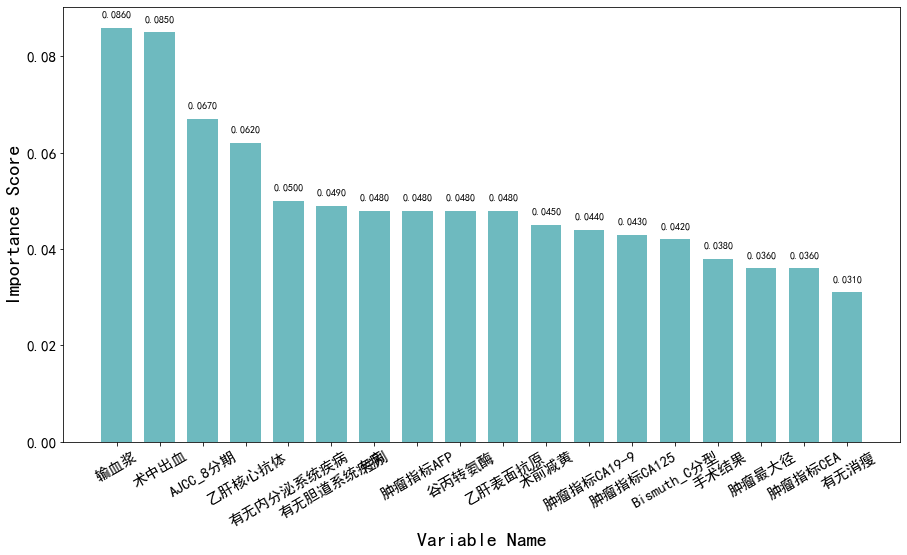

In [29]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.42941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)
plt.xticks(rotation=30)

plt.ylabel('Importance Score',fontsize=20)
plt.xlabel('Variable Name',fontsize=20)
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [51]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [52]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

-----------------------画图---------------------------


<Figure size 432x288 with 0 Axes>

### AUC曲线

In [56]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

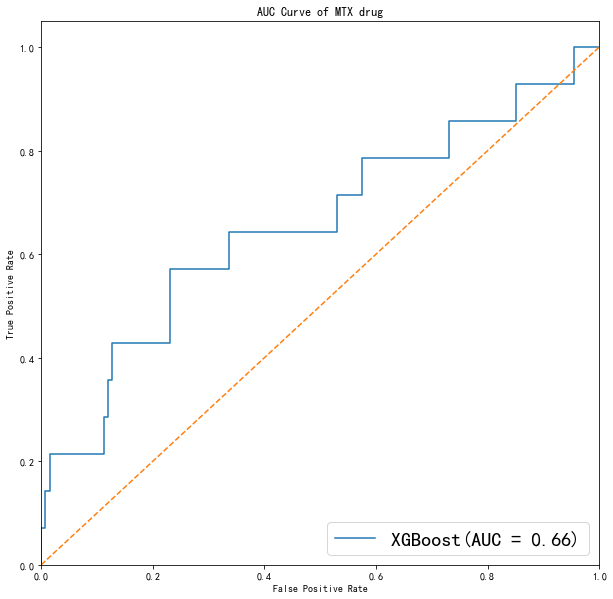

In [87]:
plt.figure(figsize=(10,10))

# plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
# plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
# plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

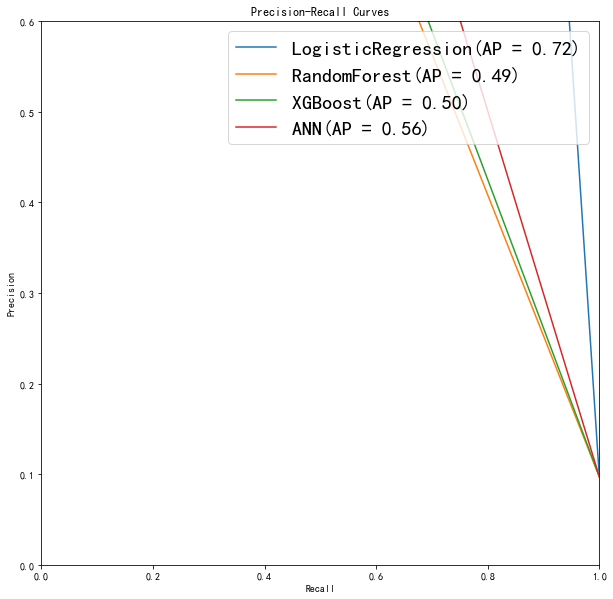

In [57]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

#### summary_plot

In [661]:
pd.value_counts(tran_y_sm)

0.0    108
1.0    108
Name: 日剂量, dtype: int64

In [297]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import catboost,xgboost
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
cat_model.fit(tran_x_sm, tran_y_sm)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(tran_x_sm)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)

In [298]:
tran_x_sm=tran_x_sm.rename(columns={'日剂量':'上一次日剂量',
                                   'gender':'性别',
                                   'age':'年龄',
                                   'test_result':'上一次TDM值'})

In [941]:
?shap.summary_plot

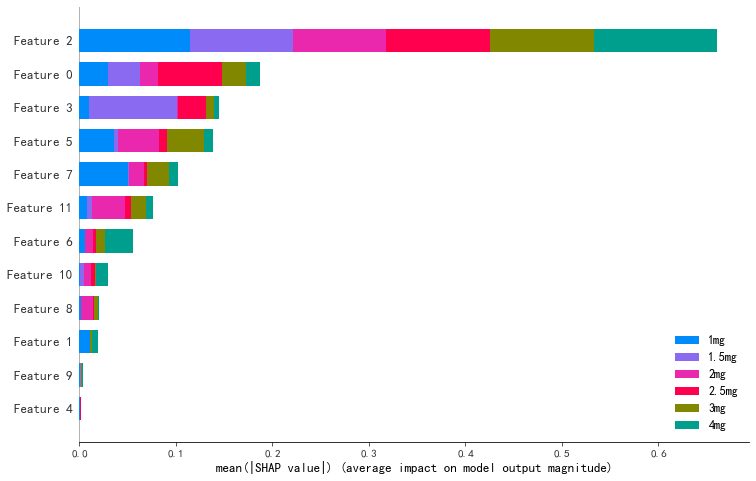

In [929]:
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x_sm,plot_size=(12,8),
                 class_names=['1mg','1.5mg','4mg','3mg','2.5mg','2mg'])

In [308]:
tran_x_sm.columns

Index(['体重', '钙离子阻抗剂', '上一次日剂量', '年龄', '糖尿病', '直接胆红素', '尿素', '淋巴细胞百分数', '高血压',
       '糖皮质激素', '性别', '上一次TDM值'],
      dtype='object')

In [320]:
type(shap_values)

list

In [666]:
df_shap_values

,0,1,2,3,4,5,6,label
0,3.333769,1.008152,0.988628,-0.071092,0.513993,-0.571060,-0.345089,1.0
1,-3.036667,0.556787,-0.042782,-0.244547,-1.502985,0.666590,-0.815771,0.0
2,-1.156161,1.305836,1.151194,0.457161,2.602305,-0.233718,-0.399447,1.0
3,-3.468739,-1.346333,-1.789265,-0.236250,-0.121771,-0.457438,-0.256855,0.0
4,6.506644,1.503949,-0.082385,0.171726,0.679662,1.065485,-0.120442,1.0
...,...,...,...,...,...,...,...,...
211,-3.600252,-1.580784,-0.314290,-0.153086,0.170325,0.124037,0.722369,0.0
212,-3.199505,0.303407,0.112323,-0.505899,-2.100364,-0.641356,-0.655191,0.0
213,-2.335317,-1.924601,-0.193261,-0.598222,0.712953,-0.463681,-0.873663,0.0
214,-3.077490,-0.876349,-0.247377,-0.402913,-1.704780,-0.386496,-0.755241,0.0


In [705]:
df_shap = pd.DataFrame(data={'features':shap_col,
                            'shap_pos':shap_pos_list,
                            'shap_neg':shap_neg_list})

In [706]:
df_shap

,features,shap_pos,shap_neg
0,VPA_TDM,82,134
1,P-LCR,123,93
2,PDW,116,100
3,Antipsychotic_drugs,98,118
4,Indirect_Bilirubin,131,85
5,PCV,94,122
6,Hb,65,151


In [708]:
df_shap.to_excel(project_path+'/data/result/df_shap.xlsx')

In [607]:
shap_list=[]
for i in range(df_shap_values.shape[1]-1):
    shap_value=df_shap_values.iloc[:,i].sum()
    shap_list.append(shap_value)
df_shap = pd.DataFrame(data={'features':tran_x_sm.columns,
                            'shap_value':shap_list})

In [609]:
df_shap_values.iloc[:,i]

0     -0.345089
1     -0.815771
2     -0.399447
3     -0.256855
4     -0.120442
         ...   
211    0.722369
212   -0.655191
213   -0.873663
214   -0.755241
215   -0.751668
Name: 6, Length: 216, dtype: float64

In [606]:
shap_list

[5.8572997963870295,
 -4.419375988914488,
 4.727170591923252,
 -7.676649352632006,
 10.724639449482003,
 8.021531210373883,
 8.82472834675256]

In [608]:
df_shap

,features,shap_value
0,test_result,-40.453473
1,大型血小板比值,36.070186
2,血小板分布宽度,-8.814643
3,血红蛋白测定,-0.772038
4,抗精神病药,12.686806
5,红细胞比积测定,1.033044
6,间接胆红素,0.250118


In [527]:
writer = pd.ExcelWriter(project_path + '/data/result/df_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()

#### multioutput_decision_plot

In [942]:
?shap.multioutput_decision_plot

In [963]:
col=df_model.columns.to_list()
col.remove('label')

In [964]:
col

['体重',
 '钙离子阻抗剂',
 '日剂量',
 'age',
 '糖尿病',
 '直接胆红素',
 '尿素',
 '淋巴细胞百分数',
 '高血压',
 '糖皮质激素',
 'gender',
 'test_result']

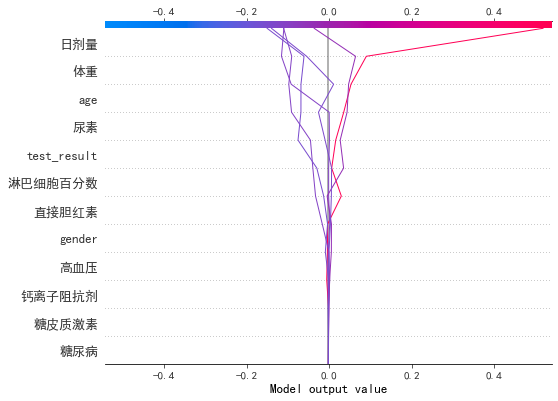

In [967]:
shap.multioutput_decision_plot(shap_values,shap_values,row_index=3,
                              feature_names=col)

In [935]:
shap_values

[array([[ 1.7884551e-02, -4.7067376e-03,  2.6966387e-01, ...,
         -1.2953198e-05,  5.6798651e-04, -3.8480440e-03],
        [-4.1816123e-02, -6.2801642e-03, -7.8413635e-02, ...,
         -2.7280410e-05, -1.8625727e-04, -8.1662061e-03],
        [ 3.9592050e-02,  9.0608848e-03,  2.9020017e-01, ...,
         -1.2953198e-05, -6.2250026e-04,  7.3326016e-03],
        ...,
        [ 2.5673578e-02, -1.4627557e-02, -6.8878576e-02, ...,
         -2.7280410e-05, -2.0426390e-04, -2.1328896e-02],
        [-4.1581895e-02,  1.0974685e-02, -7.5531624e-02, ...,
         -4.7779835e-05, -6.5903337e-04, -3.6281857e-03],
        [ 1.5059070e-02, -1.0826434e-02, -9.7172759e-02, ...,
         -4.7779835e-05,  8.0837111e-04, -7.6254238e-03]], dtype=float32),
 array([[ 0.0705109 ,  0.        ,  0.00364254, ..., -0.00032048,
          0.0028362 ,  0.00838457],
        [-0.04089006,  0.        , -0.08070022, ..., -0.00069359,
         -0.00989467, -0.00038218],
        [-0.01878903,  0.        ,  0.01004871

### 混淆矩阵图

In [323]:
from sklearn.metrics import classification_report,confusion_matrix
import catboost
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)
# 计算混淆矩阵
cat_confusion=confusion_matrix(test_y,cat_predictions)

In [324]:
cat_confusion

array([[4, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 0],
       [1, 0, 5, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 4, 0],
       [0, 0, 1, 0, 0, 3]], dtype=int64)

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


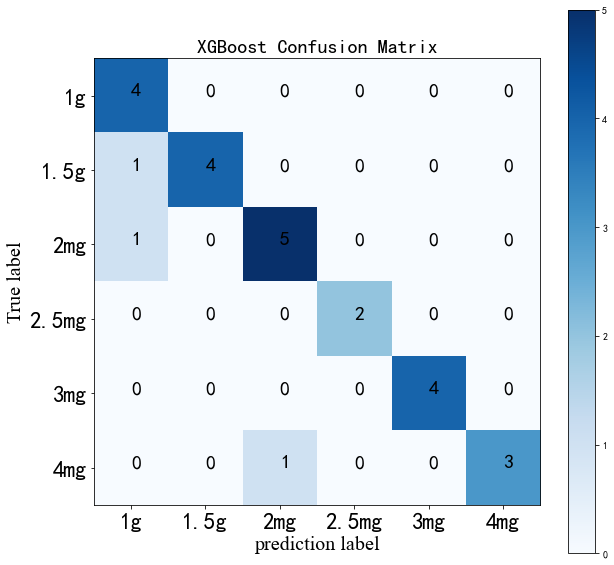

In [330]:
plt.figure(figsize=(10,10))
plt.imshow(cat_confusion, cmap=plt.cm.Blues) # 在特定的窗口上显示图像
# 设置图表标题
plt.title('XGBoost Confusion Matrix',size=20)    # 图像标题
plt.colorbar()
# 设置坐标轴标题
font_x = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,}
plt.xlabel('prediction label',font_x)
plt.ylabel('True label',font_x)
# 设置坐标轴刻度
plt.tick_params(labelsize=23)  # 设置刻度值大小
label_names=['1g','1.5g','2mg','2.5mg','3mg','4mg']
plt.xticks(range(len(label_names)),label_names)
plt.yticks(range(len(label_names)),label_names)
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        plt.text(second_index,first_index, cat_confusion[first_index][second_index],size=20)
plt.show()

In [471]:
cat_confusion

array([[27,  0],
       [ 1,  5]], dtype=int64)

In [475]:
for first_index in range(len(cat_confusion)):    #第几行
    print(cat_confusion[first_index])
    break

[27  0]


In [476]:
for second_index in range(len(cat_confusion[first_index])):    #第几列
    print(cat_confusion[first_index][second_index])

27
0


0 0
27
0 1
0
1 0
1
1 1
5


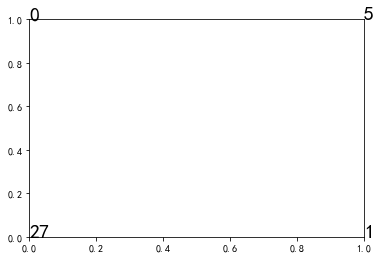

In [480]:
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        print(cat_confusion[first_index][second_index])
        plt.text(first_index, second_index, cat_confusion[first_index][second_index],size=20)
plt.show()

### tabnet mask graph

In [299]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=15,
        num_workers=0,
        drop_last=False)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:01s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:02s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

In [211]:
explain_matrix,masks=TabNet_model.explain(tran_x_sm.to_numpy())

AttributeError: 'CatBoostClassifier' object has no attribute 'explain'

NameError: name 'explain_matrix' is not defined

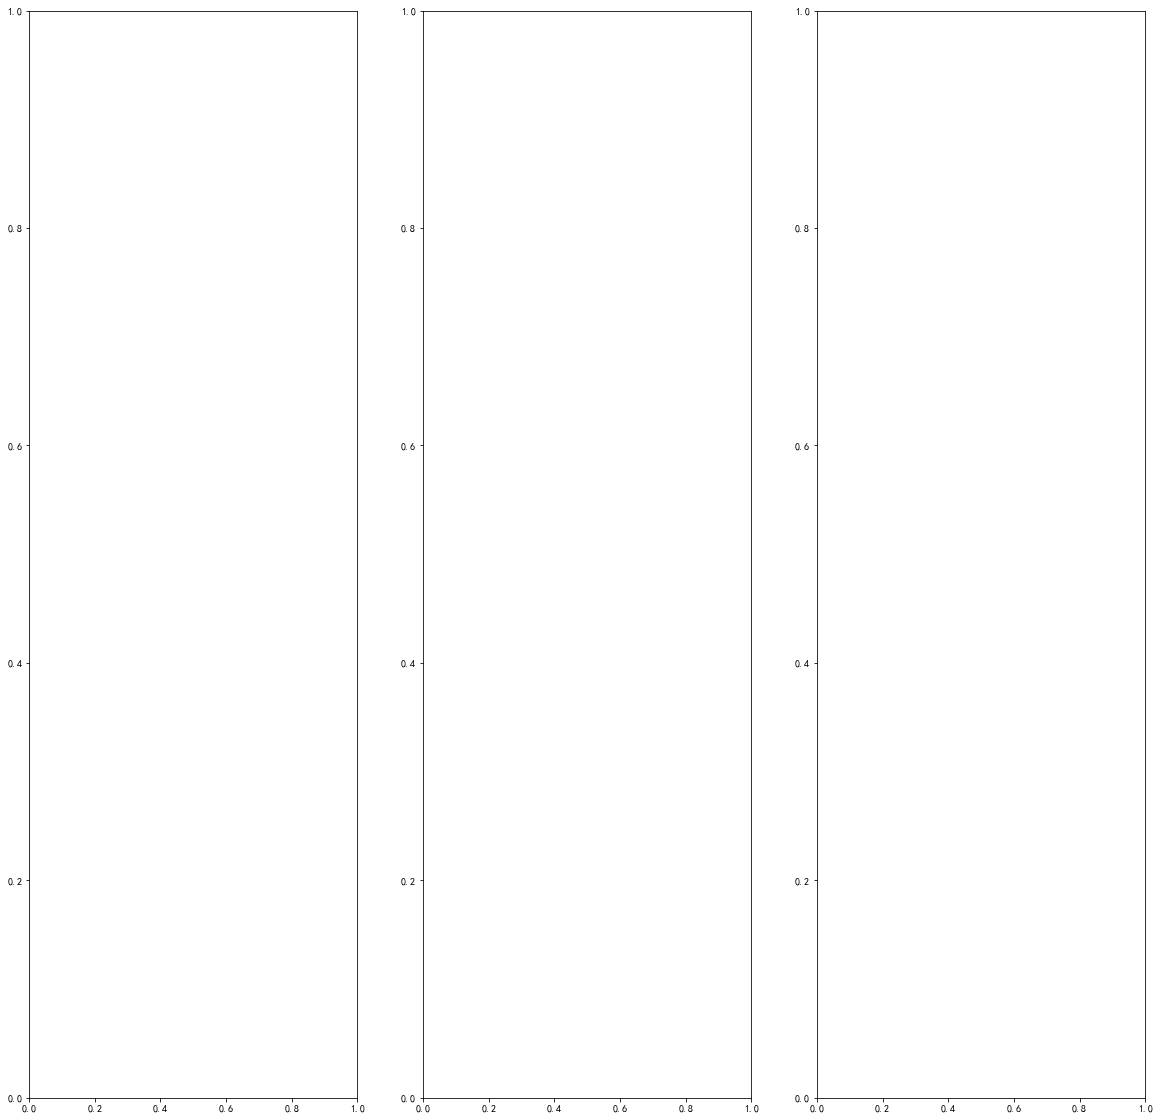

In [212]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(40,40))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.yticks(np.arange(0, len(explain_matrix), 1.0))
# plt.xticks(np.arange(0, len(explain_matrix[0]), 1.0))
# ax.set_xticklabels(tran_x_sm.columns, rotation=75)
# plt.ylabel('Sample Number')
# plt.xlabel('Variable')
# # plt.imshow(explain_matrix[:30])  # 显示30个

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].set_yticks(np.arange(0, len(explain_matrix), 1.0))  # 设置左边间距
    axs[i].set_xticks(np.arange(0, len(explain_matrix[0]), 2.0))
    axs[i].set_ylabel('Sample Number',size=20)
    axs[i].set_xlabel('Variable',size=20)
    # 设置坐标刻度值的大小
    axs[i].tick_params(labelsize=15)
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(tran_x_sm.columns[::2], rotation=90)

In [351]:
tran_x_sm.columns

Index(['单核细胞绝对值', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '单核细胞百分比', '淋巴细胞百分比',
       '乳酸脱氢酶(干式)', '托烷司琼', '中性细胞绝对值', '嗜酸性细胞绝对值', '谷胱甘肽', '红细胞', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'age', 'gender', 'RBC平均容量', 'MTX_tdm_72h',
       '白蛋白(干式)', '中性细胞百分比', 'MTX_tdm_48h', '总蛋白(干式)', '淋巴细胞绝对值', '吸烟史',
       '肌酐(干式)', 'MTX_tdm_24h', '日剂量', '长春新碱', 'RBC血红浓度'],
      dtype='object')